In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
display(HTML("<style>.output_result { max-width:98% !important; }</style>"))


## Version info:
- all data (ungranted as well)
- IPFs only
- Counting by: inventors

### Imports

In [2]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import plotly.graph_objects as go
import plotly.express as px
import plotly.colors as colors
from datetime import datetime
import re
import os
import csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.base import clone
import plotly.io as pio
import math
import itertools as it
from collections import Counter
from random import choice
from nltk.util import ngrams, everygrams
import copy

# Set default color palette
colors_plotly_default = colors.qualitative.Plotly

main_path_mac = '/Users/philippmetzger/Documents/GitHub/battery_patents/'
main_path_ssd = '/Volumes/Samsung Portable SSD T3 Media/'

import sys
packages_path = main_path_mac+'/02 Code'
sys.path.append(packages_path)

from helpers import (current_time_string,
                              image_saver,
                              country_labels_dict,
                              ctry_code_name_dict,
                              message,
                              numbers_dict)


In [3]:
# Create another dictionary that is almost the same as ctry_code_name_dict. Just some values are changed
# due to different country names in UN populations dataset
ctry_code_name_dict_UN = ctry_code_name_dict.copy()

# Define a function for this purpose
def replace_dict_value(dict_, key_, new):
    
    dict_[key_] = new

# Define changes: First values = key, second values = new values
key_new = [
    ('TW', 'China, Taiwan Province of China'),
    ('HK', 'China, Hong Kong SAR'),
    ('SH', 'Saint Helena'),
    ('KP', "Dem. People's Republic of Korea"),
    ('MO', 'China, Macao SAR')
]

# Execute changes
for tuple_ in key_new:
    replace_dict_value(ctry_code_name_dict_UN, tuple_[0], tuple_[1])
    

In [4]:
# Create another dictionary that is almost the same as ctry_code_name_dict. Just some values are changed
# due to different country names in world bank work force dataset
ctry_code_name_dict_world_bank = ctry_code_name_dict.copy()

# Define a function for this purpose
def replace_dict_value(dict_, key_, new):
    
    dict_[key_] = new

# Define changes: First values = key, second values = new values
key_new = [
    ('KR', 'Korea, Rep.'),
    ('US', 'United States'),
    ('HK', 'Hong Kong SAR, China'),
    ('BS', 'Bahamas, The'),
    ('CZ', 'Czech Republic'),
    ('IR', 'Iran, Islamic Rep.'),
    ('SK', 'Slovak Republic'),
    ('VE', 'Venezuela, RB'),
    ('EG', 'Egypt, Arab Rep.'),
    ('KP', "Korea, Dem. People's Rep."),
    ('EG', 'Egypt, Arab Rep.'),
    ('KG', 'Kyrgyz Republic'),
    ('LA', 'Lao PDR'),
    ('MO', 'Macao SAR, China'),
    ('LC', 'St. Lucia'),
    ('TZ', 'Tanzania'),
    ('VN', 'Vietnam')
]

# Execute changes
for tuple_ in key_new:
    replace_dict_value(ctry_code_name_dict_world_bank, tuple_[0], tuple_[1])
    

In [5]:
message()


executing a function from helpers.py


In [6]:
current_time_string()


'2022-02-07_1547'

## Read the whole dataset and reduce it to what we are interested in

In [7]:
# Read the whole dataset
dataset_name = 'data_batteries_2022-01-26_1852'

path = main_path_ssd+'Dataset saves/04 From 15 Nov 2021 (release of 2021 Autumn edition)/01 Preprocessed/03 final - technologies tagged/'+dataset_name+'.csv'

print('Loading data from:')
print(path)

data = pd.read_csv(path, delimiter = ";", low_memory = False, na_values=['', ' ', '  '], keep_default_na = False)

print('Number of rows:', len(data))

print('Distinct values in column "granted":', pd.unique(data['granted']))

# Reduce it to non active parts, electrodes, secondary cells, charging, redox flow, and Nickel-Hydrogen
a = (data['non_active_parts_electrodes_secondary_cells'] == 1)
b = (data['charging'] == 1)
c = (data['is_Redox flow'] == 1)
d = (data['is_Nickel–hydrogen'] == 1)

data_reduced = data[a | b | c | d].copy()
del data
data = data_reduced

# Futher reduce it to IPFs only
data_ipf = data[data['tag'] == 'IPF'].copy()
ipf_percentage = (len(set(data_ipf['docdb_family_id'])) / len(set(data['docdb_family_id']))) * 100
print('Percentage of IPFs in relation to all battery patent families:'+str(round(ipf_percentage, 2))+'%')
del data
data = data_ipf


Loading data from:
/Volumes/Samsung Portable SSD T3 Media/Dataset saves/04 From 15 Nov 2021 (release of 2021 Autumn edition)/01 Preprocessed/03 final - technologies tagged/data_batteries_2022-01-26_1852.csv
Number of rows: 4086532
Distinct values in column "granted": ['N' 'Y']
Percentage of IPFs in relation to all battery patent families:19.41%


## Reduce to years we are interested in

In [8]:
print(set(data['earliest_publn_year_this_family_id']))


{1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019}


In [9]:
data_reduced = data[data['earliest_publn_year_this_family_id'] >= 2000].copy()
del data
data = data_reduced


In [10]:
print(set(data['earliest_publn_year_this_family_id']))


{2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019}


## Define variable only_granted. Only used for creation of plot filenames

In [11]:
only_granted = False


## Make a few checks: Total number of IPFs, number of IPFs related to different categories, distinct values in column 'tag'

In [12]:
len(list(set(data['docdb_family_id'])))


92700

In [13]:
len(list(set(data[data['non_active_parts_electrodes_secondary_cells'] == 1]['docdb_family_id'])))


63282

In [14]:
len(list(set(data[data['charging'] == 1]['docdb_family_id'])))


44039

In [15]:
len(list(set(data[data['is_Redox flow'] == 1]['docdb_family_id'])))


843

In [16]:
set(data['tag'])


{'IPF'}

## In person_ctry_code: Replace NaNs with '  '

In [17]:
data['person_ctry_code'].fillna('  ', inplace = True)
#data['person_ctry_code_imputed'].fillna('  ', inplace = True)


## Dataset integrity check

In [18]:
def check_if_docdb_family_size_is_equal_to_number_of_applications(data_to_check):

    """Version 2 - 3. Jan 2022 (altered version from function in Create_db_4)
    Does not print when unequal. Instad increments a counter that it returns."""
    
    reduced = data_to_check[['docdb_family_id','appln_id','docdb_family_size']].drop_duplicates()

    family_ids = pd.unique(reduced['docdb_family_id'])

    counter = 0
    
    for family_id in tqdm(family_ids):
        
        reduced_this_family_id = reduced[reduced['docdb_family_id'] == family_id]

        len_ = len(reduced_this_family_id)
        docdb_family_size = list(set(reduced_this_family_id['docdb_family_size']))

        if len(docdb_family_size) > 1:
            print(str(family_id)+': There is more than one docdb_family_size.')
            break

        docdb_family_size = docdb_family_size[0]

        if (len_ != docdb_family_size):
            #print(str(family_id)+': docdb_family_size is not equal to the number of applications contained in this family')
            counter += 1
            
    return counter

In [19]:
# Returns 0 if all is as it should be
# Uncomment this to check

#check_if_docdb_family_size_is_equal_to_number_of_applications(data)


## Infer our time frame from data

In [20]:
year_begin = min(data['earliest_publn_year_this_family_id'])
year_end = max(data['earliest_publn_year_this_family_id'])

years = list(range(year_begin, year_end + 1))
print(years)


[2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]


## Assess missing values situation
### Check the percentage of missing values in person_ctry_code

In [21]:
len(data[data['person_ctry_code'] == '  ']) / len(data)
#len(data[data['person_ctry_code'].isna()]) / len(data)
#len(data[data['person_ctry_code'] == '  ']) / len(data)
#len(data[data['person_ctry_code'].isna()]) / len(data)


0.3070879822843029

### Get the application authority distribution for rows with missing person_ctry_code

In [22]:
nan_data_appln_auth_counts = data[data['person_ctry_code'] == '  '].groupby(by='appln_auth').count().sort_values(by='docdb_family_id', ascending=False).rename(columns=({'docdb_family_id':'count'}))['count']
nan_data_appln_auth_counts[:10]


appln_auth
CN    223386
JP    144619
KR     31137
AU     14767
WO     12088
ES      6481
HK      4170
MX      2521
US      2249
BR      1471
Name: count, dtype: int64

### Share of applications with missing person_ctry_code that are filed in China

In [23]:
nan_share_china = nan_data_appln_auth_counts['CN'] / nan_data_appln_auth_counts.sum()
nan_share_china


0.4956533315582773

### Share of applications with missing person_ctry_code that are filed in Japan

In [24]:
nan_share_japan = nan_data_appln_auth_counts['JP'] / nan_data_appln_auth_counts.sum()
nan_share_japan


0.3208835341365462

### Share of applications with missing person_ctry_code that are filed in the rest of the world

In [25]:
1 - nan_share_china - nan_share_japan


0.18346313430517652

## Check how many countries are involved in this analysis

In [26]:
countries_all = set(data[data['invt_seq_nr']>0]['person_ctry_code'])
countries_all.remove('  ')
print(len(countries_all))
#countries_all


128


## Define the core function of this notebook

In [27]:
# Version 13. Jan. 2022: Enhanced fractional counting (for technologies)

def get_counts(data_to_function, use_tqdm, nat_intl_separation, count_inventors, technologies):
    
    if count_inventors:
        data_to_function = data_to_function[data_to_function['invt_seq_nr'] > 0]
    else:
        data_to_function = data_to_function[data_to_function['applt_seq_nr'] > 0]
        
    ctry_codes_this = sorted(list(set(data_to_function['person_ctry_code'])))
    
    family_ids_this = pd.unique(data_to_function['docdb_family_id'])

    family_id_ctry_codes = {}
    family_id_coo_appln_auth = {}
    
    if technologies:
        # Dictionary for the number of technologies each patent family is assignted to
        family_id_num_technologies = {}
    
    # A wrapper function for turning tqdm on or off
    def tqdm_wrapper(input_):
        if use_tqdm:
            return tqdm(input_)
        else:
            return input_

    # Loop over family IDs and get all country codes of each family ID. Also delete unknown country code entries
    # (country code = '  ')
    for family_id in tqdm_wrapper(family_ids_this):
        
        data_this_family_id = data_to_function[data_to_function['docdb_family_id']==family_id]

        ##########################################
        # Change in this version (13. Jan. 2022) #
        ##########################################
        # Old code line:
        #ctry_codes_this_family_id = list(set(data_this_family_id['person_ctry_code']))
        # New in this version:
        # Get the person_ctry_codes for each distinct (psn_name, person_ctry_code) pair
        ctry_codes_this_family_id = list(
            data_this_family_id[data_this_family_id['person_ctry_code'] != '  '][['psn_name', 'person_ctry_code']].groupby(
                by = ['psn_name', 'person_ctry_code']
            ).size().reset_index(name='Freq')['person_ctry_code']
        )        
        
        # Not needed anymore
        #try:
        #    ctry_codes_this_family_id.remove('  ')
        #except:
        #    pass
            
        family_id_ctry_codes[family_id] = ctry_codes_this_family_id
        
        if technologies:
            # Save the number of technologies this patent family is assignted to
            num_technologies_this_family_id = list(set(data_this_family_id['technologies_one_hot_sum']))
            
            # Throw error if there is more than one distinct value
            if len(num_technologies_this_family_id) > 1:
                print('More than one one-hot-sum')
                return
            
            family_id_num_technologies[family_id] = num_technologies_this_family_id[0]
        
    # Create a dictionary full of zeros
    ctry_codes_counts = {}
    for key_ in ctry_codes_this:
        
        ctry_codes_counts[key_] = 0
        
        if nat_intl_separation:
            
            key_intl_string = key_+'_intl'
            ctry_codes_counts[key_intl_string] = 0
        
    # Loop over dictionary and increment its values to create the count
    # Increment by 1/k, k being the number of distinct country codes for a given family ID
    nat_int_counter = {'national':0,
                       'international':0,
                       'unknown':0}
    for key_ in list(family_id_ctry_codes):

        size_ = len(family_id_ctry_codes[key_])
        
        # New in this version (13. Jan. 2022). Need this for nat_intl_separation separation mode
        num_distinct_ctry_codes_this_id = len(list(set(family_id_ctry_codes[key_])))
        
        # Get this patent family's number of technologies it is assignted to
        if technologies:
            l = family_id_num_technologies[key_]
        else:
            l = 1

        if size_==0:

            ctry_codes_counts['  '] += 1/l
            
            nat_int_counter['unknown'] += 1/l

        else:
            
            if nat_intl_separation:
                
                # Changed in this version (13. Jan. 2022):
                if num_distinct_ctry_codes_this_id == 1:
                    
                    ctry_codes_counts[family_id_ctry_codes[key_][0]] += 1/l
                    
                    nat_int_counter['national'] += 1/l
                    
                else:
                    
                    for item in family_id_ctry_codes[key_]:
                        
                        item_intl_string = item+'_intl'

                        ctry_codes_counts[item_intl_string] += (1/size_)/l
                        
                    nat_int_counter['international'] += 1/l
            
            else:

                for item in family_id_ctry_codes[key_]:

                    ctry_codes_counts[item] += (1/size_)/l
    
    ctry_codes_counts_sorted = dict(sorted(ctry_codes_counts.items(), key=lambda x:x[1], reverse=True))

    try:
        known_percentage = (1 - (ctry_codes_counts['  '] / sum(ctry_codes_counts.values()))) * 100
    except:
        known_percentage = 100

    if nat_intl_separation:
        return family_id_ctry_codes, ctry_codes_counts_sorted, known_percentage, ctry_codes_this, nat_int_counter
    
    else:
        return family_id_ctry_codes, ctry_codes_counts_sorted, known_percentage
    

## Separation of patent families with applicants from only one country vs. international cooperations

In [28]:
def nat_int_prepare_df(nat_intl_dict, ctry_codes_list):
    
    dict_ = nat_intl_dict.copy()
    list_ = ctry_codes_list.copy()
    
    dict_.pop('  ')
    dict_.pop('  _intl')
    list_.remove('  ')
    
    #####
    
    array_ = []

    for key_ in list_:

        key_intl_string = key_+'_intl'

        if key_ in list(country_labels_dict):
            country_name = country_labels_dict[key_]
        else:
            country_name = ctry_code_name_dict[key_]

        row = [country_name, dict_[key_], dict_[key_intl_string]]

        array_.append(row)
        
    #####
    
    num_countries_to_plot = 6

    col_1 = 'Country'
    col_2 = 'Patent families with national inventors only'
    col_3 = 'Patent families with inventors from at least one other country'

    nat_intl_df = pd.DataFrame(array_, index=None, columns = [col_1, col_2, col_3]).sort_values([col_2, col_3], ascending=True)
    nat_intl_df = nat_intl_df[-num_countries_to_plot:]

    #####
    
    col_4 = 'intl/(nat+intl)'
    col_5 = 'nat+intl'

    nat_intl_ratio_df = nat_intl_df.copy()
    nat_intl_ratio_df[col_4] = nat_intl_ratio_df['Patent families with inventors from at least one other country'] / (nat_intl_ratio_df['Patent families with national inventors only'] + nat_intl_ratio_df['Patent families with inventors from at least one other country'])
    nat_intl_ratio_df[col_5] = (nat_intl_ratio_df['Patent families with national inventors only'] + nat_intl_ratio_df['Patent families with inventors from at least one other country'])
    nat_intl_ratio_df.sort_values([col_5], ascending=True, inplace = True)
    
    return nat_intl_ratio_df


In [29]:
def nat_int_plot(df, years):
    
    col_1 = 'Country'
    col_2 = 'Patent families with national inventors only'
    col_3 = 'Patent families with inventors from at least one other country'
    col_4 = 'intl/(nat+intl)'
    col_5 = 'nat+intl'
    
    x_label_string = 'Total number of battery patent families in '+str(min(years))+'-'+str(max(years))
    #y_label_string = 'Country code'

    nat_intl_counts_plot = px.bar(df,
                                  y = "Country",
                                  x=[col_2, col_3])
    nat_intl_counts_plot.update_xaxes(title=x_label_string)

    nat_intl_counts_plot.update_layout(
        legend=dict(yanchor="bottom",
                    y=0.02,
                    xanchor="right",
                    x=0.99,
                    title=''))

    for i in range(len(df)):
        nat_intl_counts_plot.add_annotation(x = list(df[col_5])[i],
                                            y = i,
                                            text = str(round(list(df[col_4])[i]*100, 2))+'%',
                                            showarrow = False,
                                            xshift = 25)

    nat_intl_counts_plot.show()

    # Save this plot as eps
    if only_granted:
        filename = 'nat_intl_counts_only_granted'
    else:
        filename = 'nat_intl_counts_all_appln'

    #image_saver(nat_intl_counts_plot, filename, True)
    

### Whole time period

In [30]:
family_id_ctry_codes_whole_time_nat_intl, ctry_codes_counts_whole_time_nat_intl, known_percentage_whole_time_nat_intl, ctry_codes_whole_time, nat_int_counter_whole_time = get_counts(
    data,
    True,
    True,
    True,
    False)


  0%|          | 0/92667 [00:00<?, ?it/s]

### Split in two time periods

In [31]:
years_nat_int_first_part = [2000, 2013]

data_nat_int_first_part = data[
    ((data['earliest_publn_year_this_family_id'] >= years_nat_int_first_part[0]) & (data['earliest_publn_year_this_family_id'] <= years_nat_int_first_part[1]))]

family_id_ctry_codes_first_part_nat_intl, ctry_codes_counts_first_part_nat_intl, known_percentage_first_part_nat_intl, ctry_codes_first_part, nat_int_counter_first_part = get_counts(
    data_nat_int_first_part,
    True,
    True,
    True,
    False)

years_nat_int_second_part = [2014, 2018]

data_nat_int_second_part = data[
    ((data['earliest_publn_year_this_family_id'] >= years_nat_int_second_part[0]) & (data['earliest_publn_year_this_family_id'] <= years_nat_int_second_part[1]))
]

family_id_ctry_codes_second_part_nat_intl, ctry_codes_counts_second_part_nat_intl, known_percentage_second_part_nat_intl, ctry_codes_second_part, nat_int_counter_second_part = get_counts(
    data_nat_int_second_part,
    True,
    True,
    True,
    False)


  0%|          | 0/39580 [00:00<?, ?it/s]

  0%|          | 0/41949 [00:00<?, ?it/s]

In [32]:
print(set(data_nat_int_first_part['earliest_publn_year_this_family_id']))


{2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013}


In [33]:
print(set(data_nat_int_second_part['earliest_publn_year_this_family_id']))


{2016, 2017, 2018, 2014, 2015}


### Get the dataframes

In [34]:
nat_intl_df_whole_whole_time = nat_int_prepare_df(ctry_codes_counts_whole_time_nat_intl,
                                                  ctry_codes_whole_time)
nat_intl_df_whole_whole_time


Country  Patent families with national inventors only  \
118       Taiwan                                        2921.0   
22         China                                        7931.0   
28       Germany                                        8024.0   
121          USA                                       11529.0   
64   South Korea                                       13340.0   
58         Japan                                       31520.0   

     Patent families with inventors from at least one other country  \
118                                         371.131874                
22                                          783.981651                
28                                          723.340387                
121                                        1854.210054                
64                                          612.002101                
58                                          525.056969                

     intl/(nat+intl)      nat+intl  
118         0.112733   3292.131874  
22          0.089958   8714.981651  
28          0.082693   8747.340387  
121         0.138547  13383.210054  
64          0.043865  13952.002101  
58          0.016385  32045.056969

In [35]:
nat_intl_df_whole_first_part = nat_int_prepare_df(ctry_codes_counts_first_part_nat_intl,
                                                  ctry_codes_first_part)
nat_intl_df_whole_first_part


Country  Patent families with national inventors only  \
104       Taiwan                                        1469.0   
22         China                                        1767.0   
28       Germany                                        3490.0   
61   South Korea                                        4642.0   
107          USA                                        5001.0   
55         Japan                                       14969.0   

     Patent families with inventors from at least one other country  \
104                                         214.967978                
22                                          387.519668                
28                                          351.865485                
61                                          305.654002                
107                                         951.014358                
55                                          303.324547                

     intl/(nat+intl)      nat+intl  
104         0.127656   1683.967978  
22          0.179864   2154.519668  
28          0.091587   3841.865485  
61          0.061778   4947.654002  
107         0.159780   5952.014358  
55          0.019861  15272.324547

In [36]:
nat_intl_df_whole_second_part = nat_int_prepare_df(ctry_codes_counts_second_part_nat_intl,
                                                   ctry_codes_second_part)
nat_intl_df_whole_second_part


Country  Patent families with national inventors only  \
93       Taiwan                                        1216.0   
21      Germany                                        3485.0   
16        China                                        4461.0   
96          USA                                        5319.0   
50  South Korea                                        6896.0   
47        Japan                                       13241.0   

    Patent families with inventors from at least one other country  \
93                                         120.670747                
21                                         294.781270                
16                                         316.359920                
96                                         748.376396                
50                                         265.060837                
47                                         184.915975                

    intl/(nat+intl)      nat+intl  
93         0.090277   1336.670747  
21         0.077989   3779.781270  
16         0.066221   4777.359920  
96         0.123344   6067.376396  
50         0.037014   7161.060837  
47         0.013773  13425.915975

### Plot national/international counts

In [37]:
nat_int_plot(nat_intl_df_whole_whole_time, years)


In [38]:
nat_int_plot(nat_intl_df_whole_first_part, years_nat_int_first_part)


In [39]:
nat_int_plot(nat_intl_df_whole_second_part, years_nat_int_second_part)


### Grouped bar plot comparing percentages from first and second time periods

In [40]:
colname_first_part = 'Share of co-inventions in '+str(min(years_nat_int_first_part))+'-'+str(max(years_nat_int_first_part))
colname_second_part = 'Share of co-inventions in '+str(min(years_nat_int_second_part))+'-'+str(max(years_nat_int_second_part))

comparison_df = pd.DataFrame.from_records(
    [
        dict(nat_intl_df_whole_first_part[['Country', 'intl/(nat+intl)']].values),
        dict(nat_intl_df_whole_second_part[['Country', 'intl/(nat+intl)']].values)
    ],
    index = [
        colname_first_part,
        colname_second_part
    ]
)

# Transpose and reverse row order
comparison_df = comparison_df.transpose()[::-1]
comparison_df


Share of co-inventions in 2000-2013  \
Japan                                   0.019861   
USA                                     0.159780   
South Korea                             0.061778   
Germany                                 0.091587   
China                                   0.179864   
Taiwan                                  0.127656   

             Share of co-inventions in 2014-2018  
Japan                                   0.013773  
USA                                     0.123344  
South Korea                             0.037014  
Germany                                 0.077989  
China                                   0.066221  
Taiwan                                  0.090277

In [41]:
countries = list(comparison_df.index)

cols = list(comparison_df)
#cols.reverse()

co_invention_ratio_data = []
for col_ in cols:
    co_invention_ratio_data.append(
        go.Bar(name = col_,
               y = countries,
               x = list(comparison_df[col_]),
               orientation='h')
    )

co_invention_ratio_layout = go.Layout(
    
    legend = dict(
        orientation="h",
        yanchor="top",
        y = -0.07,
        xanchor="left",
        x = 0,
        #traceorder = 'reversed'
    ),
    
    plot_bgcolor = "white",
    
    yaxis=dict(
        #title = 'Country',
        color = 'black',
        showgrid = False,
        #gridwidth = 1,
        #gridcolor = 'black',
        #type = "log",
        dtick = 0.5
    ),
    
    xaxis=dict(
        #title = '%',
        color = 'black',
        showgrid = True,
        gridwidth = 1,
        gridcolor = 'black',
        tickformat = '%'
        #dtick = 1
    )
)
    
co_invention_ratio_plot = go.Figure(data = co_invention_ratio_data, layout = co_invention_ratio_layout)

co_invention_ratio_plot.update_yaxes(autorange="reversed")
#co_invention_ratio_plot.update_legend(traceorder="reversed")

# Add annotations
shift_dir = -1
for col_ in list(comparison_df):
    
    shift_dir = shift_dir * (-1)
    
    for i in range(len(comparison_df)):
        
        co_invention_ratio_plot.add_annotation(x = list(comparison_df[col_])[i],
                                               y = i,
                                               text = str(round(list(comparison_df[col_])[i]*100, 1))+'%',
                                               showarrow = False,
                                               xshift = 25,
                                               yshift = shift_dir * 10,
                                               bgcolor = 'white',
                                               #opacity=0.1
                                              )
    
# Change the bar mode
co_invention_ratio_plot.update_layout(barmode='group')
co_invention_ratio_plot.show()

#image_saver(co_invention_ratio_plot, 'co_invention_ratio_plot', True)


## Count patents for the whole time period

In [42]:
family_id_ctry_codes_whole_time, ctry_codes_counts_whole_time, known_percentage_whole_time = get_counts(data,
                                                                                                        True,
                                                                                                        False,
                                                                                                        True,
                                                                                                        False)


  0%|          | 0/92667 [00:00<?, ?it/s]

In [43]:
known_percentage_whole_time


98.01115823324395

In [44]:
#ctry_codes_counts_whole_time


### Prepare plot for countries' total over the whole timespan

In [45]:
path = main_path_mac + '03 Extra data/PATSTAT reference tables/TLS801_COUNTRY.csv'
continents_patstat = pd.read_csv(path, delimiter = ';').dropna().reset_index(drop=True)
continents_patstat = continents_patstat[['ctry_code', 'continent']]
continents_patstat


ctry_code      continent
0          AD         Europe
1          AE           Asia
2          AF           Asia
3          AG  North America
4          AI  North America
..        ...            ...
220        YE           Asia
221        YU         Europe
222        ZA         Africa
223        ZM         Africa
224        ZW         Africa

[225 rows x 2 columns]

In [46]:
ctry_code_continent_dict = {}

for i in range(len(continents_patstat)):
    
    ctry_code_continent_dict[continents_patstat.loc[i,'ctry_code']] = continents_patstat.loc[i,'continent']
    

In [47]:
# Delete the counter for missing ctry_code values and create a sorted the dictionary with the other counters
data_whole_timespan_plot = ctry_codes_counts_whole_time.copy()
data_whole_timespan_plot.pop('  ')
data_whole_timespan_plot = dict(sorted(data_whole_timespan_plot.items(), key=lambda x:x[1], reverse=False))


In [48]:
# Save this data in order to use it in Co_occurences for size of country dots in network visualisation

if False:
    
    # open file for writing, "w" is writing
    if only_granted:
        file_ = open("country_sizes_only_granted.csv", "w")
    else:
        file_ = open("country_sizes_all_appln.csv", "w")

    # Create a csv writer
    writer_ = csv.writer(file_)

    # loop over dictionary keys and values
    for key_, value_ in data_whole_timespan_plot.items():

        # write every key and value to file
        writer_.writerow([key_, value_])

    # Close the file
    file_.close()


### Get all countries involved in this analysis sorted by their IPF counts

In [49]:
countries_all_sorted = list(data_whole_timespan_plot)
countries_all_sorted.reverse()
print(len(countries_all_sorted))
#countries_all_sorted


128


### Continue preparing the plot

In [50]:
number_countries = 8

countries_written = [country_labels_dict[item] for item in list(data_whole_timespan_plot.keys())[-number_countries:]]
continents = [ctry_code_continent_dict[item] for item in list(data_whole_timespan_plot.keys())[-number_countries:]]

df_countries = pd.DataFrame(data=[list(data_whole_timespan_plot.values())[-number_countries:],
                                  continents],
                            columns=countries_written, index=['Count', 'Continent']).transpose().reset_index(drop=False)

df_countries = df_countries.rename(columns={'index':'Country'})

df_countries = df_countries.sort_values(by='Count', ascending=False)

df_countries


Country         Count      Continent
7        Japan  32045.056969           Asia
6  South Korea  13952.002101           Asia
5          USA  13383.210054  North America
4      Germany   8747.340387         Europe
3        China   8714.981651           Asia
2       Taiwan   3292.131874           Asia
1       France   2528.540721         Europe
0           UK   1227.382398         Europe

In [51]:
top_countries_title = 'Top ' + str(number_countries) + ' countries of origin of battery patents, ' +str(min(years))+'-'+str(max(years))

x_label_string = 'Total number of battery patent families in '+str(year_begin)+'-'+str(year_end)
y_label_string = 'Country'

top_countries_plot = px.bar(df_countries,
                            x = 'Count', 
                            y = 'Country', 
                            color = 'Continent', 
                            orientation='h',
                            labels = {'Count':x_label_string, 'Country':y_label_string}
                           )

top_countries_plot.update_layout(yaxis={'categoryorder':'total ascending'},
                                 #title=top_countries_title
                                )

top_countries_plot.show()

# Save this plot as eps
if only_granted:
    filename = 'totals_by_country_only_granted'
else:
    filename = 'totals_by_country_all_appln'
    
#image_saver(top_countries_plot, filename, True)

top_countries_title


'Top 8 countries of origin of battery patents, 2000-2019'

## Count patents for each year

In [52]:
family_id_ctry_codes_list = []
ctry_codes_counts_list = []
known_percentage_list = []

for year in years:
    
    print('Year', str(year))
    
    data_to_function = data[data['earliest_publn_year_this_family_id']==year]
    
    family_id_ctry_codes, ctry_codes_counts, known_percentage = get_counts(data_to_function,
                                                                           True,
                                                                           False,
                                                                           True,
                                                                           False)
    
    family_id_ctry_codes_list = family_id_ctry_codes_list + [family_id_ctry_codes]
    ctry_codes_counts_list = ctry_codes_counts_list + [ctry_codes_counts]
    known_percentage_list = known_percentage_list + [known_percentage]
        

Year 2000


  0%|          | 0/979 [00:00<?, ?it/s]

Year 2001


  0%|          | 0/1164 [00:00<?, ?it/s]

Year 2002


  0%|          | 0/1132 [00:00<?, ?it/s]

Year 2003


  0%|          | 0/1195 [00:00<?, ?it/s]

Year 2004


  0%|          | 0/1288 [00:00<?, ?it/s]

Year 2005


  0%|          | 0/1594 [00:00<?, ?it/s]

Year 2006


  0%|          | 0/1998 [00:00<?, ?it/s]

Year 2007


  0%|          | 0/2152 [00:00<?, ?it/s]

Year 2008


  0%|          | 0/2484 [00:00<?, ?it/s]

Year 2009


  0%|          | 0/2816 [00:00<?, ?it/s]

Year 2010


  0%|          | 0/3380 [00:00<?, ?it/s]

Year 2011


  0%|          | 0/5163 [00:00<?, ?it/s]

Year 2012


  0%|          | 0/6770 [00:00<?, ?it/s]

Year 2013


  0%|          | 0/7465 [00:00<?, ?it/s]

Year 2014


  0%|          | 0/7976 [00:00<?, ?it/s]

Year 2015


  0%|          | 0/7796 [00:00<?, ?it/s]

Year 2016


  0%|          | 0/7904 [00:00<?, ?it/s]

Year 2017


  0%|          | 0/8514 [00:00<?, ?it/s]

Year 2018


  0%|          | 0/9759 [00:00<?, ?it/s]

Year 2019


  0%|          | 0/11138 [00:00<?, ?it/s]

In [53]:
ctry_codes_counts_list_copy = ctry_codes_counts_list.copy()


In [54]:
print(known_percentage_list)


[98.67211440245148, 98.79725085910653, 99.29328621908127, 99.4142259414226, 98.68012422360249, 99.12170639899624, 98.6986986986987, 98.7453531598513, 97.54428341384865, 97.26562500000001, 98.90532544378698, 97.55955839628123, 97.34121122599704, 97.1868720696584, 97.17903711133398, 98.10159055926115, 98.17813765182186, 98.50833920601362, 98.40147556102058, 97.97091039683964]


In [55]:
df = pd.DataFrame.from_records(ctry_codes_counts_list)
df.insert(loc=0, column='year', value=years)
df.rename(columns={'  ':'unknown'}, inplace=True)
df.fillna(0, inplace=True)
df_with_unknowns = df
#df


In [56]:
# Save this result to csv
#years_string = str(year_begin)+'-'+str(year_end)
#filename = 'country_counts_yearly_'+years_string+'.csv'
#df.to_csv(path_or_buf=filename, sep=';', index=False)


### Yearly totals plot

In [57]:
totals_series = df.drop(columns='year').sum(axis=1)
totals_series


0       979.0
1      1164.0
2      1132.0
3      1195.0
4      1288.0
5      1594.0
6      1998.0
7      2152.0
8      2484.0
9      2816.0
10     3380.0
11     5163.0
12     6770.0
13     7465.0
14     7976.0
15     7796.0
16     7904.0
17     8514.0
18     9759.0
19    11138.0
dtype: float64

In [58]:
totals_df = pd.DataFrame()

totals_df['year'] = years
totals_df['count'] = totals_series

totals_df.to_csv(path_or_buf= 'total_yearly_counts', sep=';', index=False)

totals_df


year    count
0   2000    979.0
1   2001   1164.0
2   2002   1132.0
3   2003   1195.0
4   2004   1288.0
5   2005   1594.0
6   2006   1998.0
7   2007   2152.0
8   2008   2484.0
9   2009   2816.0
10  2010   3380.0
11  2011   5163.0
12  2012   6770.0
13  2013   7465.0
14  2014   7976.0
15  2015   7796.0
16  2016   7904.0
17  2017   8514.0
18  2018   9759.0
19  2019  11138.0

### Get IPF increase from year 2000 to year 2019

In [59]:
total_2000 = totals_df[totals_df['year'] == 2000]['count'].values[0]
print(total_2000)
total_2019 = totals_df[totals_df['year'] == 2019]['count'].values[0]
print(total_2019)
total_2019 / total_2000


978.9999999999977
11137.999999999942


11.376915219611815

### Check what separation in two time slices makes most sense in terms of IPF counts

In [60]:
cut = 2014

totals_df_first_part = totals_df[totals_df['year'] <= cut]
#totals_df_first_part

totals_df_second_part = totals_df[totals_df['year'] > cut]
#totals_df_second_part

years_first_part = list(totals_df_first_part['year'])
sum_first_part = totals_df_first_part['count'].sum()
print(years_first_part)
print(sum_first_part)
print()

years_second_part = list(totals_df_second_part['year'])
sum_second_part = totals_df_second_part['count'].sum()
print(years_second_part)
print(sum_second_part)


[2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]
47555.99999999996

[2015, 2016, 2017, 2018, 2019]
45110.9999999998


In [61]:
totals_data = [dict(type='bar',
                        x=years,
                        y=totals_series
                       )]


### Compute mean increase year-over-year

In [62]:
increase = []

for i in range(1,len(totals_series)):
    
    increase_this_year = (totals_series[i] - totals_series[i-1]) / totals_series[i-1]
    print(increase_this_year)
    increase.append(increase_this_year)
    
sum(increase) / len(increase)


0.18896833503575422
-0.027491408934709843
0.055653710247348095
0.07782426778242797
0.2375776397515529
0.253450439146805
0.07707707707707387
0.15427509293680783
0.13365539452496264
0.20028409090908303
0.5275147928994088
0.31125314739492743
0.10265878877399964
0.06845277963831045
-0.02256770310932978
0.013853258081073475
0.07717611336032165
0.14622973925298674
0.14130546162517055


0.14300794823126184

In [63]:
totals_title = 'Development of the total number of battery IPFs, '+str(min(years))+'-'+str(max(years))

margin_ = 10

totals_layout =dict(
    #title=dict(
    #    text = person_ctry_code_title,
    #    y = 0.9,
    #    x = 0.5,
    #    xanchor = 'center',
    #    yanchor = 'top',
    #    font = dict(color = 'black')
    #),
    yaxis = dict(
        color = 'black',
        title = 'Number of IPFs',
        showgrid = True,
        gridwidth = 1,
        gridcolor = 'black',
        zerolinecolor = 'black',
        zerolinewidth = 1
    ),
    xaxis = dict(
        color = 'black',
        title='Earliest publication year',
        dtick = 1
    ),
    legend = dict(
        xanchor = "left",
        yanchor = "middle",
        y = 0.5, 
        x = 1,
        orientation = "v"
    ),
    plot_bgcolor = 'white',
    margin=dict(l=margin_, r=margin_, t=margin_, b=margin_)
)
    

In [64]:
totals_plot = go.Figure(data = totals_data, layout=totals_layout)
           
totals_plot.update_xaxes(dtick=1)

totals_plot.show()

# Save this plot as eps
if only_granted:
    filename = 'development_global_only_granted'
else:
    filename = 'development_global_all_appln'
    
image_saver(totals_plot, filename, True)

totals_title


executing a function from helpers.py


'Development of the total number of battery IPFs, 2000-2019'

### Yearly, by country plot

In [65]:
df.drop(columns='unknown', inplace=True)
df


year           JP           US           DE           KR          FR  \
0   2000   420.404798   206.904959    98.139195    58.805916   32.085498   
1   2001   528.590476   240.416910   104.909026    81.551190   35.891897   
2   2002   508.617279   197.003017   117.171898    82.562500   32.877778   
3   2003   494.554654   218.270757   119.844760    71.994048   34.281297   
4   2004   538.014286   217.974249   130.057828   100.684188   40.400433   
5   2005   658.617381   274.930312   129.325155   173.503510   33.044444   
6   2006   728.050742   309.731938   161.253308   330.435606   68.897619   
7   2007   814.378613   385.326481   158.338931   277.213480   62.937302   
8   2008   943.415085   441.729396   176.371524   262.320996   91.622533   
9   2009  1007.258560   485.284475   263.386605   285.966688   89.096949   
10  2010  1138.320057   584.026303   343.123851   316.035936  126.967875   
11  2011  1886.021769   688.784215   568.882175   767.856217  137.215315   
12  2012  2660.831432   788.703605   718.363584  1012.929412  205.162320   
13  2013  2945.249415   912.927740   752.697644  1125.794314  225.546576   
14  2014  2876.588590  1088.279275   774.050115  1263.963923  214.544542   
15  2015  2553.071234  1098.054700   760.806211  1382.877596  229.544446   
16  2016  2519.190101  1213.161977   688.340007  1410.191911  188.584019   
17  2017  2606.254935  1323.176477   640.385333  1494.780612  159.124675   
18  2018  2870.811114  1344.703968   916.199603  1609.246795  239.700313   
19  2019  3346.816448  1363.819299  1125.693632  1843.287263  281.014889   

            TW         IT         CA          GB  ...   KW   MC        ET  \
0    23.692157  18.696078  16.464286   15.882576  ...  0.0  0.0  0.000000   
1    17.333333   8.066667  17.690240   19.190018  ...  0.0  0.0  0.000000   
2    28.626984  14.242424  16.559737   21.912973  ...  0.0  0.0  0.000000   
3    66.084524   6.681818  26.555271   18.948164  ...  0.0  0.0  0.000000   
4    39.903788  21.542857  25.644210   32.482740  ...  0.0  0.0  0.000000   
5    77.422222  20.766387  35.861111   20.993764  ...  0.0  0.0  0.000000   
6    86.850000  10.587500  32.671761   23.241667  ...  0.0  0.0  0.000000   
7    95.209127  13.636344  35.984800   39.068831  ...  0.0  0.0  0.000000   
8   136.688528  22.104701  28.708340   38.373846  ...  0.0  0.0  0.000000   
9   149.036723  33.003074  41.498084   37.821687  ...  0.0  0.0  0.000000   
10  178.498997  22.762915  34.645585   38.265309  ...  0.0  0.0  0.000000   
11  214.889683  39.343944  67.845358   56.168321  ...  0.0  0.0  0.000000   
12  276.025456  32.470105  72.295760   79.132263  ...  0.0  0.0  0.000000   
13  293.706456  36.414614  66.451953   71.442670  ...  0.0  0.0  0.000000   
14  273.451709  45.212698  64.762477  113.627208  ...  0.0  0.0  0.000000   
15  264.943254  41.223810  71.030185   98.706367  ...  1.0  0.6  0.222222   
16  278.835019  45.199261  57.643849  108.933285  ...  0.0  0.0  0.000000   
17  243.416667  38.753571  85.721674  131.908189  ...  0.0  1.0  0.125000   
18  276.024098  53.883081  94.361475  125.206003  ...  0.0  0.0  0.000000   
19  271.493149  71.893254  81.491061  136.076518  ...  0.0  0.0  0.000000   

     MK        NC   SC    ZM     GH        SN   LA  
0   0.0  0.000000  0.0  0.00  0.000  0.000000  0.0  
1   0.0  0.000000  0.0  0.00  0.000  0.000000  0.0  
2   0.0  0.000000  0.0  0.00  0.000  0.000000  0.0  
3   0.0  0.000000  0.0  0.00  0.000  0.000000  0.0  
4   0.0  0.000000  0.0  0.00  0.000  0.000000  0.0  
5   0.0  0.000000  0.0  0.00  0.000  0.000000  0.0  
6   0.0  0.000000  0.0  0.00  0.000  0.000000  0.0  
7   0.0  0.000000  0.0  0.00  0.000  0.000000  0.0  
8   0.0  0.000000  0.0  0.00  0.000  0.000000  0.0  
9   0.0  0.000000  0.0  0.00  0.000  0.000000  0.0  
10  0.0  0.000000  0.0  0.00  0.000  0.000000  0.0  
11  0.0  0.000000  0.0  0.00  0.000  0.000000  0.0  
12  0.0  0.000000  0.0  0.00  0.000  0.000000  0.0  
13  0.0  0.000000  0.0  0.00  0.000  0.000000  

In [66]:
# Get the labels of the countries with the highest totals
number_of_countries = 8
highest_total_labels = list(df.drop(columns='year').sum().sort_values(ascending=False).index[0:number_of_countries])
highest_total_labels


['JP', 'KR', 'US', 'DE', 'CN', 'TW', 'FR', 'GB']

In [67]:
for i, country in enumerate(highest_total_labels):
    
    x = df['year']
    y = df[country]
    country_name = country_labels_dict[country]
    #print(country)
    
    line_width = 3
    
    if True:
        if i == 0:
            person_ctry_code_data = [dict(type = 'scatter',
                                          x = x,
                                          y = y,
                                          name = country_name,
                                          line_width = line_width
                                         )
                                    ]
        else:
            if True:
                person_ctry_code_data.append(dict(type = 'scatter',
                                                  x = x,
                                                  y = y,
                                                  name = country_name,
                                                  line_width = line_width
                                                 )
                                            )
                

In [68]:
person_ctry_code_title = "Development of the absolute number of battery IPFs:<br>Counted by inventors' countries of origin, "+str(min(years))+'-'+str(max(years))

margin_ = 10

person_ctry_code_layout =dict(
    #title=dict(
    #    text = person_ctry_code_title,
    #    y = 0.9,
    #    x = 0.5,
    #    xanchor = 'center',
    #    yanchor = 'top',
    #    font = dict(color = 'black')
    #),
    yaxis = dict(
        color = 'black',
        title = 'Number of IPFs',
        showgrid = True,
        gridwidth = 1,
        gridcolor = 'black',
        zerolinecolor = 'black',
        zerolinewidth = 1
    ),
    xaxis = dict(
        color = 'black',
        title='Earliest publication year',
        dtick = 1
    ),
    legend = dict(
        xanchor = "left",
        yanchor = "middle",
        y = 0.5, 
        x = 1,
        orientation = "v"
    ),
    plot_bgcolor = 'white',
    margin=dict(l=margin_, r=margin_, t=margin_, b=margin_)
)


In [69]:
person_ctry_code_plot = go.Figure(data = person_ctry_code_data, layout = person_ctry_code_layout)

#person_ctry_code_plot.update_yaxes(type="log",
#                            dtick=1)
           
person_ctry_code_plot.update_xaxes(dtick=1)

person_ctry_code_plot.show()

# Save this plot as eps
if only_granted:
    filename = 'development_by_country_only_granted'
else:
    filename = 'development_by_country_all_appln'

image_saver(person_ctry_code_plot, filename, True)

person_ctry_code_title


executing a function from helpers.py


"Development of the absolute number of battery IPFs:<br>Counted by inventors' countries of origin, 2000-2019"

### Relative to year 2000 plot (for instance, for South Korea: divide each year's value by South Korea's first year's value)

In [70]:
for i, country in enumerate(highest_total_labels):
    
    x = df['year']
    y = df[country] / df[country][0]
    country_name = country_labels_dict[country]
    #print(country)
    
    line_width = 3
    
    if True:
        if i == 0:
            rel_to_first_year_data = [dict(type = 'scatter',
                                          x = x,
                                          y = y,
                                          name = country_name,
                                          line_width = line_width
                                         )
                                    ]
        else:
            if True:
                rel_to_first_year_data.append(dict(type = 'scatter',
                                                  x = x,
                                                  y = y,
                                                  name = country_name,
                                                  line_width = line_width
                                                 )
                                            )

In [71]:
def re_sort_plot_data(data_to_sort):

    sums_dict = {}

    for i, item in enumerate(data_to_sort):

        #print(item['y'])
        #print(item['y'].sum())

        sums_dict[i] = item['y'].sum()

    #####

    sums_dict_sorted = dict(sorted(sums_dict.items(), key=lambda x:x[1], reverse=True))

    #####

    indices_sorted = list(sums_dict_sorted)

    #####

    data_sorted = []

    for i in range(len(data_to_sort)):

        data_sorted.append(data_to_sort[indices_sorted[i]])

    return data_sorted


In [72]:
rel_to_first_year_data_sorted = re_sort_plot_data(rel_to_first_year_data)


In [73]:
rel_to_first_year_title = "Development of the absolute number of battery IPFs relative to year "+str(min(years))+":<br>Counted by inventors' countries of origin, "+str(min(years))+'-'+str(max(years))

margin_ = 10

rel_to_first_year_layout =dict(
    #title=dict(
    #    text = person_ctry_code_title,
    #    y = 0.9,
    #    x = 0.5,
    #    xanchor = 'center',
    #    yanchor = 'top',
    #    font = dict(color = 'black')
    #),
    yaxis = dict(
        color = 'black',
        title = 'Number of IPFs relative to year '+str(min(years)),
        showgrid = True,
        gridwidth = 1,
        gridcolor = 'black',
        zerolinecolor = 'black',
        zerolinewidth = 1,
        tickformat = ',.0%'
    ),
    xaxis = dict(
        color = 'black',
        title='Earliest publication year',
        dtick = 1
    ),
    legend = dict(
        xanchor = "left",
        yanchor = "middle",
        y = 0.5, 
        x = 1,
        orientation = "v"
    ),
    plot_bgcolor = 'white',
    margin=dict(l=margin_, r=margin_, t=margin_, b=margin_)
)


In [74]:
rel_to_first_year_plot = go.Figure(data = rel_to_first_year_data_sorted, layout = rel_to_first_year_layout)

rel_to_first_year_plot.update_yaxes(type="log",
                            dtick=1)
           
rel_to_first_year_plot.update_xaxes(dtick=1)

rel_to_first_year_plot.show()

# Save this plot as eps
if only_granted:
    filename = 'rel_to_first_year_only_granted'
else:
    filename = 'rel_to_first_year_all_appln'

image_saver(rel_to_first_year_plot, filename, True)

rel_to_first_year_title


executing a function from helpers.py


"Development of the absolute number of battery IPFs relative to year 2000:<br>Counted by inventors' countries of origin, 2000-2019"

### China's share plot

In [75]:
china = df_with_unknowns['CN']
all_ = df_with_unknowns.drop(columns=['year'])
chinas_share = (china / all_.sum(axis=1)) * 100


In [76]:
china_share_data = [dict(type='scatter',
                        x=df_with_unknowns['year'],
                        y=chinas_share,
                        name="China's share of the number of battery patent families"+str(min(years))+'-'+str(max(years))
                       )]


In [77]:
chinas_share_title = "Development of China's share of the number of battery patent families, "+str(min(years))+'-'+str(max(years))

china_share_layout =dict(#title=dict(text = chinas_share_title),
                 yaxis=dict(title="China's share [%]"),
                 xaxis=dict(title='Earliest publication year'),
                          legend = dict(
                            xanchor="center",
                            yanchor="top",
                            y=-0.18, 
                            x=0.5   
                          )
                )


In [78]:
china_share_plot = go.Figure(data = china_share_data, layout=china_share_layout)
           
china_share_plot.show()

# Save this plot as eps
if only_granted:
    filename = 'chinas_share_only_granted'
else:
    filename = 'chinas_share_all_appln'

#image_saver(china_share_plot, filename, True)

chinas_share_title


"Development of China's share of the number of battery patent families, 2000-2019"

### Herfindahl–Hirschman index plot

https://en.wikipedia.org/wiki/Herfindahl%E2%80%93Hirschman_Index

In [79]:
countries_shares_list = []

for country in list(all_):
    
    country_counts = df_with_unknowns[country]
    
    country_shares = (country_counts / all_.sum(axis=1)) * 100
    
    countries_shares_list.append(country_shares)
    
countries_shares_df = pd.concat(countries_shares_list, axis=1)

#countries_shares_df


In [80]:
# Compute Herfindahl–Hirschman Index for each year

hh_indices_list = []

for i in range(len(countries_shares_df)):
        
    shares_list = countries_shares_df.iloc[i,:]
    
    hh_index = 0
    
    for item in shares_list:
        
        hh_index += item**2
                
    hh_indices_list.append(hh_index)
    
#hh_indices_list


In [81]:
herfindahl_data = [dict(type='scatter',
                        x=df_with_unknowns['year'],
                        y=hh_indices_list
                       )]


In [82]:
herfindahl_title = "Development of the Herfindahl–Hirschman Index (by countries), "+str(min(years))+'-'+str(max(years))

herfindahl_layout =dict(#title=dict(text = herfindahl_title),
                 yaxis=dict(title="Herfindahl–Hirschman Index"),
                 xaxis=dict(title='Earliest publication year'),
                          legend = dict(
                            xanchor="center",
                            yanchor="top",
                            y=-0.18, 
                            x=0.5   
                          )
                       )


In [83]:
herfindahl_plot = go.Figure(data = herfindahl_data, layout=herfindahl_layout)
           
herfindahl_plot.show()

# Save this plot as eps
if only_granted:
    filename = 'Herfindahl_Hirschman_index_only_granted'
else:
    filename = 'Herfindahl_Hirschman_index_all_appln'

#image_saver(herfindahl_plot, filename, True)

herfindahl_title


'Development of the Herfindahl–Hirschman Index (by countries), 2000-2019'

### Per labor force plot

In [84]:
if False:
    
    path = main_path_mac + '03 Analysis/01 Country counts/WPP2019_TotalPopulationBySex.csv'
    populations = pd.read_csv(path, delimiter = ',')

    # Note: Values are in one thousand inhabitants!


    pop_dict = {}
    for country in highest_total_labels:
        country_name = ctry_code_name_dict_UN[country]
        population = (populations[(populations['Location'] == country_name) & (populations['Time'] >= min(years)) & (populations['Time'] <= max(years))]['PopTotal']).values
        pop_dict[country_name] = population

    #pop_dict
    # Note: Values are in one thousand inhabitants!
    

#### Create a labor force dict

In [85]:
path = main_path_mac + '03 Extra data/Worldbank - Labor force, total/API_SL.TLF.TOTL.IN_DS2_en_csv_v2_3471351/API_SL.TLF.TOTL.IN_DS2_en_csv_v2_3471351.csv'
labor_force = pd.read_csv(path, delimiter = ',')

#labor_force

# Note: Values are NOT in one thousand inhabitants! They are one to one.


In [86]:
# Get our year as strings

years_strings = []
for year in range(min(years), max(years)+1):
    
    years_strings.append(str(year))
    
#years_strings


In [87]:
# Save values in a dict and divide them by 1000

labor_force_dict = {}
for i in range(len(labor_force)):
    
    labor_force_this_country = labor_force.iloc[i,:]
    
    name = labor_force_this_country['Country Name']
    labor_force_values = labor_force_this_country[years_strings]
    
    labor_force_dict[name] = labor_force_values.values / 1000
    
#labor_force_dict


In [88]:
# Taiwan (no data at world bank):

# This is copy-pasted from taiwan_labor_force from (https://eng.stat.gov.tw/ct.asp?xItem=42761&ctNode=1609&mp=5):

labor_force_taiwan = np.array(
    [
        9784,
        9832,
        9969,
        10076,
        10240,
        10371,
        10522,
        10713,
        10853,
        10917,
        11070,
        11200,
        11341,
        11445,
        11535,
        11638,
        11727,
        11795,
        11874,
        11946
    ]
)

print(len(labor_force_taiwan))

labor_force_dict['Chinese Taipei'] = labor_force_taiwan


20


In [89]:
pop_dict = {}
for country in highest_total_labels:
    
    country_name = ctry_code_name_dict_world_bank[country]
    
    pop_dict[country_name] = labor_force_dict[country_name]
    
#pop_dict


In [90]:
for i, country in enumerate(highest_total_labels):
    
    country_name = country_labels_dict[country]
    #country_name_UN = ctry_code_name_dict_UN[country]
    country_name_UN = ctry_code_name_dict_world_bank[country]

    x = df['year']
    y = (df[highest_total_labels[i]] / pop_dict[country_name_UN])  * (10**3)
    
    if country == 'CN':
        count_per_1M_CN = y
    
    #print(country)
    
    if True:
        if i == 0:
            person_ctry_code_pop_data = [dict(type='scatter',
                                x=x,
                                y=y,
                                name=country_name
                               )]
        else:
            if True:
                person_ctry_code_pop_data.append(dict(type='scatter',
                                    x=x,
                                    y=y,
                                    name=country_name
                                   ))


#### Side research: Compute mean increase year-over-year for China

In [91]:

increase_CN = []

for i in range(1,len(count_per_1M_CN)):
    
    increase_this_year = (count_per_1M_CN[i] - count_per_1M_CN[i-1]) / count_per_1M_CN[i-1]
    print(increase_this_year)
    increase_CN.append(increase_this_year)
    
sum(increase_CN) / len(increase_CN)


1.1685730189329777
0.08490023384209862
0.8882743971232481
0.029456726300581958
1.1371444262829056
0.6032710126154744
0.019236279839675557
0.054468817527516304
0.366866891046797
1.2366366600638854
-0.03339822131900492
0.2393766481276416
0.16068355295173675
0.28641807707916256
0.21307135599928353
0.0818269583482705
0.4318434714529512
0.2817015274191763
0.21397775033447025


0.3928594517878341

In [92]:
#person_ctry_code_pop_title = "Development of the number of battery patent families per population size by countries of origin, " +str(min(years))+'-'+str(max(years))
person_ctry_code_pop_title = "Development of the number of battery patent families per 1M workers by countries of origin of the inventors, " +str(min(years))+'-'+str(max(years))

person_ctry_code_pop_layout =dict(#title=dict(text =  person_ctry_code_pop_title),
                                  yaxis=dict(title='Number of battery patent families per 1M workers'),
                                  xaxis=dict(title='Earliest publication year'),
                                  legend = dict(
                                      xanchor="left",
                                      yanchor="middle",
                                      y=0.5, 
                                      x=1,
                                      orientation="v")
                                 )


In [93]:
person_ctry_pop_plot = go.Figure(data = person_ctry_code_pop_data, layout=person_ctry_code_pop_layout)
           
person_ctry_pop_plot.show()

# Save this plot as eps
if only_granted:
    filename = 'per_pop_size_all_only_granted'
else:
    filename = 'per_pop_size_all_all_appln'
    
#image_saver(person_ctry_pop_plot, filename, True)

person_ctry_code_pop_title


'Development of the number of battery patent families per 1M workers by countries of origin of the inventors, 2000-2019'

### Per labor force plot with logarithmic scale

In [94]:
person_ctry_code_pop_title_for_log = "Development of the number of battery patent families per population size by countries of origin of the inventors, "+str(min(years))+'-'+str(max(years))+'; the y-axis is log-scaled.'

person_ctry_pop_plot_log = go.Figure(data = person_ctry_code_pop_data, layout=person_ctry_code_pop_layout)

person_ctry_pop_plot_log.update_yaxes(type="log",
dtick=1)
           
person_ctry_pop_plot_log.show()

# Save this plot as eps
if only_granted:
    filename = 'per_pop_size_all_log_only_granted'
else:
    filename = 'per_pop_size_all_log_all_appln'
    
#image_saver(person_ctry_pop_plot_log, filename, True)

person_ctry_code_pop_title_for_log


'Development of the number of battery patent families per population size by countries of origin of the inventors, 2000-2019; the y-axis is log-scaled.'

### Per labor force plot - a close-up that excludes South Korea and Japan

In [95]:
highest_total_labels_reduced = ['CN', 'US', 'DE', 'TW']


In [96]:
person_ctry_code_pop_data_reduced = []

for item in person_ctry_code_pop_data:
    
    if not item['name'] in ['South Korea', 'Japan']:
        
        person_ctry_code_pop_data_reduced.append(item)
        
#person_ctry_code_pop_data_reduced


In [97]:
person_ctry_pop_reduced_plot = go.Figure(data = person_ctry_code_pop_data_reduced, layout=person_ctry_code_pop_layout)
           
person_ctry_pop_reduced_plot.show()

# Save this plot as eps
if only_granted:
    filename = 'per_pop_size_without_jp_sk_only_granted'
else:
    filename = 'per_pop_size_without_jp_sk_all_appln'
    
#image_saver(person_ctry_pop_reduced_plot, filename, True)

person_ctry_code_pop_title


'Development of the number of battery patent families per 1M workers by countries of origin of the inventors, 2000-2019'

### Continents plot

In [98]:
df_continents = df.copy()
#df_continents.drop(columns=['NC', 'EA', 'YR'], inplace=True)
df_continents.drop(columns=['NC', 'MH'], inplace=True)


In [99]:
ctry_code_continent_dict['PR'] = 'North America'
ctry_code_continent_dict['UK'] = 'Europe'
ctry_code_continent_dict['RE'] = '  '
ctry_code_continent_dict['GF'] = 'South America'
ctry_code_continent_dict['NA'] = 'Africa'


In [100]:
df_continents = df_continents.set_index('year').transpose()
df_continents.index.rename('country', inplace=True)


In [101]:
continents_list = []

for item in df_continents.index:
    
    continents_list.append(ctry_code_continent_dict[item])
    

In [102]:
df_continents['Continent'] = continents_list


In [103]:
df_continents[df_continents['Continent']=='Europe/Asia']


year         2000      2001      2002      2003      2004      2005      2006  \
country                                                                         
RU       1.714286  3.071429  2.159748  4.340909  2.491362  3.093137  7.065476   
TR       0.000000  0.000000  0.000000  0.000000  0.000000  0.111111  0.000000   

year     2007      2008      2009  ...      2011      2012      2013  \
country                            ...                                 
RU       5.65  5.737879  9.681443  ...  9.042271  9.731697  6.931852   
TR       1.00  0.000000  6.000000  ...  2.000000  6.125000  4.800000   

year          2014       2015       2016       2017       2018       2019  \
country                                                                     
RU       15.462895  10.565253  10.395116  12.761111  10.993687  10.030032   
TR        1.642857   6.226190   4.361111  18.666667  14.866667  17.043478   

year       Continent  
country               
RU       Europe/Asia  
TR       Europe/Asia  

[2 rows x 21 columns]

In [104]:
df_continents_grouped = df_continents.groupby(by='Continent').sum()
df_continents_grouped = df_continents_grouped.transpose()
df_continents_grouped.reset_index(drop=False, inplace=True)
df_continents_grouped.rename(columns={'Europe/Asia':'Europe/Asia *'}, inplace=True)
#df_continents_grouped


In [105]:
continents = list(df_continents_grouped)
continents.remove('year')
continents


['Africa',
 'Asia',
 'Australia and Oceania',
 'Europe',
 'Europe/Asia *',
 'North America',
 'South America']

In [106]:
#df_continents_grouped


In [107]:
# Increment every value by 1 in order to facilitate logarithmic plotting

for continent in continents:
    
    df_continents_grouped[continent] = df_continents_grouped[continent].values + 1
    

In [108]:
df_continents_grouped


Continent  year    Africa         Asia  Australia and Oceania       Europe  \
0          2000  2.480392   516.933694               9.019048   215.483798   
1          2001  5.076923   649.885823               9.500000   227.858675   
2          2002  4.866667   644.238081              19.700000   242.229159   
3          2003  4.500000   675.635065              12.617647   246.591714   
4          2004  2.219780   718.893120               8.178335   295.348944   
5          2005  5.000000   988.906990               8.182984   263.629210   
6          2006  1.222222  1265.939820               7.793651   348.313227   
7          2007  4.666667  1311.845009               6.706349   373.180810   
8          2008  1.645455  1482.652293              12.784199   450.962027   
9          2009  4.000000  1627.913162               6.644444   558.878392   
10         2010  5.600000  2012.959629              17.225000   679.784119   
11         2011  3.759722  3246.197936              19.787421   998.718557   
12         2012  9.959096  4423.836905              26.669872  1250.895024   
13         2013  5.462736  4929.005469              26.844306  1301.911740   
14         2014  5.491372  5103.667311              32.118026  1431.339461   
15         2015  7.835317  5037.635003              29.798568  1380.645960   
16         2016  9.086447  5113.731110              39.721825  1302.407923   
17         2017  7.809524  5622.874658              44.816667  1262.577120   
18         2018  4.211466  6377.187376              38.300336  1701.331736   
19         2019  8.166667  7368.324674              32.490846  2016.211089   

Continent  Europe/Asia *  North America  South America  
0               2.714286     225.269245       1.099537  
1               4.071429     259.607151       1.000000  
2               3.159748     215.729421       1.076923  
3               5.340909     247.314665       3.000000  
4               3.491362     248.868459       1.000000  
5               4.204248     315.951568       1.125000  
6               8.065476     345.665604       2.000000  
7               7.650000     423.727948       4.179739  
8               6.737879     471.981027       3.237121  
9              16.681443     529.782559       2.100000  
10             10.893326     620.973129       2.564797  
11             12.042271     759.425406       4.068687  
12             16.856697     862.172976       6.609430  
13             12.731852     981.220964       4.822934  
14             18.105752    1160.575085       6.702991  
15             17.791443    1173.834884       7.458824  
16             15.756227    1279.570978       6.725490  
17             32.427778    1413.112437       9.715151  
18             26.860354    1447.874967      14.233766  
19             28.073511    1454.233773      11.499441

In [109]:
continents_averages = df_continents_grouped.sum(axis = 0) / len(df_continents_grouped)
continents_averages


Continent
year                     2009.500000
Africa                      5.153023
Asia                     2955.913156
Australia and Oceania      20.444976
Europe                    827.414934
Europe/Asia *              12.682800
North America             721.844612
South America               4.710992
dtype: float64

In [110]:
# Asia's average x times higher than Europe's / North America's

print(round((continents_averages['Asia'] / continents_averages['Europe']), 2))

print(round((continents_averages['Asia'] / continents_averages['North America']), 2))


3.57
4.09


In [111]:
# Compute mean year-over-year increase 

to_compute_for = 'Europe'

col_ = df_continents_grouped[to_compute_for]

increase = []
for i in range(1,len(col_)):
    
    increase_this_year = (col_[i] - col_[i-1]) / col_[i-1]
    print(increase_this_year)
    increase.append(increase_this_year)
    
round((sum(increase) / len(increase)), 4)


0.057428341607405016
0.06306753023073394
0.01801003223405399
0.19772452752613445
-0.10739748650484869
0.3212239524636535
0.07139431086762207
0.20842769773770392
0.2393025551360917
0.21633637759023538
0.4691701813191197
0.25250003207021654
0.040784169851474136
0.09941359145467327
-0.035416826318254796
-0.05666770466385049
-0.03058243268562519
0.3475071807369558
0.18507816372201497


0.1346

In [112]:
#df_continents_grouped.drop('  ', axis = 1, inplace = True)


In [113]:
df_continents_grouped.rename(columns = {'Australia and Oceania': 'Australia<br>and Oceania'}, inplace = True)

In [114]:
df_continents_grouped

Continent  year    Africa         Asia  Australia<br>and Oceania       Europe  \
0          2000  2.480392   516.933694                  9.019048   215.483798   
1          2001  5.076923   649.885823                  9.500000   227.858675   
2          2002  4.866667   644.238081                 19.700000   242.229159   
3          2003  4.500000   675.635065                 12.617647   246.591714   
4          2004  2.219780   718.893120                  8.178335   295.348944   
5          2005  5.000000   988.906990                  8.182984   263.629210   
6          2006  1.222222  1265.939820                  7.793651   348.313227   
7          2007  4.666667  1311.845009                  6.706349   373.180810   
8          2008  1.645455  1482.652293                 12.784199   450.962027   
9          2009  4.000000  1627.913162                  6.644444   558.878392   
10         2010  5.600000  2012.959629                 17.225000   679.784119   
11         2011  3.759722  3246.197936                 19.787421   998.718557   
12         2012  9.959096  4423.836905                 26.669872  1250.895024   
13         2013  5.462736  4929.005469                 26.844306  1301.911740   
14         2014  5.491372  5103.667311                 32.118026  1431.339461   
15         2015  7.835317  5037.635003                 29.798568  1380.645960   
16         2016  9.086447  5113.731110                 39.721825  1302.407923   
17         2017  7.809524  5622.874658                 44.816667  1262.577120   
18         2018  4.211466  6377.187376                 38.300336  1701.331736   
19         2019  8.166667  7368.324674                 32.490846  2016.211089   

Continent  Europe/Asia *  North America  South America  
0               2.714286     225.269245       1.099537  
1               4.071429     259.607151       1.000000  
2               3.159748     215.729421       1.076923  
3               5.340909     247.314665       3.000000  
4               3.491362     248.868459       1.000000  
5               4.204248     315.951568       1.125000  
6               8.065476     345.665604       2.000000  
7               7.650000     423.727948       4.179739  
8               6.737879     471.981027       3.237121  
9              16.681443     529.782559       2.100000  
10             10.893326     620.973129       2.564797  
11             12.042271     759.425406       4.068687  
12             16.856697     862.172976       6.609430  
13             12.731852     981.220964       4.822934  
14             18.105752    1160.575085       6.702991  
15             17.791443    1173.834884       7.458824  
16             15.756227    1279.570978       6.725490  
17             32.427778    1413.112437       9.715151  
18             26.860354    1447.874967      14.233766  
19             28.073511    1454.233773      11.499441

In [115]:
continents_sorted = list(df_continents_grouped.sum(axis = 0).drop('year').sort_values(ascending = False).index)


In [116]:
for i, continent in enumerate(continents_sorted):
    x = df_continents_grouped['year']
    y = df_continents_grouped[continent]
    #country = country_labels_dict[highest_total_labels[i]]
    #print(country)
    
    if True:
        if i == 0:
            continent_data = [dict(type='scatter',
                                   x=x,
                                   y=y,
                                   name=continent,
                                   line_width = line_width
                                  )
                             ]
        else:
            if True:
                continent_data.append(dict(type='scatter',
                                           x=x,
                                           y=y,
                                           name=continent,
                                           line_width = line_width
                                          )
                                     )
     

In [117]:
continent_title = "Development of the number of battery IPFs:<br>Counted by inventors' continents of origin, "+str(min(years))+'-'+str(max(years))+ '<br>The y-axis is log-scaled and all values are incremented by 1'



continent_layout =dict(
    #title=dict(
    #    text = continent_title,
    #    y = 0.95,
    #    x = 0.5,
    #    xanchor = 'center',
    #    yanchor = 'top',
    #    font = dict(color = 'black')
    #),
    yaxis = dict(
        color = 'black',
        title = '1 + Number of IPFs',
        showgrid = True,
        gridwidth = 1,
        gridcolor = 'black',
        zerolinecolor = 'black',
        zerolinewidth = 1
    ),
    xaxis = dict(
        color = 'black',
        title='Earliest publication year',
        dtick = 1
    ),
    legend = dict(
        xanchor = "left",
        yanchor = "middle",
        y = 0.5, 
        x = 1,
        orientation = "v"
    ),
    plot_bgcolor = 'white',
    margin=dict(l=margin_, r=margin_, t=margin_, b=margin_)
)


In [118]:
continent_plot = go.Figure(data = continent_data, layout=continent_layout)

continent_plot.update_yaxes(type="log",
                            dtick=1)

continent_plot.update_xaxes(dtick=1)

continent_plot.add_annotation(x=2015.6, y=0.15,
                              text='* In PATSTAT, the Russian Federation and<br>Turkey are classified as "Europe/Asia".',
                              font = dict(color = 'black'),
                              showarrow=False,
                              yshift=10)
           
continent_plot.show()

# Save this plot as eps
if only_granted:
    filename = 'development_by_continent_only_granted'
else:
    filename = 'development_by_continent_all_appln'

image_saver(continent_plot, filename, True)

continent_title


executing a function from helpers.py


"Development of the number of battery IPFs:<br>Counted by inventors' continents of origin, 2000-2019<br>The y-axis is log-scaled and all values are incremented by 1"

#### Get each continent's population share in 2019 and on average (2000-2019)

In [119]:
labor_force_continent_dict = {}

for country in list(ctry_code_continent_dict):
    
    if country != 'UK': # The PATSTAT way of writing is GB, but somehow UK is still present
        
        country_name = ctry_code_name_dict_world_bank[country]
    
        try:
            continent_labor_force = [ctry_code_continent_dict[country]]
            continent_labor_force.extend(list(labor_force_dict[country_name]))
            labor_force_continent_dict[country] = continent_labor_force
        except Exception as e:
            #print(e)
            pass
        

In [120]:
labor_force_continent_df_cols = ['continent'] + list(range(2000, 2020))
print(labor_force_continent_df_cols)


['continent', 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]


In [121]:
labor_force_continent_df = pd.DataFrame.from_dict(labor_force_continent_dict, orient = 'index', columns = labor_force_continent_df_cols)
labor_force_continent_df.dropna(axis = 0, inplace = True)
labor_force_continent_df


continent       2000       2001       2002       2003       2004  \
AE           Asia   1760.641   1896.726   2048.191   2245.475   2534.172   
AF           Asia   5071.019   5293.409   5573.459   5886.907   6198.356   
AL         Europe   1343.716   1319.777   1313.099   1300.292   1286.492   
AM         Europe   1206.970   1208.856   1209.974   1210.965   1213.375   
AO         Africa   6712.513   6936.309   7167.727   7418.810   7682.021   
..            ...        ...        ...        ...        ...        ...   
ZA         Africa  16463.987  16805.315  17149.625  17513.164  17879.754   
ZM         Africa   4423.692   4534.292   4647.237   4761.135   4878.794   
ZW         Africa   5469.782   5562.010   5645.676   5723.420   5798.923   
PR  North America   1349.980   1366.497   1381.424   1388.208   1389.152   
NA         Africa    571.215    587.796    604.638    621.894    639.606   

         2005       2006       2007       2008  ...       2010       2011  \
AE   2943.395   3493.191   4187.573   4946.285  ...   6220.778   6473.127   
AF   6483.459   6644.361   6770.367   6887.819  ...   7214.374   7522.643   
AL   1271.829   1260.202   1247.416   1234.242  ...   1225.905   1371.813   
AM   1218.017   1220.590   1225.415   1223.864  ...   1304.215   1335.948   
AO   7959.563   8244.254   8546.323   8866.363  ...   9560.071   9909.983   
..        ...        ...        ...        ...  ...        ...        ...   
ZA  18254.907  18604.581  18966.473  19357.609  ...  18903.308  19230.873   
ZM   5001.755   5087.340   5179.444   5278.729  ...   5498.647   5638.715   
ZW   5822.515   5876.509   5930.825   5987.039  ...   6110.065   6194.595   
PR   1404.091   1411.470   1387.519   1356.507  ...   1317.697   1287.965   
NA    657.741    678.892    699.616    720.204  ...    762.913    782.546   

         2012       2013       2014       2015       2016       2017  \
AE   6576.738   6583.699   6572.272   6600.050   6612.641   6676.281   
AF   7890.946   8307.846   8741.749   9175.691   9567.277   9948.660   
AL   1314.035   1232.509   1243.921   1302.893   1328.845   1344.945   
AM   1345.570   1355.000   1342.620   1329.447   1304.794   1298.421   
AO  10270.960  10647.313  11035.035  11438.809  11848.867  12269.167   
..        ...        ...        ...        ...        ...        ...   
ZA  19748.124  20356.336  20827.819  21688.511  22090.023  22691.810   
ZM   5786.691   5989.295   6201.176   6422.843   6649.697   6887.235   
ZW   6285.553   6385.806   6486.805   6587.829   6686.407   6793.476   
PR   1257.549   1227.653   1191.204   1153.329   1136.013   1111.207   
NA    803.615    860.802    875.287    885.843    897.023    904.577   

         2018       2019  
AE   6753.143   6834.748  
AF  10319.153  10701.549  
AL   1400.072   1422.089  
AM   1245.611   1240.429  
AO  12705.661  13155.275  
..        ...        ...  
ZA  22948.481  23326.430  
ZM   7133.407   7390.080  
ZW   6908.600   7037.039  
PR   1067.067   1064.401  
NA    911.484    934.580  

[172 rows x 21 columns]

In [122]:
labor_force_continent_df_grouped = labor_force_continent_df.groupby('continent').sum()
labor_force_continent_df_grouped


2000         2001         2002         2003  \
continent                                                                   
Africa                  275404.572   282366.799   289500.366   297642.666   
Asia                   1681401.284  1704753.484  1729641.994  1757106.795   
Australia and Oceania    14726.933    14953.047    15166.899    15371.344   
Europe                  277884.160   277728.674   278540.975   280537.691   
Europe/Asia              94729.341    93775.697    95037.416    94753.242   
North America           230134.528   232368.409   234835.287   237522.255   
South America           150893.078   154795.847   158818.940   162328.525   

                              2004         2005         2006         2007  \
continent                                                                   
Africa                  305941.850   314318.145   323029.967   332259.047   
Asia                   1785786.093  1810838.291  1828121.693  1849159.108   
Australia and Oceania    15531.306    15878.486    16155.675    16338.952   
Europe                  282093.245   284429.590   286484.677   288356.402   
Europe/Asia              95445.151    96457.332    96673.844    98089.052   
North America           240564.334   244812.786   248985.930   252353.052   
South America           166989.144   170271.025   173439.236   175909.992   

                              2008         2009         2010         2011  \
continent                                                                   
Africa                  340972.622   349769.216   358784.619   368243.214   
Asia                   1864711.567  1880483.070  1895441.504  1912289.205   
Australia and Oceania    16626.405    16848.077    17029.441    17302.207   
Europe                  290555.564   291316.815   292145.561   291995.411   
Europe/Asia              99366.987   100222.866   101099.615   102312.222   
North America           255953.501   257691.924   259100.257   260870.663   
South America           179014.183   183159.947   184512.206   186087.360   

                              2012         2013         2014         2015  \
continent                                                                   
Africa                  375969.983   384302.095   393027.752   402666.045   
Asia                   1928852.268  1946951.250  1964733.071  1982620.981   
Australia and Oceania    17529.424    17795.183    18049.570    18386.798   
Europe                  293585.644   294719.436   295315.471   296201.285   
Europe/Asia             102602.350   103288.535   103936.820   104796.658   
North America           265542.308   267140.701   269141.484   272078.581   
South America           190439.222   192767.337   194856.319   198181.211   

                              2016         2017         2018         2019  
continent                                                                  
Africa                  412970.471   424675.180   436437.118   449521.619  
Asia                   1997126.375  2012848.872  2027573.156  2044088.174  
Australia and Oceania    18708.218    19113.489    19513.143    19861.372  
Europe                  297499.439   298753.091   299723.299   300345.949  
Europe/Asia             105768.870   106145.576   106659.546   105993.611  
North America           275718.864   279161.250   282637.900   287283.631  
South America           200616.011   204209.488   206902.703   209615.190

In [123]:
labor_force_shares_2019 = labor_force_continent_df_grouped[2019]
labor_force_shares_2019 = labor_force_shares_2019 / labor_force_shares_2019.sum()
labor_force_shares_2019


continent
Africa                   0.131566
Asia                     0.598262
Australia and Oceania    0.005813
Europe                   0.087905
Europe/Asia              0.031022
North America            0.084082
South America            0.061350
Name: 2019, dtype: float64

In [124]:
labor_force_shares_average = labor_force_continent_df_grouped.sum(axis=1)
labor_force_shares_average = labor_force_shares_average / labor_force_shares_average.sum()
labor_force_shares_average


continent
Africa                   0.115425
Asia                     0.609807
Australia and Oceania    0.005528
Europe                   0.094026
Europe/Asia              0.032549
North America            0.083577
South America            0.059089
dtype: float64

### Continents per 1M workers plot

In [125]:
df_continents_grouped_renamed = df_continents_grouped.rename(columns = {'Europe/Asia *': 'Europe/Asia'})
#df_continents_grouped_renamed


In [126]:
labor_force_continent_df_grouped_reshaped = labor_force_continent_df_grouped.copy()
labor_force_continent_df_grouped_reshaped = labor_force_continent_df_grouped_reshaped.transpose()
labor_force_continent_df_grouped_reshaped.reset_index(inplace = True)
labor_force_continent_df_grouped_reshaped.rename(columns = {'index':'year'}, inplace = True)
print(labor_force_continent_df_grouped_reshaped.shape)
print(df_continents_grouped.shape)
labor_force_continent_df_grouped_reshaped.rename(columns = {'Australia and Oceania': 'Australia<br>and Oceania'}, inplace = True)
labor_force_continent_df_grouped_reshaped


(20, 8)
(20, 8)


continent  year      Africa         Asia  Australia<br>and Oceania  \
0          2000  275404.572  1681401.284                 14726.933   
1          2001  282366.799  1704753.484                 14953.047   
2          2002  289500.366  1729641.994                 15166.899   
3          2003  297642.666  1757106.795                 15371.344   
4          2004  305941.850  1785786.093                 15531.306   
5          2005  314318.145  1810838.291                 15878.486   
6          2006  323029.967  1828121.693                 16155.675   
7          2007  332259.047  1849159.108                 16338.952   
8          2008  340972.622  1864711.567                 16626.405   
9          2009  349769.216  1880483.070                 16848.077   
10         2010  358784.619  1895441.504                 17029.441   
11         2011  368243.214  1912289.205                 17302.207   
12         2012  375969.983  1928852.268                 17529.424   
13         2013  384302.095  1946951.250                 17795.183   
14         2014  393027.752  1964733.071                 18049.570   
15         2015  402666.045  1982620.981                 18386.798   
16         2016  412970.471  1997126.375                 18708.218   
17         2017  424675.180  2012848.872                 19113.489   
18         2018  436437.118  2027573.156                 19513.143   
19         2019  449521.619  2044088.174                 19861.372   

continent      Europe  Europe/Asia  North America  South America  
0          277884.160    94729.341     230134.528     150893.078  
1          277728.674    93775.697     232368.409     154795.847  
2          278540.975    95037.416     234835.287     158818.940  
3          280537.691    94753.242     237522.255     162328.525  
4          282093.245    95445.151     240564.334     166989.144  
5          284429.590    96457.332     244812.786     170271.025  
6          286484.677    96673.844     248985.930     173439.236  
7          288356.402    98089.052     252353.052     175909.992  
8          290555.564    99366.987     255953.501     179014.183  
9          291316.815   100222.866     257691.924     183159.947  
10         292145.561   101099.615     259100.257     184512.206  
11         291995.411   102312.222     260870.663     186087.360  
12         293585.644   102602.350     265542.308     190439.222  
13         294719.436   103288.535     267140.701     192767.337  
14         295315.471   103936.820     269141.484     194856.319  
15         296201.285   104796.658     272078.581     198181.211  
16         297499.439   105768.870     275718.864     200616.011  
17         298753.091   106145.576     279161.250     204209.488  
18         299723.299   106659.546     282637.900     206902.703  
19         300345.949   105993.611     287283.631     209615.190

In [127]:
logarithmic = False

if not logarithmic:
    df_continents_grouped_renamed_decremented = df_continents_grouped_renamed - 1
else:
    df_continents_grouped_renamed_decremented = df_continents_grouped_renamed
    

In [128]:
# Check that the two dataframes have the same format
cols_same = list(df_continents_grouped_renamed_decremented) == list(labor_force_continent_df_grouped_reshaped)
rows_same = list(df_continents_grouped_renamed_decremented.index) == list(labor_force_continent_df_grouped_reshaped.index)
print(cols_same)
print(rows_same)


True
True


In [129]:
if (cols_same and rows_same):
    df_continents_scaled = df_continents_grouped_renamed_decremented.divide(labor_force_continent_df_grouped_reshaped) * (10**3)
else:
    print("Something is wrong. Dataframes don't have same columns and/or rows")
df_continents_scaled.rename(columns = {'Europe/Asia': 'Europe/Asia *'}, inplace = True)


In [130]:
if logarithmic:
    y_title = '(Number of IPFs + 1) per 1M workers'
    continent_title_scaled = "Development of the number of battery IPFs per 1M workers:<br>Counted by inventors' continents of origin, "+str(min(years))+'-'+str(max(years))+ '<br>The y-axis is log-scaled and all values are incremented by 1'
else:
    y_title = 'Number of IPFs per 1M workers'
    continent_title_scaled = "Development of the number of battery IPFs per 1M workers:<br>Counted by inventors' continents of origin, "+str(min(years))+'-'+str(max(years))
    
continent_layout_scaled =dict(
    #title=dict(
    #    text = continent_title,
    #    y = 0.95,
    #    x = 0.5,
    #    xanchor = 'center',
    #    yanchor = 'top',
    #    font = dict(color = 'black')
    #),
    yaxis = dict(
        color = 'black',
        title = y_title,
        showgrid = True,
        gridwidth = 1,
        gridcolor = 'black',
        zerolinecolor = 'black',
        zerolinewidth = 1
    ),
    xaxis = dict(
        color = 'black',
        title='Earliest publication year',
        dtick = 1
    ),
    legend = dict(
        xanchor = "left",
        yanchor = "middle",
        y = 0.5, 
        x = 1,
        orientation = "v"
    ),
    plot_bgcolor = 'white',
    margin=dict(l=margin_, r=margin_, t=margin_, b=margin_)
)


In [131]:
continents_scaled_sorted = list(df_continents_scaled.sum(axis = 0).drop('year').sort_values(ascending = False).index)


In [132]:
for i, continent in enumerate(continents_scaled_sorted):
    x = df_continents_grouped['year']
    y = df_continents_scaled[continent]
    #country = country_labels_dict[highest_total_labels[i]]
    #print(country)
    
    if True:
        if i == 0:
            continent_data_scaled = [dict(type='scatter',
                                   x=x,
                                   y=y,
                                   name=continent,
                                   line_width = line_width
                                  )
                             ]
        else:
            if True:
                continent_data_scaled.append(dict(type='scatter',
                                           x=x,
                                           y=y,
                                           name=continent,
                                           line_width = line_width
                                          )
                                     )
     

In [133]:
continent_plot_scaled = go.Figure(data = continent_data_scaled, layout=continent_layout_scaled)

if logarithmic:
    continent_plot_scaled.update_yaxes(type="log",
                                       dtick=1)

continent_plot_scaled.update_xaxes(dtick=1)

if logarithmic:
    annot_y = -2.2
else:
    annot_y = 0.6
continent_plot_scaled.add_annotation(x = 2015.7, y = annot_y,
                              text = '* In PATSTAT, the Russian Federation and<br>Turkey are classified as "Europe/Asia".',
                              font = dict(color = 'black'),
                              showarrow = False,
                              yshift = 0)
           
continent_plot_scaled.show()

# Save this plot as eps
if only_granted:
    if logarithmic:
        filename = 'development_by_continent_scaled_logarithmic_only_granted'
    else:
        filename = 'development_by_continent_scaled_only_granted'
else:
    if logarithmic:
        filename = 'development_by_continent_scaled_logarithmic_all_appln'
    else:
        filename = 'development_by_continent_scaled_all_appln'
        
image_saver(continent_plot_scaled, filename, True)

continent_title_scaled

executing a function from helpers.py


"Development of the number of battery IPFs per 1M workers:<br>Counted by inventors' continents of origin, 2000-2019"

### Per labor force plot, sorted by values after scaling

In [134]:
all_scaled_by_population = all_.copy()
#all_scaled_by_population


In [135]:
# Drop countries that are not in the labor force dataset

all_scaled_by_population.drop(columns = ['SH', 'GF', 'JE', 'AN', 'KN', 'CS'], inplace = True)


In [136]:
pop_dict_all = {}

for country in list(all_scaled_by_population):

    country_name = ctry_code_name_dict_world_bank[country]
    #population = (populations[(populations['Location'] == country_name) & (populations['Time'] >= min(years)) & (populations['Time'] <= max(years))]['PopTotal']).values
    pop_dict_all[country] = labor_force_dict[country_name]

# Note: Values are in one thousand inhabitants!

#pop_dict_all


In [137]:
# Scale by labor force

for country in list(all_scaled_by_population):
    
    try:
        all_scaled_by_population.at[:, country] = all_scaled_by_population.loc[:, country] / pop_dict_all[country] * (10**3)

    except Exception as e:
        print(country)
        print(ctry_code_name_dict[country])
        #print(country in list(all_scaled_by_population))
        #print(country in list(pop_dict_all))
        print(type(e))
        print(e)
        print()
        
#all_scaled_by_population


# Notes:
# Not existant anymore:
# - Yugoslavia
# - Netherlands Antilles
# - Czechoslovakia
# Not found in set(populations['Location']):
# - Jersey

In [138]:
# Exclude countries with irregular behaviour

#all_scaled_by_population.drop(columns=['VG', 'KY', 'LI','LU','BM','MC', 'BB'], inplace=True)
#all_scaled_by_population.drop(columns=['VG', 'KY', 'LI','LU', 'BB'], inplace=True)
#all_scaled_by_population.drop(columns=['VG', 'KY', 'LI','LU', 'BB', 'BS', 'MT'], inplace=True)



In [139]:
# Get the countries with the highest total (scaled)

# Define how many countries to plot
num_countries_to_plot_scaled = 8

highest_total_labels_scaled = list(all_scaled_by_population.sum(axis=0).sort_values(ascending=False)[:num_countries_to_plot_scaled].index)
highest_total_labels_scaled


['KR', 'JP', 'TW', 'DE', 'AT', 'FI', 'CH', 'SE']

In [140]:
all_scaled_by_population.sum(axis=0).sort_values(ascending=False)[:20]

KR    516.304031
JP    478.843801
TW    290.535687
DE    205.909846
AT    125.047533
FI    109.642959
CH    102.429913
SE     99.506941
IL     85.959568
FR     84.673644
US     83.752391
MT     76.765222
NZ     66.749399
BS     56.837871
LU     53.424137
SG     51.281505
CA     50.836739
DK     50.455188
NL     47.237995
NO     44.502038
dtype: object

In [141]:
for i, country in enumerate(highest_total_labels_scaled):
    
    if country in list(country_labels_dict):
        country_name = country_labels_dict[country]
    
    else:
        country_name = ctry_code_name_dict[country]

    x = df['year']
    y = all_scaled_by_population.loc[:, country]
    
    #print(country)
    
    line_width = 3
    
    if True:
        if i == 0:
            person_ctry_code_pop_data_2 = [
                dict(
                    type = 'scatter',
                    x = x,
                    y = y,
                    name = country_name,
                    line_width = line_width
                )
            ]
        else:
            if True:
                person_ctry_code_pop_data_2.append(
                    dict(
                        type = 'scatter',
                        x = x,
                        y = y,
                        name = country_name,
                        line_width = line_width
                    )
                )


In [142]:
person_ctry_code_pop_title_2 = "Development of the number of battery IPFs per 1M workers:<br>Counted by inventors' countries of origin, " +str(min(years))+'-'+str(max(years))

person_ctry_code_pop_layout_2 =dict(
    #title=dict(
    #    text = person_ctry_code_pop_title_2,
    #    y = 0.9,
    #    x = 0.5,
    #    xanchor = 'center',
    #    yanchor = 'top',
    #    font = dict(color = 'black')
    #),
    yaxis = dict(
        color = 'black',
        title = 'Number of IPFs per 1M workers',
        showgrid = True,
        gridwidth = 1,
        gridcolor = 'black',
        zerolinecolor = 'black',
        zerolinewidth = 1
    ),
    xaxis = dict(
        color = 'black',
        title='Earliest publication year',
        dtick = 1
    ),
    legend = dict(
        xanchor = "left",
        yanchor = "middle",
        y = 0.5, 
        x = 1,
        orientation = "v"
    ),
    plot_bgcolor = 'white',
    margin=dict(l=margin_, r=margin_, t=margin_, b=margin_)
)


In [143]:
person_ctry_pop_plot_2 = go.Figure(data = person_ctry_code_pop_data_2, layout=person_ctry_code_pop_layout_2)

#person_ctry_pop_plot_2.update_yaxes(type="log", dtick=1)
           
person_ctry_pop_plot_2.show()

# Save this plot as eps
if only_granted:
    filename = 'per_pop_size_countries_with_highest_scaled_total_only_granted'
else:
    filename = 'per_pop_size_countries_with_highest_scaled_total_all_appln'
    
image_saver(person_ctry_pop_plot_2, filename, True)

person_ctry_code_pop_title_2


executing a function from helpers.py


"Development of the number of battery IPFs per 1M workers:<br>Counted by inventors' countries of origin, 2000-2019"

#### For comparison: The plot from above that simply shows the top 8 countries in terms of total patent family output

In [144]:
person_ctry_code_plot.show()


### Relative to year 2000 plot (for instance, for South Korea: divide each year's value by South Korea's first year's value)

In [145]:
highest_total_labels_scaled


['KR', 'JP', 'TW', 'DE', 'AT', 'FI', 'CH', 'SE']

In [146]:
for i, country in enumerate(highest_total_labels_scaled):
    
    if country in list(country_labels_dict):
        country_name = country_labels_dict[country]
    
    else:
        country_name = ctry_code_name_dict[country]

    x = df['year']
    y = all_scaled_by_population.loc[:, country] / all_scaled_by_population.loc[:, country][0]
    
    #print(country)
    
    line_width = 3
    
    if True:
        if i == 0:
            rel_to_first_year_scaled_data = [
                dict(
                    type = 'scatter',
                    x = x,
                    y = y,
                    name = country_name,
                    line_width = line_width
                )
            ]
        else:
            if True:
                rel_to_first_year_scaled_data.append(
                    dict(
                        type = 'scatter',
                        x = x,
                        y = y,
                        name = country_name,
                        line_width = line_width
                    )
                )

In [147]:
rel_to_first_year_scaled_data_sorted = re_sort_plot_data(rel_to_first_year_scaled_data)
#rel_to_first_year_scaled_data_sorted


In [148]:
rel_to_first_year_scaled_title = "Development of the number of battery IPFs per 1M workers relative to year "+str(min(years))+":<br>Counted by inventors' countries of origin, " +str(min(years))+'-'+str(max(years))

rel_to_first_year_scaled_layout =dict(
    #title=dict(
    #    text = person_ctry_code_pop_title_2,
    #    y = 0.9,
    #    x = 0.5,
    #    xanchor = 'center',
    #    yanchor = 'top',
    #    font = dict(color = 'black')
    #),
    yaxis = dict(
        color = 'black',
        title = 'Number of IPFs per 1M workers relative to year '+str(min(years)),
        showgrid = True,
        gridwidth = 1,
        gridcolor = 'black',
        zerolinecolor = 'black',
        zerolinewidth = 1,
        tickformat = ',.0%'
    ),
    xaxis = dict(
        color = 'black',
        title='Earliest publication year',
        dtick = 1
    ),
    legend = dict(
        xanchor = "left",
        yanchor = "middle",
        y = 0.5, 
        x = 1,
        orientation = "v"
    ),
    plot_bgcolor = 'white',
    margin=dict(l=margin_, r=margin_, t=margin_, b=margin_)
)


In [149]:
rel_to_first_year_scaled_plot = go.Figure(data = rel_to_first_year_scaled_data_sorted, layout = rel_to_first_year_scaled_layout)

rel_to_first_year_scaled_plot.update_yaxes(
    type="log",
    dtick=1)
           
rel_to_first_year_scaled_plot.show()

# Save this plot as eps
if only_granted:
    filename = 'rel_to_first_year_scaled_only_granted'
else:
    filename = 'rel_to_first_year_scaled_total_all_appln'
    
image_saver(rel_to_first_year_scaled_plot, filename, True)

rel_to_first_year_scaled_title


executing a function from helpers.py


"Development of the number of battery IPFs per 1M workers relative to year 2000:<br>Counted by inventors' countries of origin, 2000-2019"

### Plot that shows the top 6 from both (sorted by total and sorted by values after scaling

In [150]:
per_labor_force_countries_to_plot = highest_total_labels_scaled[:6] + ['US', 'CN']

for i, country in enumerate(per_labor_force_countries_to_plot):
    
    if country in list(country_labels_dict):
        country_name = country_labels_dict[country]
    
    else:
        country_name = ctry_code_name_dict[country]

    x = df['year']
    y = all_scaled_by_population.loc[:, country]
    
    #print(country)
    
    if True:
        if i == 0:
            person_ctry_code_pop_data_3 = [dict(type='scatter',
                                x=x,
                                y=y,
                                name=country_name
                               )]
        else:
            if True:
                person_ctry_code_pop_data_3.append(dict(type='scatter',
                                    x=x,
                                    y=y,
                                    name=country_name
                                   ))


In [151]:
person_ctry_code_pop_title_3 = "Development of the number of IPFs per 1M workers for selected countries:<br>Counted by inventors' countries of origin, " +str(min(years))+'-'+str(max(years))#+', y-axis is log-scaled'

person_ctry_code_pop_layout_3 = dict(
    title=dict(
        text = person_ctry_code_pop_title_3,
        y = 0.9,
        x = 0.5,
        xanchor = 'center',
        yanchor = 'top',
        font = dict(color = 'black')
    ),
    yaxis=dict(
        title = 'Number of IPFs per 1M workers',
        color = 'black',
        showgrid = True,
        gridwidth = 1,
        gridcolor = 'black',
        #type = "log",
        #dtick = 1
        #zeroline=True,
        zerolinecolor = 'black',
        zerolinewidth = 1
    ),
    xaxis=dict(
        title = 'Earliest publication year',
        color = 'black',
        dtick = 1,
        #showgrid = True,
        #gridcolor = 'black'
    ),
    legend = dict(
        xanchor="left",
        yanchor="middle",
        y=0.5, 
        x=1,
        orientation="v"
    ),
    # Make background white
    plot_bgcolor = "white"
)


In [152]:
person_ctry_pop_plot_3 = go.Figure(data = person_ctry_code_pop_data_3, layout=person_ctry_code_pop_layout_3)

# Make background white
#person_ctry_pop_plot_3.update_layout(plot_bgcolor = "white")

#person_ctry_pop_plot_3.update_xaxes(showline=True, linewidth=2, linecolor='black')
#person_ctry_pop_plot_3.update_yaxes(showline=True, linewidth=2, linecolor='black')

#person_ctry_pop_plot_3.update_yaxes(showgrid=True, zeroline=True)
#person_ctry_pop_plot_3.update_xaxes(showgrid=True, zeroline=True)

person_ctry_pop_plot_3.show()

# Save this plot as eps
if only_granted:
    filename = 'per_pop_size_selected_countries_only_granted'
else:
    filename = 'per_pop_size_selected_countries_all_appln'
    
#image_saver(person_ctry_pop_plot_3, filename, True)

person_ctry_code_pop_title_3


"Development of the number of IPFs per 1M workers for selected countries:<br>Counted by inventors' countries of origin, 2000-2019"

## Plots that separate different battery technologies

### Create technologies dataframes

In [153]:
technologies_list = ['Lead-acid',
                     'Lithium-air',
                     'Lithium-ion',
                     'Lithium-sulfur',
                     'Other lithium',
                     'Magnesium-ion',
                     'Nickel-cadmium',
                     'Nickel-iron',
                     'Nickel-zinc',
                     'Nickel-metal hydride',
                     'Rechargeable alkaline',
                     'Sodium-sulfur',
                     'Sodium-ion',
                     'Solid-state',
                     'Aluminium-ion',
                     'Calcium(-ion)',
                     'Organic radical',
                     'Redox flow',
                     'Nickel–hydrogen']


In [154]:
len(technologies_list)


19

In [155]:
# New version using tags

family_id_ctry_codes_lists_list = []
ctry_codes_counts_lists_list = []
known_percentage_lists_list = []

for i in range(len(technologies_list)):
    
    print(technologies_list[i])

    #data_this_technology = data_technologies_list[i]
    one_hot_col_name_this_technology = 'is_'+technologies_list[i]
    print(one_hot_col_name_this_technology)
    data_this_technology = data[data[one_hot_col_name_this_technology]==1]
    print(len(data_this_technology))

    family_id_ctry_codes_list = []
    ctry_codes_counts_list = []
    known_percentage_list = []

    for year in tqdm(years):

        #print('Year', str(year))

        data_to_function = data_this_technology[data_this_technology['earliest_publn_year_this_family_id']==year]

        family_id_ctry_codes, ctry_codes_counts, known_percentage = get_counts(
            data_to_function,
            False,
            False,
            True,
            True)

        family_id_ctry_codes_list = family_id_ctry_codes_list + [family_id_ctry_codes]
        ctry_codes_counts_list = ctry_codes_counts_list + [ctry_codes_counts]
        known_percentage_list = known_percentage_list + [known_percentage]
        
    family_id_ctry_codes_lists_list = family_id_ctry_codes_lists_list + [family_id_ctry_codes_list]
    ctry_codes_counts_lists_list = ctry_codes_counts_lists_list + [ctry_codes_counts_list]
    known_percentage_lists_list = known_percentage_lists_list + [known_percentage_list]

#new = family_id_ctry_codes_lists_list.copy()


Lead-acid
is_Lead-acid
15865


  0%|          | 0/20 [00:00<?, ?it/s]

Lithium-air
is_Lithium-air
1736


  0%|          | 0/20 [00:00<?, ?it/s]

Lithium-ion
is_Lithium-ion
162124


  0%|          | 0/20 [00:00<?, ?it/s]

Lithium-sulfur
is_Lithium-sulfur
9148


  0%|          | 0/20 [00:00<?, ?it/s]

Other lithium
is_Other lithium
78947


  0%|          | 0/20 [00:00<?, ?it/s]

Magnesium-ion
is_Magnesium-ion
485


  0%|          | 0/20 [00:00<?, ?it/s]

Nickel-cadmium
is_Nickel-cadmium
635


  0%|          | 0/20 [00:00<?, ?it/s]

Nickel-iron
is_Nickel-iron
3830


  0%|          | 0/20 [00:00<?, ?it/s]

Nickel-zinc
is_Nickel-zinc
2768


  0%|          | 0/20 [00:00<?, ?it/s]

Nickel-metal hydride
is_Nickel-metal hydride
3044


  0%|          | 0/20 [00:00<?, ?it/s]

Rechargeable alkaline
is_Rechargeable alkaline
5940


  0%|          | 0/20 [00:00<?, ?it/s]

Sodium-sulfur
is_Sodium-sulfur
1015


  0%|          | 0/20 [00:00<?, ?it/s]

Sodium-ion
is_Sodium-ion
4108


  0%|          | 0/20 [00:00<?, ?it/s]

Solid-state
is_Solid-state
10535


  0%|          | 0/20 [00:00<?, ?it/s]

Aluminium-ion
is_Aluminium-ion
24


  0%|          | 0/20 [00:00<?, ?it/s]

Calcium(-ion)
is_Calcium(-ion)
92


  0%|          | 0/20 [00:00<?, ?it/s]

Organic radical
is_Organic radical
111


  0%|          | 0/20 [00:00<?, ?it/s]

Redox flow
is_Redox flow
17310


  0%|          | 0/20 [00:00<?, ?it/s]

Nickel–hydrogen
is_Nickel–hydrogen
2649


  0%|          | 0/20 [00:00<?, ?it/s]

In [156]:
dfs_technologies_list = []

for i in range(len(technologies_list)):
    
    df_this_technology = pd.DataFrame.from_records(ctry_codes_counts_lists_list[i])
    df_this_technology.insert(loc=0, column='year', value=years)
    df_this_technology.rename(columns={'  ':'unknown'}, inplace=True)
    
    dfs_technologies_list = dfs_technologies_list + [df_this_technology]
    

In [157]:
#print(technologies_list[i])

#print(dfs_technologies_list[i].shape)

#dfs_technologies_list[i]


### Global plot

In [158]:
technology_totals = pd.DataFrame()

# Build df for whole timespan
for i, df in enumerate(dfs_technologies_list):
    
    this_technology_totals = df.drop(columns='year').sum(axis=1)
    
    technology_totals[technologies_list[i]] = this_technology_totals
    
technology_totals.insert(0, 'year', years)


In [159]:
technology_totals


year  Lead-acid  Lithium-air  Lithium-ion  Lithium-sulfur  Other lithium  \
0   2000  31.000000     0.500000    87.500000        1.500000      51.500000   
1   2001  32.000000     1.000000    97.833333        3.333333      76.500000   
2   2002  25.000000     0.000000    91.500000        3.000000      81.500000   
3   2003  37.500000     1.000000    95.000000        4.500000      52.833333   
4   2004  29.000000     0.000000    92.000000       10.500000      74.500000   
5   2005  28.000000     0.000000   112.000000        5.500000      88.500000   
6   2006  25.250000     1.000000   161.750000        3.000000     137.500000   
7   2007  23.000000     1.500000   191.166667        0.000000     115.000000   
8   2008  32.500000     0.500000   203.500000        2.000000     100.000000   
9   2009  38.333333     2.500000   248.000000        0.000000     122.000000   
10  2010  35.500000     0.500000   319.500000        2.500000     143.000000   
11  2011  43.833333     2.000000   528.166667        8.000000     219.500000   
12  2012  59.000000     6.333333   766.166667       21.000000     248.333333   
13  2013  45.000000     2.333333   747.666667       23.500000     293.000000   
14  2014  54.500000     6.000000   815.333333       39.000000     340.000000   
15  2015  56.750000     2.833333   783.916667       55.583333     350.500000   
16  2016  63.000000     5.000000   764.333333       44.000000     318.000000   
17  2017  60.000000     0.500000   691.166667       67.000000     319.000000   
18  2018  63.833333     2.833333   800.166667       72.333333     386.500000   
19  2019  81.333333    11.000000   880.833333       70.500000     600.500000   

    Magnesium-ion  Nickel-cadmium  Nickel-iron  Nickel-zinc  \
0        0.000000        3.000000     4.500000     1.000000   
1        0.000000        0.000000     3.833333     5.000000   
2        0.000000        1.250000     3.250000     8.250000   
3        0.000000        1.833333     5.500000     3.000000   
4        0.000000        1.666667     4.333333     4.333333   
5        0.000000        0.000000     1.500000     2.000000   
6        0.000000        4.500000     1.000000     6.500000   
7        0.000000        2.500000     3.166667     5.666667   
8        0.000000        0.000000     2.000000     4.500000   
9        0.333333        0.500000     3.500000     2.000000   
10       0.333333        2.833333     3.833333     3.833333   
11       0.833333        1.000000    15.000000     7.500000   
12       1.500000        2.000000     9.833333     7.333333   
13       5.500000        0.000000    13.666667     6.333333   
14       3.833333        1.000000    15.500000     4.333333   
15       2.500000        1.500000     9.500000     6.500000   
16       2.333333        0.000000     5.500000    13.000000   
17       4.666667        1.500000    14.000000     7.500000   
18       3.000000        0.500000     9.000000     8.500000   
19       3.000000        0.333333    13.500000     3.500000   

    Nickel-metal hydride  Rechargeable alkaline  Sodium-sulfur  Sodium-ion  \
0               8.833333              28.333333       1.000000    0.000000   
1              12.666667              30.166667       2.000000    0.000000   
2               8.000000              26.750000       0.000000    0.000000   
3               4.333333              21.000000       3.000000    0.000000   
4               5.333333              11.000000       1.000000    1.000000   
5               2.333333              13.333333       0.000000    0.000000   
6               4.750000              16.000000       0.000000    0.000000   
7               5.000000              17.500000       0.000000    2.000000   
8               3.000000               7.500000       3.000000    1.000000   
9               5.000000               9.000000       0.000000    0.333333   
10              3.333333               8.500000      11.000000    4.833333   
11              3.000000               6.000000       1.000000 

In [160]:
technology_totals_top_totals = technology_totals.copy()
technology_totals_top_totals.drop(columns = ['year'], inplace = True)
technology_totals_top_totals.sum(axis=0).sort_values(ascending=False)


Lithium-ion              8477.500000
Other lithium            4118.166667
Lead-acid                 864.333333
Redox flow                837.500000
Solid-state               663.000000
Lithium-sulfur            436.750000
Rechargeable alkaline     300.083333
Sodium-ion                214.583333
Nickel-iron               141.916667
Nickel-metal hydride      111.250000
Nickel-zinc               110.583333
Nickel–hydrogen           108.416667
Sodium-sulfur              47.833333
Lithium-air                47.333333
Magnesium-ion              27.833333
Nickel-cadmium             25.916667
Organic radical             6.000000
Calcium(-ion)               5.000000
Aluminium-ion               3.000000
dtype: float64

In [161]:
# New with other lithium - inventors - technologies one-hot sum - new dataset containing charging

data_plot = []

for column in list(technology_totals.drop(columns='year')):
    
    data_plot = data_plot + [go.Bar(name=column,
                   x = years,
                   y = technology_totals[column])
                  ]

technologies_countries_all_plot = go.Figure(data_plot)

technologies_countries_all_title = "Development of the world's battery technology distribution, "+str(year_begin)+'-'+str(year_end)

# Change the bar mode
technologies_countries_all_plot.update_layout(barmode='stack',
                  title=dict(text = technologies_countries_all_title),
                  yaxis=dict(title='Number of battery patent families'),
                  xaxis=dict(title='Earliest publication year'),
                  legend = dict(
                                      xanchor="left",
                                      yanchor="middle",
                                      y=0.5, 
                                      x=1,
                                      orientation="v")
                 )

technologies_countries_all_plot.update_xaxes(dtick=1)

technologies_countries_all_plot.show()

# Save this plot as eps
if only_granted:
    filename = 'technologies_countries_all'
else:
    filename = 'technologies_countries_all_all_appln'
    
#image_saver(technologies_countries_all_plot, filename, True)

technologies_countries_all_title


"Development of the world's battery technology distribution, 2000-2019"

In [162]:
bubbles_plot_categories = ['Lead-acid',
                           'Rechargeable alkaline',
                           'Lithium-ion',
                           'Lithium-sulfur',
                           'Solid-state',
                           'Other lithium',
                           'Sodium-ion',
                           'Redox flow']

bubbles_plot_categories.reverse()

bubbles_plot_data = technology_totals[['year']+bubbles_plot_categories]
bubbles_plot_data.set_index('year', inplace=True)

rows = list(bubbles_plot_data.index)
cols = list(bubbles_plot_data)

#print(rows)
#print()
#print(cols)
#print()

array = []
for row in rows:
    for col in cols:
        #print(row)
        #print(col)
        number = bubbles_plot_data.loc[row, col]
        #print(number)
        #print()
        
        new_row = [row, col, number]
        array.append(new_row)
        
bubbles_plot_data_transformed = pd.DataFrame(array, columns=['year', 'category', 'number'])

#bubbles_plot_data_transformed['number**(1/2)'] = bubbles_plot_data_transformed['number']**(1/2)

#bubbles_plot_data_transformed


In [163]:
category_column = list(bubbles_plot_data_transformed['category'])
category_column_transformed = []
for item in category_column:
    
    if ('-' in item):
        item = item.replace('-', '-<br>')
    if (' ' in item):
        item = item.replace(' ', '<br>')
    category_column_transformed.append(item)

bubbles_plot_data_transformed['category'] = category_column_transformed

#####

# For adding (except solid-state) to Lithium-ion
# I'm thinking it might cause more confusion than clarity
if False:
    
    category_column = list(bubbles_plot_data_transformed['category'])
    category_column_transformed = []
    for item in category_column:

        if item == 'Lithium-<br>ion':
            item = 'Lithium-ion<br>(except solid-state)'
        category_column_transformed.append(item)

    bubbles_plot_data_transformed['category'] = category_column_transformed

#bubbles_plot_data_transformed


In [164]:
scaler = 3

bubbles_plot = go.Figure(data=[go.Scatter(
    x = bubbles_plot_data_transformed['year'],
    y = bubbles_plot_data_transformed['category'],
    mode='markers+text',    
    marker_size = (bubbles_plot_data_transformed['number'] * scaler) ** (1/2),
    marker_color = colors_plotly_default[0],
    
    text = round(bubbles_plot_data_transformed['number'].astype(int)),
    
    textposition='bottom center',
    #textfont = dict(color = colors_plotly_default[0])
    textfont = dict(color = 'black')
    
)])

#bubbles_plot.update_xaxes(showgrid=True, gridwidth=1, gridcolor='black')
bubbles_plot.update_yaxes(showgrid=True, gridwidth=1, gridcolor='black')

bubbles_plot.update_xaxes(dtick=1)

# Make background white
bubbles_plot.update_layout(plot_bgcolor = "white")

# Set title
title = "Development of the world's battery patenting activity for selected battery types:<br>The depicted battery IPF fractional counts are rounded to the closest integer, "+str(year_begin)+'-'+str(year_end)

bubbles_plot.update_layout(
    #title=dict(
    #    text = title,
    #    y = 0.9,
    #    x = 0.5,
    #    xanchor = 'center',
    #    yanchor = 'top',
    #    font = dict(color = 'black')
    #),
    yaxis=dict(title='Battery type',
               color = 'black'),
    xaxis=dict(title='Earliest publication year',
               color = 'black',
               tickmode = 'array',
               tickvals = list(range(year_begin, year_end + 1))
    ),
    margin=dict(l=margin_, r=margin_, t=margin_, b=margin_),
)

bubbles_plot.show()

image_saver(bubbles_plot, 'bubbles', True)

title


executing a function from helpers.py


"Development of the world's battery patenting activity for selected battery types:<br>The depicted battery IPF fractional counts are rounded to the closest integer, 2000-2019"

### Countries' plots

In [165]:
countries_to_plot = ['CN', 'JP', 'KR', 'US', 'DE']

countries_dfs_to_plot = []

for country in countries_to_plot:
        
    this_country_df = pd.DataFrame()
    
    for i in range(len(technologies_list)):
        
        try:

            this_country_df[technologies_list[i]] = dfs_technologies_list[i][country]
            
        except Exception as e:
            
            print(e)
            print(technologies_list[i])
            
            dfs_technologies_list[i][country] = np.nan
            
            this_country_df[technologies_list[i]] = dfs_technologies_list[i][country]
        
    countries_dfs_to_plot = countries_dfs_to_plot + [this_country_df]


'CN'
Organic radical
'JP'
Aluminium-ion
'JP'
Calcium(-ion)
'KR'
Nickel-cadmium
'KR'
Aluminium-ion
'KR'
Calcium(-ion)
'US'
Aluminium-ion
'US'
Calcium(-ion)
'US'
Organic radical
'DE'
Magnesium-ion
'DE'
Aluminium-ion
'DE'
Calcium(-ion)
'DE'
Organic radical
'DE'
Nickel–hydrogen


In [166]:
def plot_technology_development(entities_dfs_to_plot, entity_index):
    
    data_plot = []

    for column in list(entities_dfs_to_plot[entity_index]):

        data_plot = data_plot + [go.Bar(name=column,
                       x = years,
                       y = entities_dfs_to_plot[entity_index][column])
                      ]

    fig = go.Figure(data_plot)

    country_written = country_labels_dict[countries_to_plot[entity_index]]

    title = "Development of "+country_written+"'s battery technology distribution, "+str(year_begin)+"-"+str(year_end)

    # Change the bar mode
    fig.update_layout(barmode='stack',
                      title=dict(text=title),
                      yaxis=dict(title='Number of battery patent families from '+country_written),
                      xaxis=dict(title='Earliest publication year'),
                      legend = dict(
                                          xanchor="left",
                                          yanchor="middle",
                                          y=0.5, 
                                          x=1,
                                          orientation="v")
                     )

    fig.update_xaxes(dtick=1)
    
    fig.show()
    
    # Save this plot as eps
    
    filename = 'technologies_countries_'+country_written
    
    if not only_granted:
        filename = filename+'_all_appln'

    #image_saver(fig, filename, True)
    
    print(title)

In [167]:
plot_technology_development(countries_dfs_to_plot, 0)


Development of China's battery technology distribution, 2000-2019


In [168]:
plot_technology_development(countries_dfs_to_plot, 1)


Development of Japan's battery technology distribution, 2000-2019


In [169]:
plot_technology_development(countries_dfs_to_plot, 2)


Development of South Korea's battery technology distribution, 2000-2019


In [170]:
plot_technology_development(countries_dfs_to_plot, 3)


Development of USA's battery technology distribution, 2000-2019


In [171]:
plot_technology_development(countries_dfs_to_plot, 4)


Development of Germany's battery technology distribution, 2000-2019


## Clustering countries using their technology distributions

In [172]:
# Make copies before transforming
dfs_technologies_list_save = copy.deepcopy(dfs_technologies_list)
technologies_list_save = technologies_list.copy()


In [173]:
# This cell is for loading the copies
dfs_technologies_list = copy.deepcopy(dfs_technologies_list_save)
technologies_list = technologies_list_save.copy()


In [174]:
technologies_to_pool = [
    'Lithium-ion',
    'Other lithium'
]


In [175]:
dfs_to_pool = []
for technology_to_pool in technologies_to_pool:
    
    technology_index = technologies_list.index(technology_to_pool)
    print(technology_index)
    
    df_this_technology = dfs_technologies_list[technology_index]
    
    dfs_to_pool.append(df_this_technology)
    

2
4


In [176]:
sum_df = dfs_to_pool[0]

for df in dfs_to_pool[1:]:

    sum_df = sum_df.add(df, fill_value=0)

sum_df['year'] = (sum_df['year'] / 2).astype(int)
#sum_df


In [177]:
technologies_clustering = [
    'Lead-acid',
    'Lithium-sulfur',
    #'Other lithium and lithium-ion',
    #'Lithium-ion',
    'Sodium-ion',
    'Solid-state',
    'Redox flow'
]


In [178]:
dfs_technologies_list_clustering = []
dfs_technologies_list_clustering.append(dfs_technologies_list[technologies_list.index('Lead-acid')])
dfs_technologies_list_clustering.append(dfs_technologies_list[technologies_list.index('Lithium-sulfur')])
#dfs_technologies_list_clustering.append(sum_df)
#dfs_technologies_list_clustering.append(dfs_technologies_list[technologies_list.index('Lithium-ion')])
dfs_technologies_list_clustering.append(dfs_technologies_list[technologies_list.index('Sodium-ion')])
dfs_technologies_list_clustering.append(dfs_technologies_list[technologies_list.index('Solid-state')])
dfs_technologies_list_clustering.append(dfs_technologies_list[technologies_list.index('Redox flow')])


In [179]:
dfs_technologies_list = dfs_technologies_list_clustering


In [180]:
technologies_list = technologies_clustering


### Define functions for assessment, clustering, and plotting

In [181]:
figsizes = (15, 8)

sns.set()

def get_tech_dist_dfs_absolute_list(time_periods_list, dfs_technologies_list):

    tech_dist_dfs_absolute_list = []

    for j, time_period in enumerate(time_periods_list):

        distributions_df_this_time_period = pd.DataFrame()

        for i, df_ in enumerate(dfs_technologies_list):

            to_sum = df_[(df_['year'] >= time_period[0]) & (df_['year'] <= time_period[1])]

            to_sum = to_sum.fillna(0)

            time_period_sum = to_sum.drop(columns=['year', 'unknown']).sum(axis=0)

            distributions_df_this_time_period[technologies_list[i]] = time_period_sum

        distributions_df_this_time_period = distributions_df_this_time_period.fillna(0)

        tech_dist_dfs_absolute_list.append(distributions_df_this_time_period)

    return tech_dist_dfs_absolute_list


def get_tech_dist_dfs_normalised_list(tech_dist_dfs_absolute_list):

    # Create rows-wise distributions

    tech_dist_dfs_normalised_list = []
    rows_sums_notzero_list = []

    for distributions_df in tech_dist_dfs_absolute_list:

        rows_sums = distributions_df.sum(axis=1)

        distributions_df_scaled = distributions_df.divide(rows_sums, axis=0)

        tech_dist_dfs_normalised_list.append(distributions_df_scaled)

        # Get boolean indexer identifying the rows that don't have sum=0
        rows_sums_notzero = (rows_sums!=0)
        rows_sums_notzero_list.append(rows_sums_notzero)

    rows_sums_notzero_all = rows_sums_notzero_list[0]

    for boolean_series in rows_sums_notzero_list:

        rows_sums_notzero_all = rows_sums_notzero_all & boolean_series

    for i in range(len(tech_dist_dfs_normalised_list)):

        tech_dist_dfs_normalised_list[i] = tech_dist_dfs_normalised_list[i].loc[rows_sums_notzero_all, :]

    return tech_dist_dfs_normalised_list


def get_tech_dist_dfs_normalised_scaled_list(tech_dist_dfs_normalised_list):
    
    tech_dist_dfs_normalised_scaled_list = []
    scaler_list = []

    for distributions_df in tech_dist_dfs_normalised_list:

        rows_ = list(distributions_df.index)

        columns_ = list(distributions_df)

        scaler = MinMaxScaler()

        distributions_array_scaled = scaler.fit_transform(distributions_df)

        scaler_list.append(scaler)

        distributions_df_scaled = pd.DataFrame(data = distributions_array_scaled, index=rows_, columns=columns_)

        tech_dist_dfs_normalised_scaled_list.append(distributions_df_scaled)

    return tech_dist_dfs_normalised_scaled_list


# The following contains adapted code from Data Mining labs 8 and 12 at NOVA IMS, 2020.

def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable


def r2(df, labels):
    sst = get_ss(df)
    ssw = np.sum(df.groupby(labels).apply(get_ss))
    return 1 - ssw/sst
    
    
def get_r2_scores(df, clusterer, min_k=1, max_k=10):
    """
    Loop over different values of k. To be used with sklearn clusterers.
    """
    r2_clust = {}
    for n in range(min_k, max_k):
        clust = clone(clusterer).set_params(n_clusters=n)
        labels = clust.fit_predict(df)
        r2_clust[n] = r2(df, labels)
    return r2_clust


def get_dataframes(i,
                  tech_dist_dfs_absolute_list,
                  tech_dist_dfs_normalised_list,
                  tech_dist_dfs_normalised_scaled_list):
    
    data_absolute = tech_dist_dfs_absolute_list[i].copy().loc[tech_dist_dfs_normalised_list[i].index]

    data_normalised = tech_dist_dfs_normalised_list[i]

    data_to_cluster = tech_dist_dfs_normalised_scaled_list[i]
    
    return data_absolute, data_normalised, data_to_cluster


def check_clustering_methods(data_to_cluster):
    
    # Set up the clusterers
    kmeans = KMeans(
        init='k-means++',
        n_init=20,
        random_state=42
    )

    hierarchical = AgglomerativeClustering(
        affinity='euclidean'
    )
    
    # Obtaining the R² scores for each cluster solution
    r2_scores = {}
    r2_scores['kmeans'] = get_r2_scores(data_to_cluster, kmeans)

    for linkage in ['complete', 'average', 'single', 'ward']:
        r2_scores[linkage] = get_r2_scores(
            data_to_cluster, hierarchical.set_params(linkage=linkage)
        )

    pd.DataFrame(r2_scores)
    
    # Visualizing the R² scores for each cluster solution
    pd.DataFrame(r2_scores).plot.line(figsize=figsizes)

    title = "R² plot for various clustering methods"
    #plt.title(title, fontsize=18)
    
    plt.legend(title="Cluster methods", title_fontsize=14)
    plt.xlabel("Number of clusters", fontsize=14)
    plt.ylabel("R² metric", fontsize=14)
    plt.show()
    
    return title

    
def agglom_clustering_full(data_to_cluster, y_threshold_1 = 3.25, y_threshold_2 = 2.25, *args):
    
    # setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
    linkage = 'ward'
    distance = 'euclidean'
    hclust = AgglomerativeClustering(linkage=linkage, affinity=distance, distance_threshold=0, n_clusters=None)
    hclust.fit_predict(data_to_cluster)
    
    # Adapted from:
    # https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

    # create the counts of samples under each node (number of points being merged)
    counts = np.zeros(hclust.children_.shape[0])
    n_samples = len(hclust.labels_)

    # hclust.children_ contains the observation ids that are being merged together
    # At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
    for i, merge in enumerate(hclust.children_):
        # track the number of observations in the current cluster being formed
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                # If this is True, then we are merging an observation
                current_count += 1  # leaf node
            else:
                # Otherwise, we are merging a previously formed cluster
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    # the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
    # the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
    # the counts indicate the number of points being merged (dendrogram's x-axis)
    linkage_matrix = np.column_stack(
        [hclust.children_, hclust.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    sns.set()
    fig = plt.figure(figsize=figsizes)

    plus_ = 0.03
    pos_x = 140
    text_fontsize = 15

    plt.hlines(y_threshold_1, 0, 1000, colors="r", linestyles="dashed")
    plt.hlines(y_threshold_2, 0, 1000, colors="r", linestyles="dashed")

    plt.text(pos_x, y_threshold_1 + plus_,'2 clusters', fontsize=text_fontsize)
    plt.text(pos_x, y_threshold_2 + plus_,'3 clusters', fontsize=text_fontsize)
    
    if len(args)!=0:
        y_threshold_5 = args[0]
        plt.hlines(y_threshold_5, 0, 1000, colors="r", linestyles="dashed")
        plt.text(pos_x, y_threshold_5 + plus_,'5 clusters', fontsize=text_fontsize)
        dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold_5, above_threshold_color='k')
        
    else:
        dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold_2, above_threshold_color='k')

    title = f'Dendrogram - Hierarchical Clustering using {linkage.title()}\'s linkage'
    #plt.title(title, fontsize=20)

    plt.xlabel('Index of point or (number of points in node)', fontsize=20)
    plt.ylabel(f'{distance.title()} Distance', fontsize=20)

    plt.tick_params(axis = 'both', labelsize = 15)

    plt.show()
    
    return title
    
    
def run_k_means(data_to_cluster, data_normalised, data_absolute, random, n_clusters=2):

    if random:
        kmeans = KMeans(n_clusters = n_clusters)
    else:
        kmeans = KMeans(n_clusters = n_clusters, random_state = 10)

    labels = kmeans.fit_predict(data_to_cluster)

    result_normalised = data_normalised.copy()
    result_normalised['label'] = labels

    result_absolute = data_absolute.copy()
    result_absolute['label'] = labels

    return result_normalised, result_absolute


def run_agglomerative(data_to_cluster, data_normalised, data_absolute, n_clusters=2):

    agglomerative = AgglomerativeClustering(n_clusters)

    labels = agglomerative.fit_predict(data_to_cluster)

    result_normalised = data_normalised.copy()
    result_normalised['label'] = labels

    result_absolute = data_absolute.copy()
    result_absolute['label'] = labels

    return result_normalised, result_absolute
    

def show_cluster_profiles(data_to_plot_clustering):
    
    centroids = data_to_plot_clustering.groupby(by='label', as_index=False).mean()

    sns.set()

    fig = plt.figure(figsize=figsizes)

    pd.plotting.parallel_coordinates(centroids, 'label', color=sns.color_palette())
    
    #Setting Layout
    plt.xlabel('Technology', fontsize=20)
    plt.ylabel('Distribution value', fontsize=20)
    
    title = 'Cluster profiles'
    #plt.title('Cluster profiles', fontsize=20)
    
    plt.tick_params(axis = 'both', labelsize = 15)

    plt.show()

    print(title)
    
def plot_cluster_counts(data_to_plot_clustering):
    
    first_colname = list(data_to_plot_clustering)[0]

    counts = data_to_plot_clustering.groupby(by='label', as_index=False).count().iloc[:,[0,1]].rename(
    columns=({first_colname:'count'}))
    
    sns.set()

    fig = plt.figure(figsize=figsizes)

    sns.barplot(x='label', y="count", data=counts)
    
    #Setting Layout
    plt.xlabel('Cluster', fontsize=20)
    plt.ylabel('Count', fontsize=20)
    
    title = 'Counts per cluster'
    #plt.title('Counts per cluster', fontsize=20)
    
    plt.tick_params(axis = 'both', labelsize = 15)

    plt.show()
    
    print(title)
    
    
def show_result(label):

    result_show = result_absolute.copy()

    result_show = result_show[result_show['label']==label]

    result_show['sum'] = result_show.sum(axis=1)

    result_show = result_show.sort_values(by='sum', axis=0, ascending=False)
    
    result_show = result_show.drop(columns=['sum'])
    
    # find
    
    countries_list = [
        country_labels_dict[item] if item in list(country_labels_dict) else ctry_code_name_dict[item] for item in list(result_show.index) 
    ]
    
    print(len(countries_list))
    print(countries_list)

    #return result_show.head(5)
    return result_show


def cluster_profiles_radar(plot_data, title, legend_pos, title_pad, yticks, save_fig, *args):
    
    features = list(plot_data)[:-1]
    num_features = len(features)

    centroids = {}
    for label in list(set(plot_data['label'])):

        data_this_cluster = plot_data[plot_data['label']==label].iloc[:, :num_features]

        centroid_this_cluster = list(data_this_cluster.sum(axis=0) / len(data_this_cluster))

        centroids[label] = centroid_this_cluster

    plt.style.use('ggplot')

    # Define feature names and add spaces to make plot prettier
    #['Lead-acid', 'Lithium-sulfur', 'Solid-state', 'Sodium-ion', 'Redox flow', 'Lead-acid']
    
    # 5 features
    if True:
        
        features_altered = []
        for i, item in enumerate(features):
            space = '          '
            if (i == 2) or (i == 3):
                item = space+item
            if i == 0:
                item = item+space

            features_altered.append(item)
        features = features_altered
       
    # 4 features
    if False:
        
        features_altered = []
        for i, item in enumerate(features):
            space = '          '
            if i == 0:
                item = space+item
            if i == 2:
                item = item+space

            features_altered.append(item)
        features = features_altered

    # Define angles
    angles = np.linspace(0, 2*np.pi, num_features, endpoint=False) + np.pi
    angles = np.concatenate((angles,[angles[0]]))

    # Repeat first item in features list and in centroids lists at their end
    features.append(features[0])

    for item in centroids:
        centroids[item].append(centroids[item][0])

    # Define figure
    fig=plt.figure(figsize=(6,7))
    #fig=plt.figure(figsize=(9,9))
    ax=fig.add_subplot(111, polar=True)

    # Define colors (use default plotly colors)
    colors = colors_plotly_default
    
    # Create each plot
    for i, item in enumerate(centroids):
        
        label_string = 'Cluster '+str(item+1)
        
        ax.plot(
            angles,
            centroids[item],
            '-',
            color = colors[i],
            linewidth = 3,
            label = label_string
        )
    
    # Set grid
    #ax.set_thetagrids(angles * 180/np.pi, features)
    
    start = 180
    positions = []
    num_features = 5
    for i in range(0, num_features+1):
        angle = start + i * (360 / num_features)

        if angle < 360:
            positions.append(angle)
        else:
            positions.append(angle- 360)

    ax.set_thetagrids(
        positions,
        features
    )
    
    plt.grid(
        visible=args[0],
        which=args[1],
        axis=args[2],
        color=args[3],
        linestyle=args[4],
        linewidth=args[5]
    )

    # Define Layout
    ax.set_facecolor("white")
    plt.tight_layout()
    
    # Define legend
    plt.legend(facecolor="white",
               frameon = False,
               loc='lower left', 
               #loc='upper right', 
               bbox_to_anchor = legend_pos
              )
    
    # Move x ticks further out (pad > 0)
    #ax.tick_params(axis='x', which='major', pad=30)

    # Change position of radial axis ticks
    r_label_angle = 0 #theta angle

    # Radial tick parameters
    ax.set_rlabel_position(r_label_angle)
    
    # Title
    #plt.title(title,
    #          fontdict = None,
    #          loc = None,
    #          pad = title_pad,
    #          y = None)
    
    ax.set_yticks(yticks)
    
    ax.tick_params(axis='x', colors='black')
    ax.tick_params(axis='y', colors='black')

    # Save plot as .eps and display it
    if save_fig:
        plt.savefig('radar.eps')
    plt.show()
    
    print(title)
    
    return centroids, fig
    

### 2010-2019

In [182]:
time_periods_list = [[2010,2019]]

time_periods_list


[[2010, 2019]]

In [183]:
tech_dist_dfs_absolute_list_2010_2019 = get_tech_dist_dfs_absolute_list(time_periods_list, dfs_technologies_list)
#tech_dist_dfs_absolute_list_2010_2019[0]


In [184]:
tech_dist_dfs_absolute_list_2010_2019[0] = tech_dist_dfs_absolute_list_2010_2019[0]
print(len(tech_dist_dfs_absolute_list_2010_2019[0]))

bool_ = tech_dist_dfs_absolute_list_2010_2019[0].sum(axis=1)>= 0

tech_dist_dfs_absolute_list_2010_2019[0] = tech_dist_dfs_absolute_list_2010_2019[0][bool_]

print(len(tech_dist_dfs_absolute_list_2010_2019[0]))


42
42


In [185]:
tech_dist_dfs_normalised_list_2010_2019 = get_tech_dist_dfs_normalised_list(tech_dist_dfs_absolute_list_2010_2019)
tech_dist_dfs_normalised_list_2010_2019[0]

print(len(tech_dist_dfs_normalised_list_2010_2019[0]))


36


In [186]:
tech_dist_dfs_normalised_scaled_list_2010_2019 = get_tech_dist_dfs_normalised_scaled_list(tech_dist_dfs_normalised_list_2010_2019)
tech_dist_dfs_normalised_scaled_list_2010_2019[0]

print(len(tech_dist_dfs_normalised_scaled_list_2010_2019[0]))


36


In [187]:
data_absolute, data_normalised, data_to_cluster = get_dataframes(0,
                                                                tech_dist_dfs_absolute_list_2010_2019,
                                                                tech_dist_dfs_normalised_list_2010_2019,
                                                                tech_dist_dfs_normalised_scaled_list_2010_2019)


In [188]:
print(len(data_absolute))

print(len(data_normalised))

print(len(data_to_cluster))

print(list(data_absolute.index) == list(data_normalised.index))

print(list(data_absolute.index) == list(data_to_cluster.index))


36
36
36
True
True


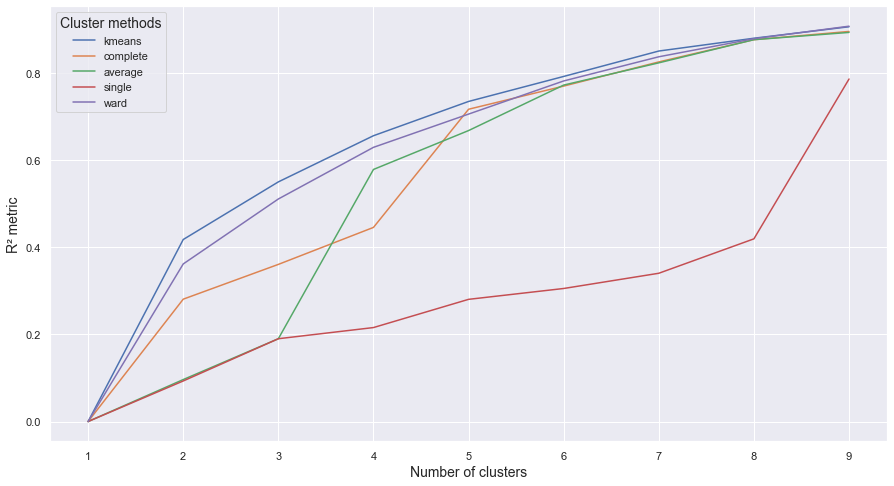

'R² plot for various clustering methods'

In [189]:
check_clustering_methods(data_to_cluster)


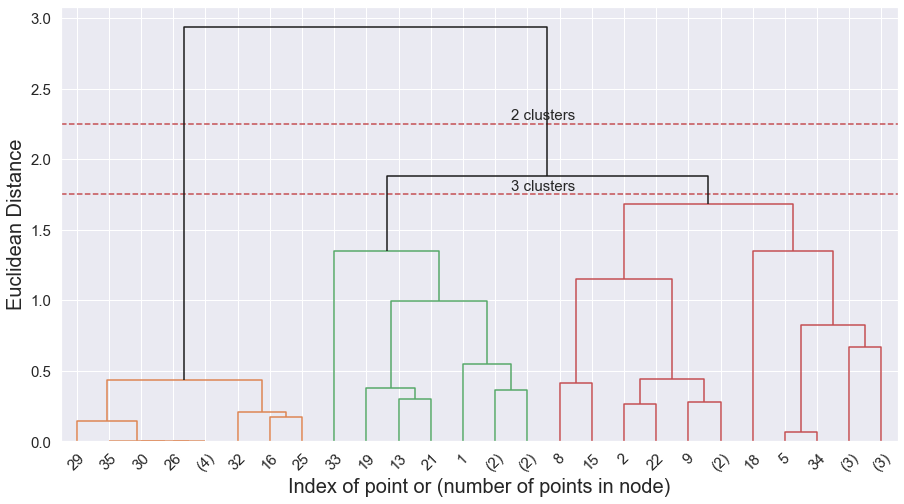

"Dendrogram - Hierarchical Clustering using Ward's linkage"

In [190]:
agglom_clustering_full(data_to_cluster, y_threshold_1 = 2.25, y_threshold_2 = 1.75)


#### Find 2 clusters

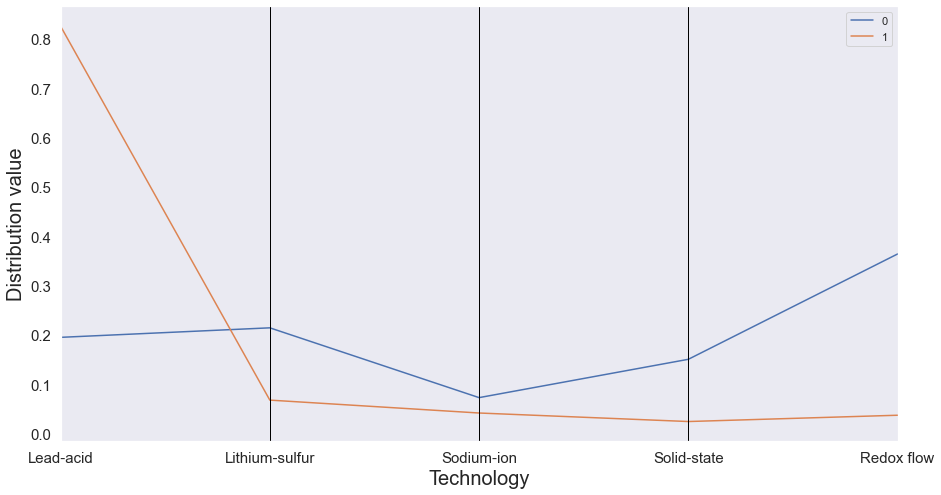

Cluster profiles


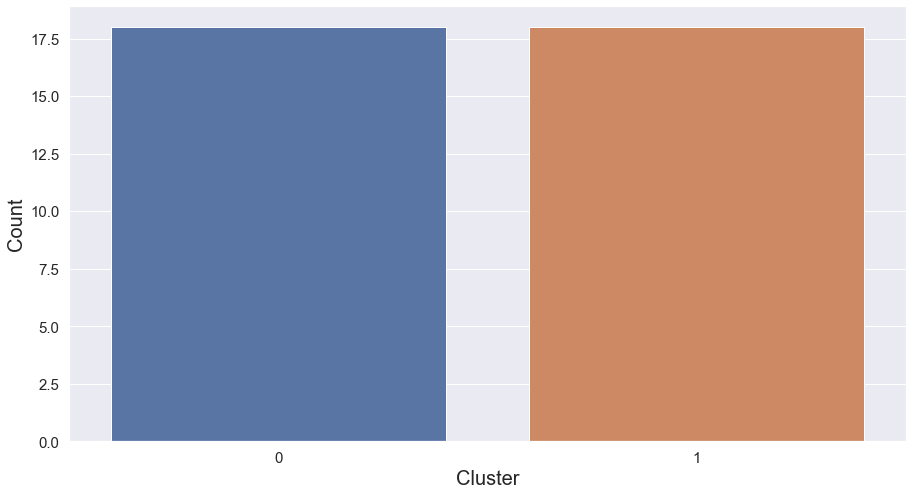

Counts per cluster


In [191]:
result_normalised_2010_2019_k_2, result_absolute_2010_2019_k_2 = run_k_means(data_to_cluster, data_normalised, data_absolute, False, n_clusters=2)

result_normalised = result_normalised_2010_2019_k_2
result_absolute = result_absolute_2010_2019_k_2

show_cluster_profiles(result_normalised)

plot_cluster_counts(result_normalised)


In [192]:
if False:
    
    result_normalised_2010_2019_h_2, result_absolute_2010_2019_h_2 = run_agglomerative(data_to_cluster, data_normalised, data_absolute, n_clusters=2)

    result_normalised = result_normalised_2010_2019_h_2
    result_absolute = result_absolute_2010_2019_h_2

    show_cluster_profiles(result_normalised)

    plot_cluster_counts(result_normalised)


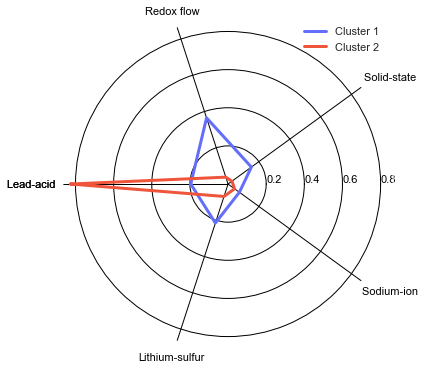

Clustering inventors' countries of origin by their
battery type distribution using recent ten years' data:
Profiles of three clusters computed by k-means algorithm


In [193]:
centroids_2, radar_2 = cluster_profiles_radar(
    result_normalised,
    "Clustering inventors' countries of origin by their\nbattery type distribution using recent ten years' data:\nProfiles of three clusters computed by k-means algorithm",
    (0.7, 0.87), # legend_pos
    40, # title_pad
    [0.2, 0.4, 0.6, 0.8], # y_ticks
    False,
    True,
    'major',
    'both',
    'black',
    '-',
    1
)


In [194]:
centroids_2


{0: [0.19568359284633774,
  0.21497155158448567,
  0.07355129046405551,
  0.15119486902910168,
  0.36459869607601947,
  0.19568359284633774],
 1: [0.8261281649338021,
  0.06851200706763982,
  0.042377378633309544,
  0.025110207253760883,
  0.037872242111487556,
  0.8261281649338021]}

In [195]:
show_result(0)


18
['Japan', 'USA', 'South Korea', 'China', 'Germany', 'UK', 'France', 'Canada', 'Italy', 'Taiwan', 'Belgium', 'Austria', 'Netherlands', 'Spain', 'Australia', 'Thailand', 'Switzerland', 'Hong Kong']


Lead-acid  Lithium-sulfur  Sodium-ion  Solid-state  Redox flow  label
JP  191.699026       40.047701   87.932143   434.247368  216.770263      0
US  136.911719       61.510281   22.516071    61.228175  208.145884      0
KR   19.000000      110.203530   28.179762    67.334774  149.934774      0
CN   59.266667       79.015868   29.627381    16.881548   59.923486      0
DE   28.391958       50.482900    2.291667    18.250000   58.630592      0
GB    4.771251       20.436869   10.958333     4.732143   16.289683      0
FR    7.696154       18.472222    8.767532     7.486111    6.615079      0
CA    6.692857        5.283333    4.928571     0.777778    5.983987      0
IT   10.250000        2.771429    0.000000     0.750000    6.854545      0
TW    4.500000        1.555556    0.750000     3.229167    9.000000      0
BE    1.000000        0.000000    0.000000    15.476190    0.000000      0
AT    2.000000        0.916667    0.000000     1.000000    9.948413      0
NL    6.000000        0.000000    0.000000     1.571429    5.493590      0
ES    1.750000        3.000000    2.818182     0.000000    2.357143      0
AU    3.179545        1.500000    0.000000     0.000000    2.000000      0
TH    0.000000        0.000000    0.000000     0.000000    6.500000      0
CH    0.000000        0.000000    0.416667     1.000000    4.166667      0
HK    0.000000        0.500000    0.000000     0.000000    0.000000      0

In [196]:
show_result(1)


18
['India', 'Israel', 'Russia', 'Turkey', 'Bulgaria', 'New Zealand', 'Luxembourg', 'Poland', 'Sweden', 'Malta', 'Mexico', 'North Korea', 'Kazakhstan', 'Norway', 'Hungary', 'Ukraine', 'Serbia', 'Greece']


Lead-acid  Lithium-sulfur  Sodium-ion  Solid-state  Redox flow  label
IN  10.522233        0.944444    0.830357     1.531746    0.815657      1
IL   4.250000        0.600000    0.750000     1.000000    1.000000      1
RU   5.000000        0.281385    0.000000     0.625000    0.976190      1
TR   5.000000        0.125000    0.500000     0.000000    1.125000      1
BG   5.571429        0.000000    0.000000     0.000000    0.000000      1
NZ   5.000000        0.000000    0.000000     0.000000    0.000000      1
LU   3.666667        0.000000    0.000000     0.000000    0.000000      1
PL   3.250000        0.266667    0.000000     0.000000    0.000000      1
SE   3.000000        0.000000    0.000000     0.000000    0.000000      1
MT   1.300000        0.000000    0.000000     0.000000    0.000000      1
MX   1.059524        0.000000    0.000000     0.000000    0.166667      1
KP   1.000000        0.000000    0.000000     0.142857    0.000000      1
KZ   0.500000        0.500000    0.000000     0.000000    0.000000      1
NO   0.625000        0.000000    0.166667     0.000000    0.041667      1
HU   0.300000        0.250000    0.000000     0.000000    0.000000      1
UA   0.250000        0.000000    0.125000     0.000000    0.000000      1
RS   0.202381        0.000000    0.000000     0.000000    0.000000      1
GR   0.143590        0.000000    0.000000     0.000000    0.000000      1

#### Find 3 clusters

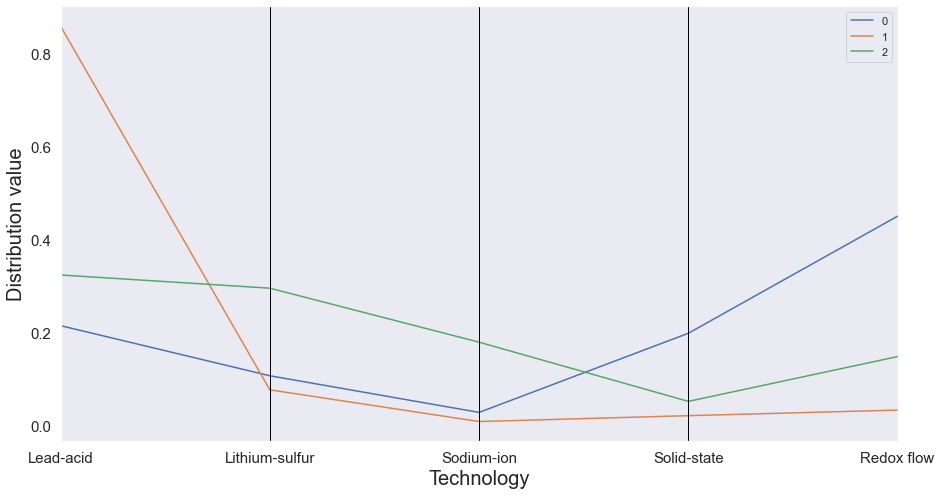

Cluster profiles


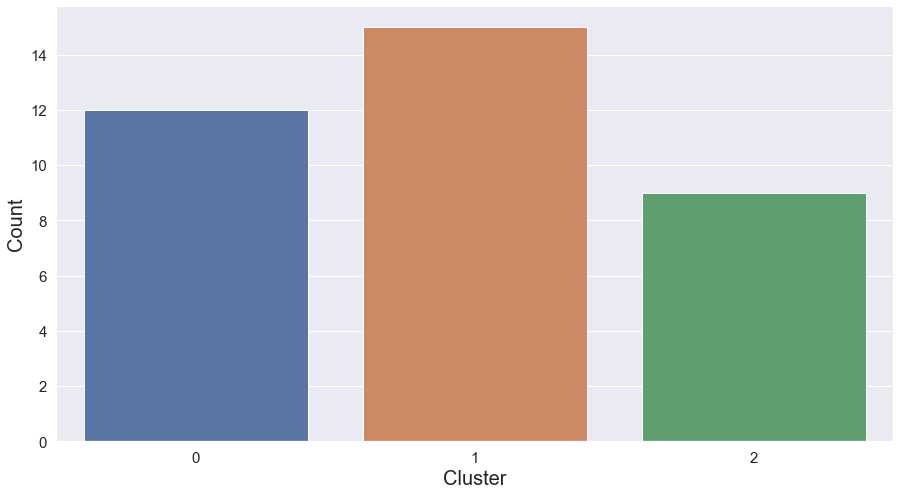

Counts per cluster


In [197]:
result_normalised_2010_2019_k_3, result_absolute_2010_2019_k_3 = run_k_means(data_to_cluster, data_normalised, data_absolute, False, n_clusters=3)

result_normalised = result_normalised_2010_2019_k_3
result_absolute = result_absolute_2010_2019_k_3

show_cluster_profiles(result_normalised)

plot_cluster_counts(result_normalised)


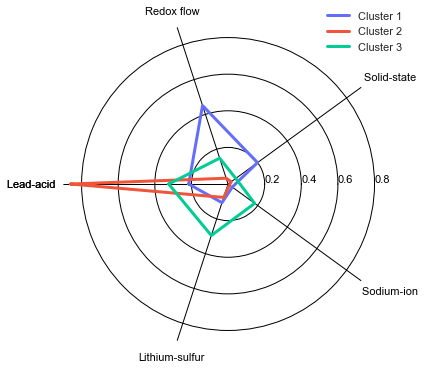

Clustering inventors' countries of origin by their
battery type distribution using recent ten years' data:
Profiles of three clusters computed by k-means algorithm


In [198]:
centroids_3, radar_3 = cluster_profiles_radar(
    result_normalised,
    "Clustering inventors' countries of origin by their\nbattery type distribution using recent ten years' data:\nProfiles of three clusters computed by k-means algorithm",
    (0.77, 0.87), # legend_pos
    40, # title_pad
    [0.2, 0.4, 0.6, 0.8], # y_ticks
    True,
    True,
    'major',
    'both',
    'black',
    '-',
    1
)


##### Run k-means n times in order to compute affiliations distributions

In [199]:
check = data_absolute.copy()
check['sum'] = check.sum(axis = 1)
check.sort_values('sum', ascending = False, inplace = True)
countries_descending = list(check.index)
sums = list(check['sum'])
#countries_descending


In [200]:
sum_dict = {}

for i in range(len(check)):
    
    sum_dict[countries_descending[i]] = sums[i]
    
#sum_dict


In [201]:
# We need to find three countries that are always (or almost always) in three different clusters.
# These three countries can be used as handles for assessing each countries probability to belong to their cluster.

# Define how many times to run k-means
n = 10000

# Sometimes triples that are always in three different clusters can't be found. In that case, repeat.
repeat = True
while repeat:

    clusterings = []

    for i in tqdm(range(n)):

        run_multiple_k_means_normalised, run_multiple_k_means_absolute = run_k_means(data_to_cluster, data_normalised, data_absolute, True, n_clusters=3)

        clustering = []
        for cluster in set(run_multiple_k_means_normalised['label']):

            index = set(run_multiple_k_means_normalised[run_multiple_k_means_normalised['label'] == cluster].index)
            clustering.append(index)

        clusterings.append(clustering)

    #clusterings

    #####
    #####

    # Get all co-occurrences
    co_occurrences = set()

    for clustering in clusterings:

        for cluster in clustering:

            for pair in it.product(cluster, cluster, repeat = 1):

                if pair[0] != pair[1]:

                    co_occurrences.add(pair)

    print('Number of co-occurrences:')
    print(len(co_occurrences))

    #####
    #####

    # Get all theoretically possible triples

    all_countries = set(run_multiple_k_means_normalised.index)

    possible_triples = set()

    for triple in it.product(all_countries, all_countries, all_countries, repeat = 1):

        if (triple[0] != triple[1]) & (triple[0] != triple[2]) & (triple[1] != triple[2]):

            possible_triples.add(triple)

    possible_triples = list(possible_triples)

    print('Number of possible triples:')
    print(len(possible_triples))

    #####
    #####

    # Get triples of countries that are always in their own separate cluster - these are triples that can be used as handles

    never_occur_together = set()

    for triple in possible_triples:

        pairs = []
        for pair in it.product(triple, triple, repeat = 1):

            if (pair[0] != pair[1]):
                pairs.append(pair)

        co_occurred = False
        for pair in pairs:

            if pair in co_occurrences:
                co_occurred = True

        if not co_occurred:
            never_occur_together.add(triple)

    print('Number of triples that never share clusters:')
    print(len(never_occur_together))
    #never_occur_together

    if len(never_occur_together) > 0:
        repeat = False
    else:
        print('No suitable triple found. Repeating.')
        print()
    

  0%|          | 0/10000 [00:00<?, ?it/s]

Number of co-occurrences:
774
Number of possible triples:
42840
Number of triples that never share clusters:
1092


In [202]:
# Get the first element of never_occur_together. Any triple from never_occur_together can be used as handles.

for country in list(never_occur_together)[0]:
    
    if country in country_labels_dict:
        print(country, country_labels_dict[country])
    else:
        print(country, ctry_code_name_dict[country])
        
print(list(never_occur_together)[0])


TR Turkey
ES Spain
DE Germany
('TR', 'ES', 'DE')


##### Get countries that are always together

In [203]:
# Define handles - can use any triple that resulted from cell above
handles = ['TH', 'KP', 'CA']

n_before = len(run_multiple_k_means_normalised)
print(n_before)

neighbors = []

for i, clustering in enumerate(clusterings):
    
    for j, handle in enumerate(handles):
        
        for cluster in clustering:
                        
            if handle in cluster:
                
                if i == 0:

                    neighbors.append(cluster)

                else:
                    
                    neighbors[j] = neighbors[j].intersection(cluster)

n_after = 0

for neighborhood in neighbors:
    
    n_after += len(neighborhood)

print(n_after)

36
22


In [204]:
# Sort neighbors in descending according to their total count in these categories

neighbors_descending = [[], [], []]

for i, neighborhood in enumerate(neighbors):
    
    for country in countries_descending:
        
        if country in neighborhood:
            
            if country in country_labels_dict:
                neighbors_descending[i].append(country_labels_dict[country])
            else:
                neighbors_descending[i].append(ctry_code_name_dict[country])

neighbors_descending


[['USA',
  'Germany',
  'Taiwan',
  'Austria',
  'Netherlands',
  'Thailand',
  'Switzerland'],
 ['India',
  'Russia',
  'Turkey',
  'Bulgaria',
  'New Zealand',
  'Luxembourg',
  'Poland',
  'Sweden',
  'Malta',
  'Mexico',
  'North Korea',
  'Serbia',
  'Greece'],
 ['Canada', 'Spain']]

In [205]:
for neighborhood in neighbors_descending:
    
    print(', '.join(neighborhood)+' ('+str(len(neighborhood))+' countries).')
    print()
        

USA, Germany, Taiwan, Austria, Netherlands, Thailand, Switzerland (7 countries).

India, Russia, Turkey, Bulgaria, New Zealand, Luxembourg, Poland, Sweden, Malta, Mexico, North Korea, Serbia, Greece (13 countries).

Canada, Spain (2 countries).



##### Compute each country's cluster affiliation distribution and build most probable clusters

In [206]:
handles

['TH', 'KP', 'CA']

In [207]:
counters = {}

print(handles)

for i, country in enumerate(all_countries):
    
    counter = {}
    for handle in handles:
        counter[handle] = 0
    
    for clustering in clusterings:
        
        for cluster in clustering:
            
            if country in cluster:
                
                for handle in handles:
                    
                    if handle in cluster:
                        
                        counter[handle] += 1
                        
    counters[country] = counter

distributions = {}
for country in list(counters):
    
    distributions[country] = []
    
for country in list(counters):
    
    for count in list(counters[country]):
                
        distributions[country].append(counters[country][count] / n)
    
handles_distributions = np.eye(3).tolist()

for i, handle in enumerate(handles):
    distributions[handle] = handles_distributions[i]
    
distributions


['TH', 'KP', 'CA']


{'TR': [0.0, 1.0, 0.0],
 'KZ': [0.0215, 0.9283, 0.0502],
 'CA': [0.0, 0.0, 1.0],
 'FR': [0.0018, 0.0, 0.9982],
 'MT': [0.0, 1.0, 0.0],
 'IN': [0.0, 1.0, 0.0],
 'KP': [0.0, 1.0, 0.0],
 'RU': [0.0, 1.0, 0.0],
 'NL': [1.0, 0.0, 0.0],
 'CN': [0.0416, 0.0, 0.9584],
 'JP': [0.9979, 0.0, 0.0021],
 'TH': [1.0, 0.0, 0.0],
 'ES': [0.0, 0.0, 1.0],
 'NZ': [0.0, 1.0, 0.0],
 'GB': [0.0018, 0.0, 0.9982],
 'LU': [0.0, 1.0, 0.0],
 'RS': [0.0, 1.0, 0.0],
 'UA': [0.0, 0.0016, 0.9984],
 'BG': [0.0, 1.0, 0.0],
 'KR': [0.9981, 0.0, 0.0019],
 'CH': [1.0, 0.0, 0.0],
 'PL': [0.0, 1.0, 0.0],
 'NO': [0.0, 0.8809, 0.1191],
 'AT': [1.0, 0.0, 0.0],
 'MX': [0.0, 1.0, 0.0],
 'SE': [0.0, 1.0, 0.0],
 'DE': [1.0, 0.0, 0.0],
 'TW': [1.0, 0.0, 0.0],
 'IT': [0.8724, 0.1276, 0.0],
 'AU': [0.8724, 0.1276, 0.0],
 'HK': [0.1309, 0.0, 0.8691],
 'US': [1.0, 0.0, 0.0],
 'BE': [0.9979, 0.0, 0.0021],
 'HU': [0.0141, 0.9574, 0.0285],
 'IL': [0.0044, 0.9046, 0.091],
 'GR': [0.0, 1.0, 0.0]}

In [208]:
# Check if there are any leveled distributions (two values the same)

for country in list(distributions):
    
    distribution = distributions[country]
    
    for i,v1 in enumerate(distribution):
        for j,v2 in enumerate(distribution):
            if (i!=j) & (v1==v2) & ((v1!=0) & (v2!=0)):
                print(v1, v2)
                

In [209]:
most_prob_clusters = []
for i in range(len(handles)):
    most_prob_clusters.append([])
    
for country in list(distributions):
    
    distribution = distributions[country]
    max_ = max(distribution)
    
    max_index = distribution.index(max_)
    
    if country in country_labels_dict:
        country_written = country_labels_dict[country]
    else:
        country_written = ctry_code_name_dict[country]
                
    most_prob_clusters[max_index].append((country_written, max_, sum_dict[country]))
    
most_prob_clusters_sorted = []
for most_prob_cluster in most_prob_clusters:
    
    tuples = most_prob_cluster
    tuples = sorted(tuples, key=lambda tup: tup[2], reverse = True)
    tuples = sorted(tuples, key=lambda tup: tup[1], reverse = True)
    most_prob_clusters_sorted.append(tuples)

most_prob_clusters_sorted


[[('USA', 1.0, 490.3121301943671),
  ('Germany', 1.0, 158.0471167721168),
  ('Taiwan', 1.0, 19.03472222222222),
  ('Austria', 1.0, 13.865079365079366),
  ('Netherlands', 1.0, 13.065018315018314),
  ('Thailand', 1.0, 6.5),
  ('Switzerland', 1.0, 5.583333333333332),
  ('South Korea', 0.9981, 374.6528411546106),
  ('Japan', 0.9979, 970.6965014719101),
  ('Belgium', 0.9979, 16.476190476190474),
  ('Italy', 0.8724, 20.625974025974028),
  ('Australia', 0.8724, 6.679545454545456)],
 [('India', 1.0, 14.644437506937505),
  ('Russia', 1.0, 6.882575757575758),
  ('Turkey', 1.0, 6.75),
  ('Bulgaria', 1.0, 5.571428571428571),
  ('New Zealand', 1.0, 5.0),
  ('Luxembourg', 1.0, 3.6666666666666665),
  ('Poland', 1.0, 3.5166666666666666),
  ('Sweden', 1.0, 3.0),
  ('Malta', 1.0, 1.3),
  ('Mexico', 1.0, 1.2261904761904763),
  ('North Korea', 1.0, 1.1428571428571428),
  ('Serbia', 1.0, 0.20238095238095238),
  ('Greece', 1.0, 0.14358974358974358),
  ('Hungary', 0.9574, 0.55),
  ('Kazakhstan', 0.9283, 1.0)

#### Create LaTeX code

In [210]:
latex_code = '\\begin{itemize}'

for i, cluster in enumerate(most_prob_clusters_sorted):
    
    string_ = '\n\item Cluster '+str(i + 1)+' ('+str(len(cluster))+' countries):\n\n'
    
    for j, tuple_ in enumerate(cluster):
                
        prob = tuple_[1]
        
        if prob == 1:
            string_ = string_+'\colorbox{rb100}{\hz '+tuple_[0]+'}'
        elif (prob < 1) & (prob >= 0.95):
            string_ = string_+'\colorbox{rb70}{\hz '+tuple_[0]+'}'
        elif (prob < 0.95) & (prob >= 0.9):
            string_ = string_+'\colorbox{rb30}{\hz '+tuple_[0]+'}'
        elif (prob < 0.9) & (prob >= 0.85):
            string_ = string_+'\colorbox{rb0}{\hz '+tuple_[0]+'}'
        else:
            print('######################')
            print('outside defined ranges')
            print('######################')
            
        
        if j < len(cluster) - 1:
            string_ += ', '
        else:
            string_ += '.'
        
    latex_code += '\n'+string_
                
latex_code += '\n\n\end{itemize}'
print(latex_code)
        

\begin{itemize}

\item Cluster 1 (12 countries):

\colorbox{rb100}{\hz USA}, \colorbox{rb100}{\hz Germany}, \colorbox{rb100}{\hz Taiwan}, \colorbox{rb100}{\hz Austria}, \colorbox{rb100}{\hz Netherlands}, \colorbox{rb100}{\hz Thailand}, \colorbox{rb100}{\hz Switzerland}, \colorbox{rb70}{\hz South Korea}, \colorbox{rb70}{\hz Japan}, \colorbox{rb70}{\hz Belgium}, \colorbox{rb0}{\hz Italy}, \colorbox{rb0}{\hz Australia}.

\item Cluster 2 (17 countries):

\colorbox{rb100}{\hz India}, \colorbox{rb100}{\hz Russia}, \colorbox{rb100}{\hz Turkey}, \colorbox{rb100}{\hz Bulgaria}, \colorbox{rb100}{\hz New Zealand}, \colorbox{rb100}{\hz Luxembourg}, \colorbox{rb100}{\hz Poland}, \colorbox{rb100}{\hz Sweden}, \colorbox{rb100}{\hz Malta}, \colorbox{rb100}{\hz Mexico}, \colorbox{rb100}{\hz North Korea}, \colorbox{rb100}{\hz Serbia}, \colorbox{rb100}{\hz Greece}, \colorbox{rb70}{\hz Hungary}, \colorbox{rb30}{\hz Kazakhstan}, \colorbox{rb30}{\hz Israel}, \colorbox{rb0}{\hz Norway}.

\item Cluster 3 (7 c

In [211]:
if False:
    
    result_normalised_2010_2019_h_3, result_absolute_2010_2019_h_3 = run_agglomerative(data_to_cluster, data_normalised, data_absolute, n_clusters=3)

    result_normalised = result_normalised_2010_2019_h_3
    result_absolute = result_absolute_2010_2019_h_3

    show_cluster_profiles(result_normalised)

    plot_cluster_counts(result_normalised)


In [212]:
show_result(0)


12
['Japan', 'USA', 'South Korea', 'Germany', 'Italy', 'Taiwan', 'Belgium', 'Austria', 'Netherlands', 'Australia', 'Thailand', 'Switzerland']


Lead-acid  Lithium-sulfur  Sodium-ion  Solid-state  Redox flow  label
JP  191.699026       40.047701   87.932143   434.247368  216.770263      0
US  136.911719       61.510281   22.516071    61.228175  208.145884      0
KR   19.000000      110.203530   28.179762    67.334774  149.934774      0
DE   28.391958       50.482900    2.291667    18.250000   58.630592      0
IT   10.250000        2.771429    0.000000     0.750000    6.854545      0
TW    4.500000        1.555556    0.750000     3.229167    9.000000      0
BE    1.000000        0.000000    0.000000    15.476190    0.000000      0
AT    2.000000        0.916667    0.000000     1.000000    9.948413      0
NL    6.000000        0.000000    0.000000     1.571429    5.493590      0
AU    3.179545        1.500000    0.000000     0.000000    2.000000      0
TH    0.000000        0.000000    0.000000     0.000000    6.500000      0
CH    0.000000        0.000000    0.416667     1.000000    4.166667      0

In [213]:
list_ = ['Japan', 'USA', 'South Korea', 'Germany', 'Italy', 'Taiwan', 'Belgium', 'Austria', 'Netherlands', 'Australia', 'Thailand', 'Switzerland']
print(', '.join(list_)+' ('+str(len(list_))+' countries).')


Japan, USA, South Korea, Germany, Italy, Taiwan, Belgium, Austria, Netherlands, Australia, Thailand, Switzerland (12 countries).


In [214]:
show_result(1)


15
['India', 'Russia', 'Turkey', 'Bulgaria', 'New Zealand', 'Luxembourg', 'Poland', 'Sweden', 'Malta', 'Mexico', 'North Korea', 'Kazakhstan', 'Hungary', 'Serbia', 'Greece']


Lead-acid  Lithium-sulfur  Sodium-ion  Solid-state  Redox flow  label
IN  10.522233        0.944444    0.830357     1.531746    0.815657      1
RU   5.000000        0.281385    0.000000     0.625000    0.976190      1
TR   5.000000        0.125000    0.500000     0.000000    1.125000      1
BG   5.571429        0.000000    0.000000     0.000000    0.000000      1
NZ   5.000000        0.000000    0.000000     0.000000    0.000000      1
LU   3.666667        0.000000    0.000000     0.000000    0.000000      1
PL   3.250000        0.266667    0.000000     0.000000    0.000000      1
SE   3.000000        0.000000    0.000000     0.000000    0.000000      1
MT   1.300000        0.000000    0.000000     0.000000    0.000000      1
MX   1.059524        0.000000    0.000000     0.000000    0.166667      1
KP   1.000000        0.000000    0.000000     0.142857    0.000000      1
KZ   0.500000        0.500000    0.000000     0.000000    0.000000      1
HU   0.300000        0.250000    0.000000     0.000000    0.000000      1
RS   0.202381        0.000000    0.000000     0.000000    0.000000      1
GR   0.143590        0.000000    0.000000     0.000000    0.000000      1

In [215]:
list_ = ['India', 'Russia', 'Turkey', 'Bulgaria', 'New Zealand', 'Luxembourg', 'Poland', 'Sweden', 'Malta', 'Mexico', "Democratic People's Republic of Korea", 'Kazakhstan', 'Hungary', 'Serbia', 'Greece']
print(', '.join(list_)+' ('+str(len(list_))+' countries).')


India, Russia, Turkey, Bulgaria, New Zealand, Luxembourg, Poland, Sweden, Malta, Mexico, Democratic People's Republic of Korea, Kazakhstan, Hungary, Serbia, Greece (15 countries).


In [216]:
show_result(2)


9
['China', 'UK', 'France', 'Canada', 'Spain', 'Israel', 'Norway', 'Hong Kong', 'Ukraine']


Lead-acid  Lithium-sulfur  Sodium-ion  Solid-state  Redox flow  label
CN  59.266667       79.015868   29.627381    16.881548   59.923486      2
GB   4.771251       20.436869   10.958333     4.732143   16.289683      2
FR   7.696154       18.472222    8.767532     7.486111    6.615079      2
CA   6.692857        5.283333    4.928571     0.777778    5.983987      2
ES   1.750000        3.000000    2.818182     0.000000    2.357143      2
IL   4.250000        0.600000    0.750000     1.000000    1.000000      2
NO   0.625000        0.000000    0.166667     0.000000    0.041667      2
HK   0.000000        0.500000    0.000000     0.000000    0.000000      2
UA   0.250000        0.000000    0.125000     0.000000    0.000000      2

In [217]:
list_ = ['China', 'UK', 'France', 'Canada', 'Spain', 'Israel', 'Norway', 'Hong Kong SAR (China)', 'Ukraine']
print(', '.join(list_)+' ('+str(len(list_))+' countries).')


China, UK, France, Canada, Spain, Israel, Norway, Hong Kong SAR (China), Ukraine (9 countries).


#### Find 4 clusters

In [218]:
run_k_means


<function __main__.run_k_means(data_to_cluster, data_normalised, data_absolute, random, n_clusters=2)>

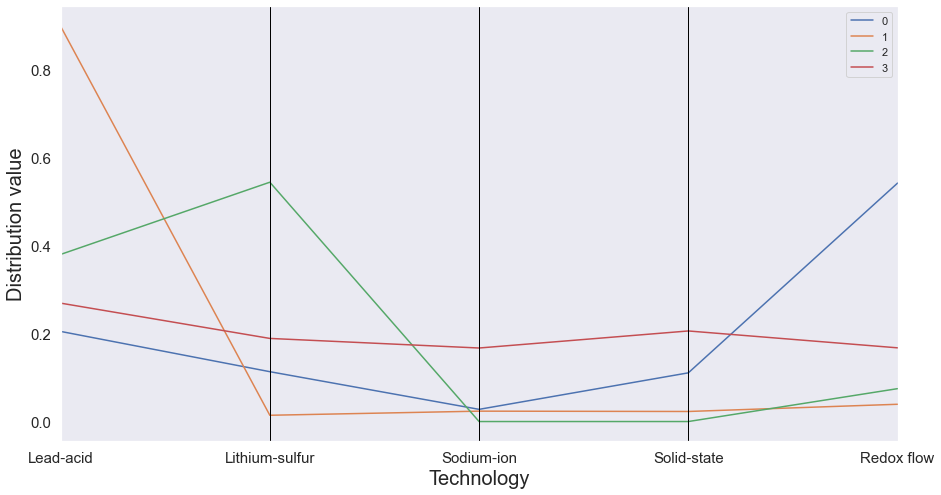

Cluster profiles


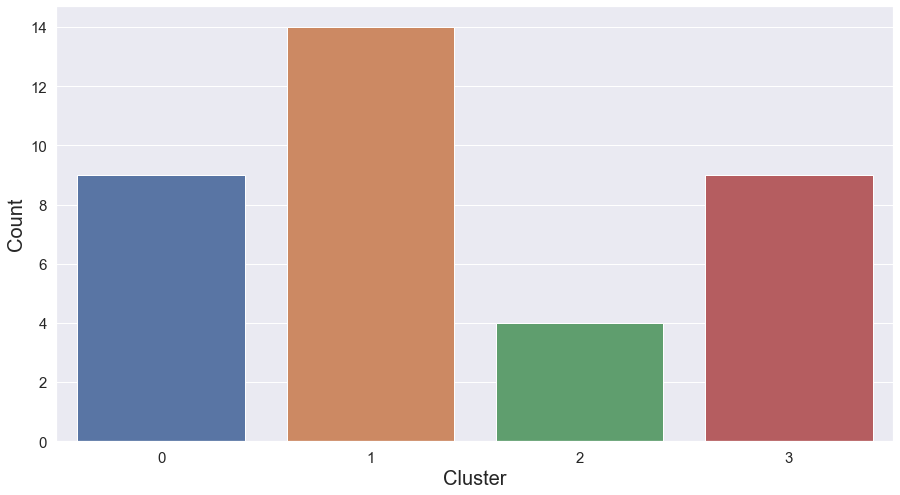

Counts per cluster


In [219]:
result_normalised_2010_2019_k_4, result_absolute_2010_2019_k_4 = run_k_means(
    data_to_cluster, data_normalised, data_absolute, False, n_clusters=4)

result_normalised = result_normalised_2010_2019_k_4
result_absolute = result_absolute_2010_2019_k_4

show_cluster_profiles(result_normalised)

plot_cluster_counts(result_normalised)


In [220]:
if False:
    
    result_normalised_2010_2019_h_4, result_absolute_2010_2019_h_4 = run_agglomerative(
        data_to_cluster, data_normalised, data_absolute, n_clusters=4)

    result_normalised = result_normalised_2010_2019_h_4
    result_absolute = result_absolute_2010_2019_h_4

    show_cluster_profiles(result_normalised)

    plot_cluster_counts(result_normalised)


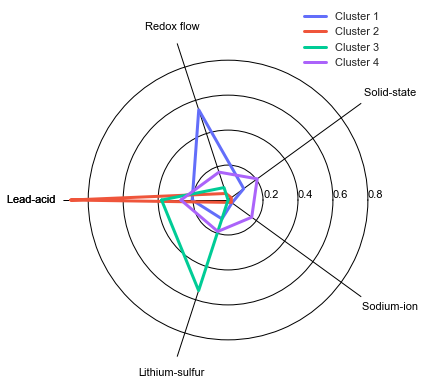

Clustering inventors' countries of origin by their
battery type distribution using recent ten years' data:
Profiles of three clusters computed by k-means algorithm


({0: [0.2051594406444236,
   0.11346863620022675,
   0.027740668488259124,
   0.1108430336939575,
   0.5427882209731331,
   0.2051594406444236],
  1: [0.8999268021693884,
   0.014265950303643558,
   0.023626805109994476,
   0.022886055942805347,
   0.03929438647416821,
   0.8999268021693884],
  2: [0.3803666986297133,
   0.5447779083794735,
   0.0,
   0.0,
   0.07485539299081319,
   0.3803666986297133],
  3: [0.26952607215026825,
   0.18918348801859047,
   0.16736386175759066,
   0.2061665874051815,
   0.16775999066836902,
   0.26952607215026825]},
 <Figure size 432x504 with 1 Axes>)

In [221]:
cluster_profiles_radar(
    result_normalised,
    "Clustering inventors' countries of origin by their\nbattery type distribution using recent ten years' data:\nProfiles of three clusters computed by k-means algorithm",
    (0.7, 0.87), # legend_pos
    40, # title_pad
    [0.2, 0.4, 0.6, 0.8], # y_ticks
    False,
    True,
    'major',
    'both',
    'black',
    '-',
    1
)


In [222]:
show_result(0)


9
['USA', 'South Korea', 'Germany', 'Italy', 'Taiwan', 'Austria', 'Netherlands', 'Thailand', 'Switzerland']


Lead-acid  Lithium-sulfur  Sodium-ion  Solid-state  Redox flow  label
US  136.911719       61.510281   22.516071    61.228175  208.145884      0
KR   19.000000      110.203530   28.179762    67.334774  149.934774      0
DE   28.391958       50.482900    2.291667    18.250000   58.630592      0
IT   10.250000        2.771429    0.000000     0.750000    6.854545      0
TW    4.500000        1.555556    0.750000     3.229167    9.000000      0
AT    2.000000        0.916667    0.000000     1.000000    9.948413      0
NL    6.000000        0.000000    0.000000     1.571429    5.493590      0
TH    0.000000        0.000000    0.000000     0.000000    6.500000      0
CH    0.000000        0.000000    0.416667     1.000000    4.166667      0

In [223]:
show_result(1)


14
['India', 'Russia', 'Turkey', 'Bulgaria', 'New Zealand', 'Luxembourg', 'Poland', 'Sweden', 'Malta', 'Mexico', 'North Korea', 'Norway', 'Serbia', 'Greece']


Lead-acid  Lithium-sulfur  Sodium-ion  Solid-state  Redox flow  label
IN  10.522233        0.944444    0.830357     1.531746    0.815657      1
RU   5.000000        0.281385    0.000000     0.625000    0.976190      1
TR   5.000000        0.125000    0.500000     0.000000    1.125000      1
BG   5.571429        0.000000    0.000000     0.000000    0.000000      1
NZ   5.000000        0.000000    0.000000     0.000000    0.000000      1
LU   3.666667        0.000000    0.000000     0.000000    0.000000      1
PL   3.250000        0.266667    0.000000     0.000000    0.000000      1
SE   3.000000        0.000000    0.000000     0.000000    0.000000      1
MT   1.300000        0.000000    0.000000     0.000000    0.000000      1
MX   1.059524        0.000000    0.000000     0.000000    0.166667      1
KP   1.000000        0.000000    0.000000     0.142857    0.000000      1
NO   0.625000        0.000000    0.166667     0.000000    0.041667      1
RS   0.202381        0.000000    0.000000     0.000000    0.000000      1
GR   0.143590        0.000000    0.000000     0.000000    0.000000      1

In [224]:
show_result(2)


4
['Australia', 'Kazakhstan', 'Hungary', 'Hong Kong']


Lead-acid  Lithium-sulfur  Sodium-ion  Solid-state  Redox flow  label
AU   3.179545            1.50         0.0          0.0         2.0      2
KZ   0.500000            0.50         0.0          0.0         0.0      2
HU   0.300000            0.25         0.0          0.0         0.0      2
HK   0.000000            0.50         0.0          0.0         0.0      2

In [225]:
show_result(3)


9
['Japan', 'China', 'UK', 'France', 'Canada', 'Belgium', 'Spain', 'Israel', 'Ukraine']


Lead-acid  Lithium-sulfur  Sodium-ion  Solid-state  Redox flow  label
JP  191.699026       40.047701   87.932143   434.247368  216.770263      3
CN   59.266667       79.015868   29.627381    16.881548   59.923486      3
GB    4.771251       20.436869   10.958333     4.732143   16.289683      3
FR    7.696154       18.472222    8.767532     7.486111    6.615079      3
CA    6.692857        5.283333    4.928571     0.777778    5.983987      3
BE    1.000000        0.000000    0.000000    15.476190    0.000000      3
ES    1.750000        3.000000    2.818182     0.000000    2.357143      3
IL    4.250000        0.600000    0.750000     1.000000    1.000000      3
UA    0.250000        0.000000    0.125000     0.000000    0.000000      3

#### Find 5 clusters

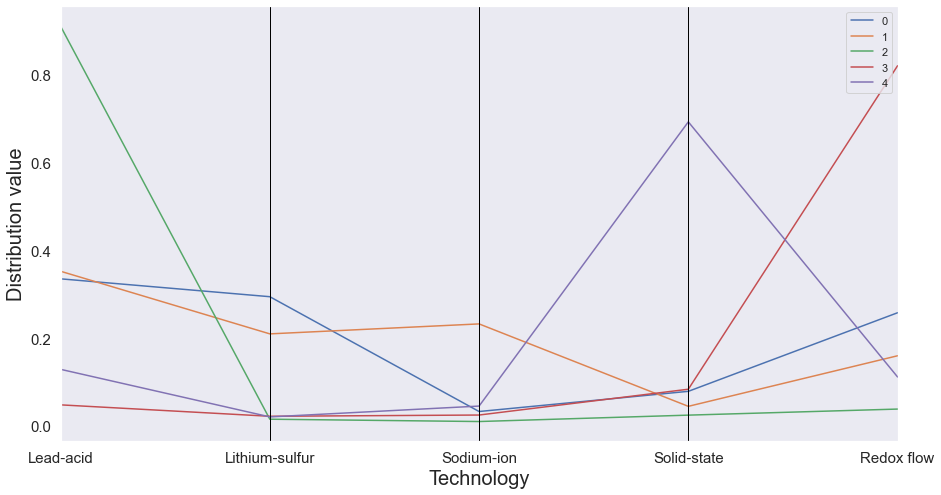

Cluster profiles


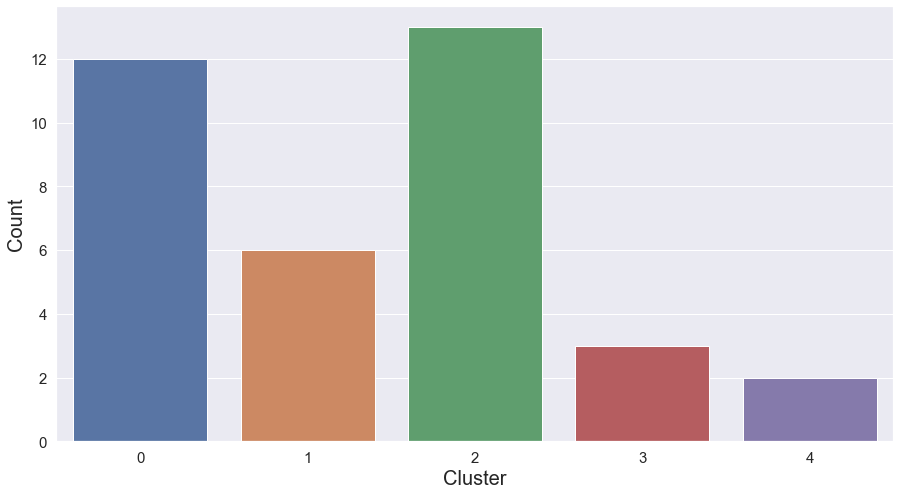

Counts per cluster


In [226]:
result_normalised_2010_2019_k_5, result_absolute_2010_2019_k_5 = run_k_means(
    data_to_cluster, data_normalised, data_absolute, False, n_clusters=5)

result_normalised = result_normalised_2010_2019_k_5
result_absolute = result_absolute_2010_2019_k_5

show_cluster_profiles(result_normalised)

plot_cluster_counts(result_normalised)


In [227]:
if False:
    
    result_normalised_2010_2019_h_5, result_absolute_2010_2019_h_5 = run_agglomerative(
        data_to_cluster, data_normalised, data_absolute, n_clusters=5)

    result_normalised = result_normalised_2010_2019_h_5
    result_absolute = result_absolute_2010_2019_h_5

    show_cluster_profiles(result_normalised)

    plot_cluster_counts(result_normalised)


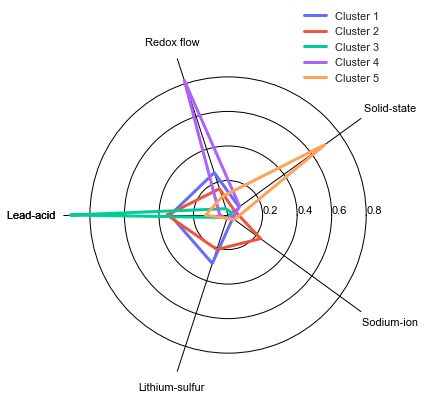

Clustering inventors' countries of origin by their
battery type distribution using recent ten years' data:
Profiles of three clusters computed by k-means algorithm


({0: [0.3354209620679915,
   0.29467106754915784,
   0.032899358927824716,
   0.07891022250585307,
   0.25809838894917286,
   0.3354209620679915],
  1: [0.352692980631319,
   0.20992632299218972,
   0.2326558251377707,
   0.04471216082946123,
   0.16001271040925943,
   0.352692980631319],
  2: [0.9114596331054952,
   0.015363331096231524,
   0.010059636272301744,
   0.024646521784559602,
   0.03847087774141192,
   0.9114596331054952],
  3: [0.048082427017744706,
   0.022037779049799654,
   0.024875621890547265,
   0.08374270604618579,
   0.8212614659957226,
   0.048082427017744706],
  4: [0.12908985000701748,
   0.020628332897408813,
   0.04529332429024284,
   0.6933314183533447,
   0.11165707445198618,
   0.12908985000701748]},
 <Figure size 432x504 with 1 Axes>)

In [228]:
cluster_profiles_radar(
    result_normalised,
    "Clustering inventors' countries of origin by their\nbattery type distribution using recent ten years' data:\nProfiles of three clusters computed by k-means algorithm",
    (0.7, 0.87), # legend_pos
    40, # title_pad
    [0.2, 0.4, 0.6, 0.8], # y_ticks
    False,
    True,
    'major',
    'both',
    'black',
    '-',
    1
)


In [229]:
show_result(0)


12
['USA', 'South Korea', 'China', 'Germany', 'Italy', 'Taiwan', 'Netherlands', 'Israel', 'Australia', 'Kazakhstan', 'Hungary', 'Hong Kong']


Lead-acid  Lithium-sulfur  Sodium-ion  Solid-state  Redox flow  label
US  136.911719       61.510281   22.516071    61.228175  208.145884      0
KR   19.000000      110.203530   28.179762    67.334774  149.934774      0
CN   59.266667       79.015868   29.627381    16.881548   59.923486      0
DE   28.391958       50.482900    2.291667    18.250000   58.630592      0
IT   10.250000        2.771429    0.000000     0.750000    6.854545      0
TW    4.500000        1.555556    0.750000     3.229167    9.000000      0
NL    6.000000        0.000000    0.000000     1.571429    5.493590      0
IL    4.250000        0.600000    0.750000     1.000000    1.000000      0
AU    3.179545        1.500000    0.000000     0.000000    2.000000      0
KZ    0.500000        0.500000    0.000000     0.000000    0.000000      0
HU    0.300000        0.250000    0.000000     0.000000    0.000000      0
HK    0.000000        0.500000    0.000000     0.000000    0.000000      0

In [230]:
show_result(1)


6
['UK', 'France', 'Canada', 'Spain', 'Norway', 'Ukraine']


Lead-acid  Lithium-sulfur  Sodium-ion  Solid-state  Redox flow  label
GB   4.771251       20.436869   10.958333     4.732143   16.289683      1
FR   7.696154       18.472222    8.767532     7.486111    6.615079      1
CA   6.692857        5.283333    4.928571     0.777778    5.983987      1
ES   1.750000        3.000000    2.818182     0.000000    2.357143      1
NO   0.625000        0.000000    0.166667     0.000000    0.041667      1
UA   0.250000        0.000000    0.125000     0.000000    0.000000      1

In [231]:
show_result(2)


13
['India', 'Russia', 'Turkey', 'Bulgaria', 'New Zealand', 'Luxembourg', 'Poland', 'Sweden', 'Malta', 'Mexico', 'North Korea', 'Serbia', 'Greece']


Lead-acid  Lithium-sulfur  Sodium-ion  Solid-state  Redox flow  label
IN  10.522233        0.944444    0.830357     1.531746    0.815657      2
RU   5.000000        0.281385    0.000000     0.625000    0.976190      2
TR   5.000000        0.125000    0.500000     0.000000    1.125000      2
BG   5.571429        0.000000    0.000000     0.000000    0.000000      2
NZ   5.000000        0.000000    0.000000     0.000000    0.000000      2
LU   3.666667        0.000000    0.000000     0.000000    0.000000      2
PL   3.250000        0.266667    0.000000     0.000000    0.000000      2
SE   3.000000        0.000000    0.000000     0.000000    0.000000      2
MT   1.300000        0.000000    0.000000     0.000000    0.000000      2
MX   1.059524        0.000000    0.000000     0.000000    0.166667      2
KP   1.000000        0.000000    0.000000     0.142857    0.000000      2
RS   0.202381        0.000000    0.000000     0.000000    0.000000      2
GR   0.143590        0.000000    0.000000     0.000000    0.000000      2

In [232]:
show_result(3)


3
['Austria', 'Thailand', 'Switzerland']


Lead-acid  Lithium-sulfur  Sodium-ion  Solid-state  Redox flow  label
AT        2.0        0.916667    0.000000          1.0    9.948413      3
TH        0.0        0.000000    0.000000          0.0    6.500000      3
CH        0.0        0.000000    0.416667          1.0    4.166667      3

In [233]:
show_result(4)


2
['Japan', 'Belgium']


Lead-acid  Lithium-sulfur  Sodium-ion  Solid-state  Redox flow  label
JP  191.699026       40.047701   87.932143   434.247368  216.770263      4
BE    1.000000        0.000000    0.000000    15.476190    0.000000      4

#### Find 6 clusters

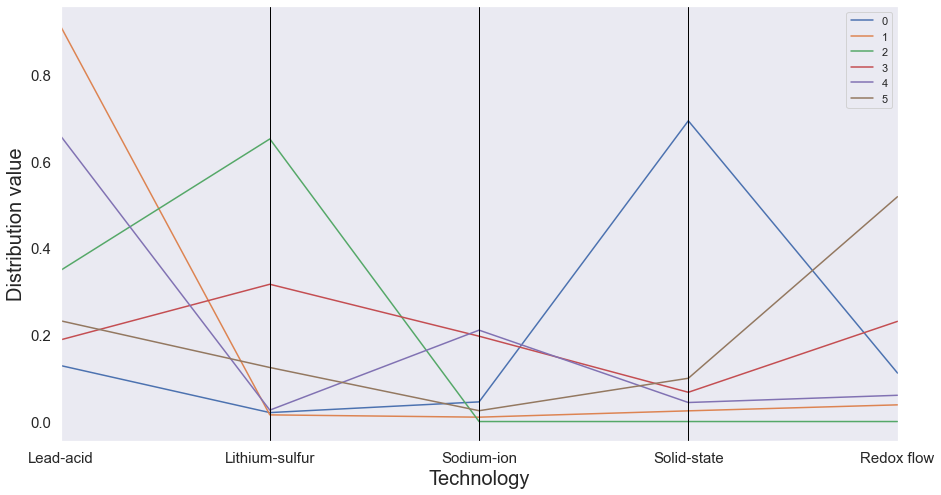

Cluster profiles


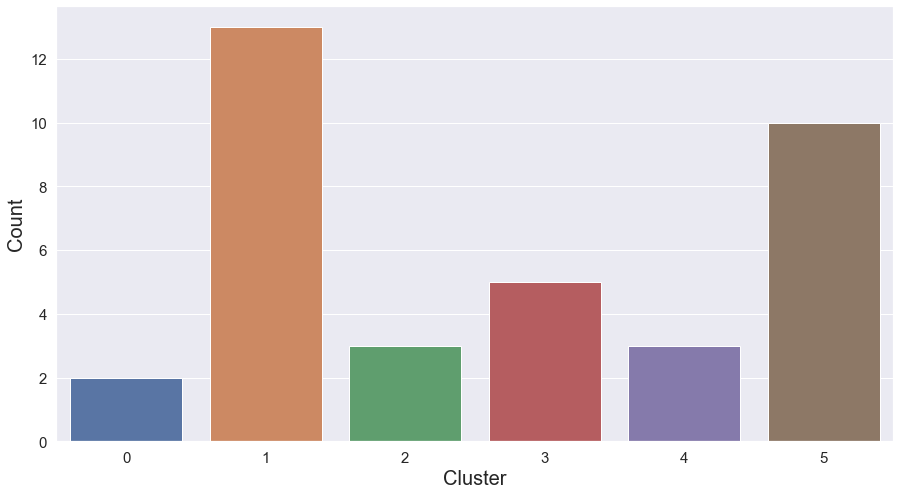

Counts per cluster


In [234]:
result_normalised_2010_2019_k_6, result_absolute_2010_2019_k_6 = run_k_means(
    data_to_cluster, data_normalised, data_absolute, False, n_clusters=6)

result_normalised = result_normalised_2010_2019_k_6
result_absolute = result_absolute_2010_2019_k_6

show_cluster_profiles(result_normalised)

plot_cluster_counts(result_normalised)


In [235]:
if False:
    
    result_normalised_2010_2019_h_6, result_absolute_2010_2019_h_6 = run_agglomerative(
        data_to_cluster, data_normalised, data_absolute, n_clusters=6)

    result_normalised = result_normalised_2010_2019_h_6
    result_absolute = result_absolute_2010_2019_h_6

    show_cluster_profiles(result_normalised)

    plot_cluster_counts(result_normalised)


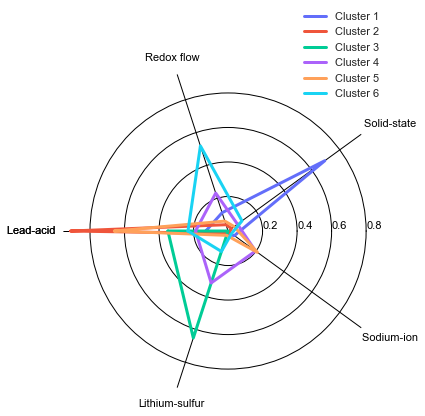

Clustering inventors' countries of origin by their
battery type distribution using recent ten years' data:
Profiles of three clusters computed by k-means algorithm


({0: [0.12908985000701748,
   0.020628332897408813,
   0.04529332429024284,
   0.6933314183533447,
   0.11165707445198618,
   0.12908985000701748],
  1: [0.9114596331054952,
   0.015363331096231524,
   0.010059636272301744,
   0.024646521784559602,
   0.03847087774141192,
   0.9114596331054952],
  2: [0.34848484848484845,
   0.6515151515151515,
   0.0,
   0.0,
   0.0,
   0.34848484848484845],
  3: [0.1883355512711847,
   0.3164894715902888,
   0.19673411267563629,
   0.06745150051430467,
   0.2309893639485856,
   0.1883355512711847],
  4: [0.6586257309941521,
   0.026315789473684213,
   0.21067251461988304,
   0.043859649122807015,
   0.060526315789473685,
   0.6586257309941521],
  5: [0.232244721486412,
   0.12457839047744804,
   0.024966601639433213,
   0.09975873032456176,
   0.518451556072145,
   0.232244721486412]},
 <Figure size 432x504 with 1 Axes>)

In [236]:
cluster_profiles_radar(
    result_normalised,
    "Clustering inventors' countries of origin by their\nbattery type distribution using recent ten years' data:\nProfiles of three clusters computed by k-means algorithm",
    (0.7, 0.87), # legend_pos
    40, # title_pad
    [0.2, 0.4, 0.6, 0.8], # y_ticks
    False,
    True,
    'major',
    'both',
    'black',
    '-',
    1
)


In [237]:
show_result(0)


2
['Japan', 'Belgium']


Lead-acid  Lithium-sulfur  Sodium-ion  Solid-state  Redox flow  label
JP  191.699026       40.047701   87.932143   434.247368  216.770263      0
BE    1.000000        0.000000    0.000000    15.476190    0.000000      0

In [238]:
show_result(1)


13
['India', 'Russia', 'Turkey', 'Bulgaria', 'New Zealand', 'Luxembourg', 'Poland', 'Sweden', 'Malta', 'Mexico', 'North Korea', 'Serbia', 'Greece']


Lead-acid  Lithium-sulfur  Sodium-ion  Solid-state  Redox flow  label
IN  10.522233        0.944444    0.830357     1.531746    0.815657      1
RU   5.000000        0.281385    0.000000     0.625000    0.976190      1
TR   5.000000        0.125000    0.500000     0.000000    1.125000      1
BG   5.571429        0.000000    0.000000     0.000000    0.000000      1
NZ   5.000000        0.000000    0.000000     0.000000    0.000000      1
LU   3.666667        0.000000    0.000000     0.000000    0.000000      1
PL   3.250000        0.266667    0.000000     0.000000    0.000000      1
SE   3.000000        0.000000    0.000000     0.000000    0.000000      1
MT   1.300000        0.000000    0.000000     0.000000    0.000000      1
MX   1.059524        0.000000    0.000000     0.000000    0.166667      1
KP   1.000000        0.000000    0.000000     0.142857    0.000000      1
RS   0.202381        0.000000    0.000000     0.000000    0.000000      1
GR   0.143590        0.000000    0.000000     0.000000    0.000000      1

In [239]:
show_result(2)


3
['Kazakhstan', 'Hungary', 'Hong Kong']


Lead-acid  Lithium-sulfur  Sodium-ion  Solid-state  Redox flow  label
KZ        0.5            0.50         0.0          0.0         0.0      2
HU        0.3            0.25         0.0          0.0         0.0      2
HK        0.0            0.50         0.0          0.0         0.0      2

In [240]:
show_result(3)


5
['China', 'UK', 'France', 'Canada', 'Spain']


Lead-acid  Lithium-sulfur  Sodium-ion  Solid-state  Redox flow  label
CN  59.266667       79.015868   29.627381    16.881548   59.923486      3
GB   4.771251       20.436869   10.958333     4.732143   16.289683      3
FR   7.696154       18.472222    8.767532     7.486111    6.615079      3
CA   6.692857        5.283333    4.928571     0.777778    5.983987      3
ES   1.750000        3.000000    2.818182     0.000000    2.357143      3

In [241]:
show_result(4)


3
['Israel', 'Norway', 'Ukraine']


Lead-acid  Lithium-sulfur  Sodium-ion  Solid-state  Redox flow  label
IL      4.250             0.6    0.750000          1.0    1.000000      4
NO      0.625             0.0    0.166667          0.0    0.041667      4
UA      0.250             0.0    0.125000          0.0    0.000000      4

In [242]:
show_result(5)


10
['USA', 'South Korea', 'Germany', 'Italy', 'Taiwan', 'Austria', 'Netherlands', 'Australia', 'Thailand', 'Switzerland']


Lead-acid  Lithium-sulfur  Sodium-ion  Solid-state  Redox flow  label
US  136.911719       61.510281   22.516071    61.228175  208.145884      5
KR   19.000000      110.203530   28.179762    67.334774  149.934774      5
DE   28.391958       50.482900    2.291667    18.250000   58.630592      5
IT   10.250000        2.771429    0.000000     0.750000    6.854545      5
TW    4.500000        1.555556    0.750000     3.229167    9.000000      5
AT    2.000000        0.916667    0.000000     1.000000    9.948413      5
NL    6.000000        0.000000    0.000000     1.571429    5.493590      5
AU    3.179545        1.500000    0.000000     0.000000    2.000000      5
TH    0.000000        0.000000    0.000000     0.000000    6.500000      5
CH    0.000000        0.000000    0.416667     1.000000    4.166667      5

### 2000-2009 and 2010-2019

In [243]:
time_periods_list = [[2000,2009], [2010,2019]]

time_periods_list


[[2000, 2009], [2010, 2019]]

In [244]:
tech_dist_dfs_absolute_list_2000_2010_2019 = get_tech_dist_dfs_absolute_list(time_periods_list, dfs_technologies_list)
#tech_dist_dfs_absolute_list_2000_2010_2019[0]


In [245]:
#len(tech_dist_dfs_absolute_list_2000_2010_2019[1])
len(tech_dist_dfs_absolute_list_2000_2010_2019[0])


42

In [246]:
tech_dist_dfs_normalised_list_2000_2010_2019 = get_tech_dist_dfs_normalised_list(
    tech_dist_dfs_absolute_list_2000_2010_2019
)
#tech_dist_dfs_normalised_list_2000_2010_2019[0]


In [247]:
#len(tech_dist_dfs_normalised_list_2000_2010_2019[1])
len(tech_dist_dfs_normalised_list_2000_2010_2019[0])


30

In [248]:
tech_dist_dfs_normalised_scaled_list_2000_2010_2019 = get_tech_dist_dfs_normalised_scaled_list(
    tech_dist_dfs_normalised_list_2000_2010_2019
)
#tech_dist_dfs_normalised_scaled_list_2000_2010_2019[0]


In [249]:
if False:
    
    print(list(tech_dist_dfs_absolute_list_2000_2010_2019[0].index) == list(tech_dist_dfs_absolute_list_2000_2010_2019[1].index))

    print(list(tech_dist_dfs_normalised_list_2000_2010_2019[0].index) == list(tech_dist_dfs_normalised_list_2000_2010_2019[1].index))

    print(list(tech_dist_dfs_normalised_scaled_list_2000_2010_2019[0].index) == list(tech_dist_dfs_normalised_scaled_list_2000_2010_2019[1].index))


#### 2000-2009

In [250]:
data_absolute, data_normalised, data_to_cluster = get_dataframes(0,
                                                                tech_dist_dfs_absolute_list_2000_2010_2019,
                                                                tech_dist_dfs_normalised_list_2000_2010_2019,
                                                                tech_dist_dfs_normalised_scaled_list_2000_2010_2019)


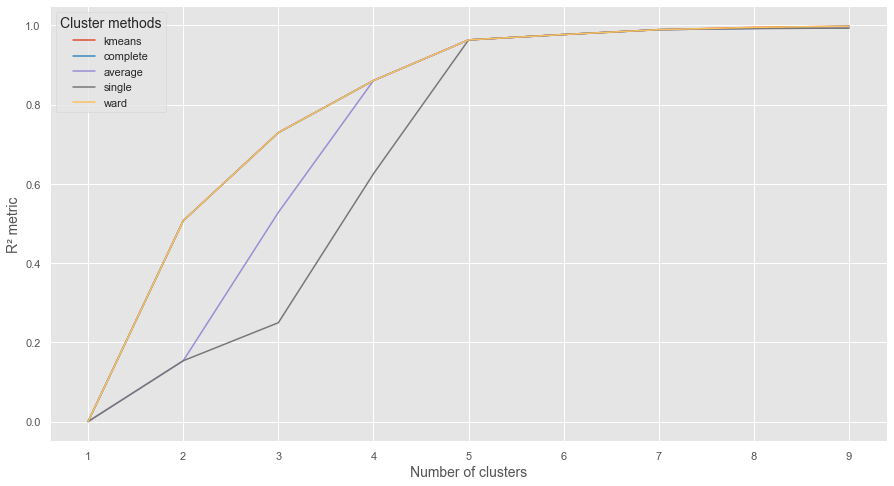

'R² plot for various clustering methods'

In [251]:
check_clustering_methods(data_to_cluster)


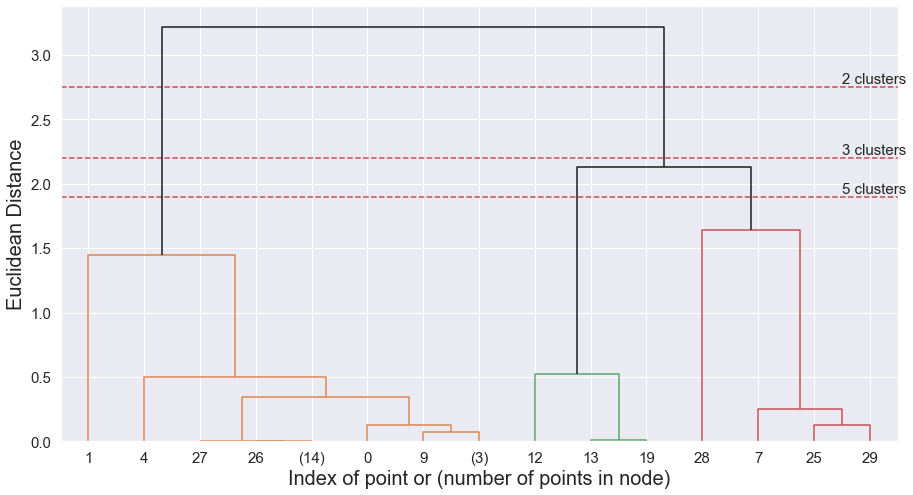

"Dendrogram - Hierarchical Clustering using Ward's linkage"

In [252]:
agglom_clustering_full(data_to_cluster, 2.75, 2.2, 1.9)


##### Find 2 clusters

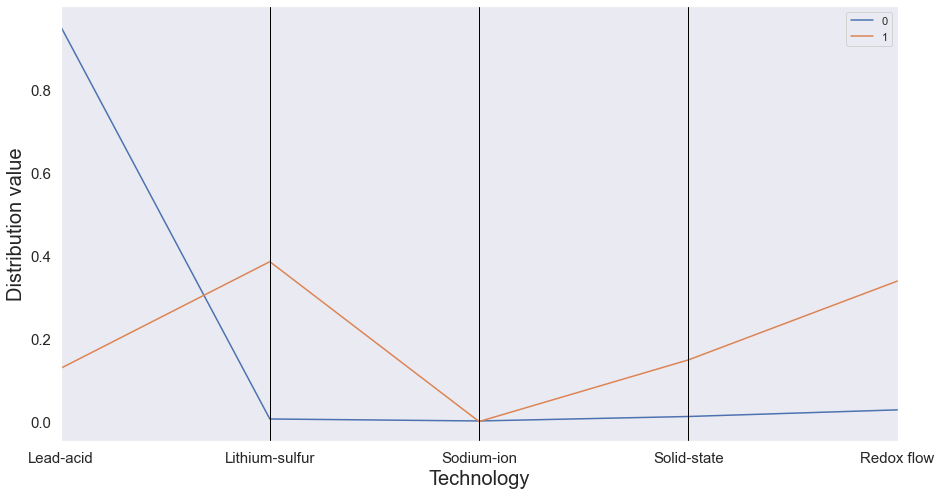

Cluster profiles


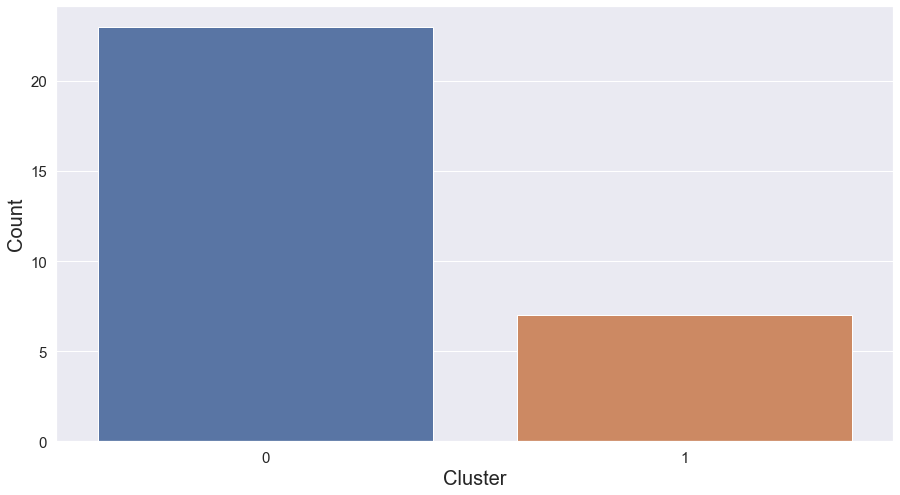

Counts per cluster


In [253]:
result_normalised_2000_2009_k_2, result_absolute_2000_2009_k_2 = run_k_means(data_to_cluster, data_normalised, data_absolute,
                                                                             False,
                                                                             n_clusters=2)

result_normalised = result_normalised_2000_2009_k_2
result_absolute = result_absolute_2000_2009_k_2

show_cluster_profiles(result_normalised)

plot_cluster_counts(result_normalised)


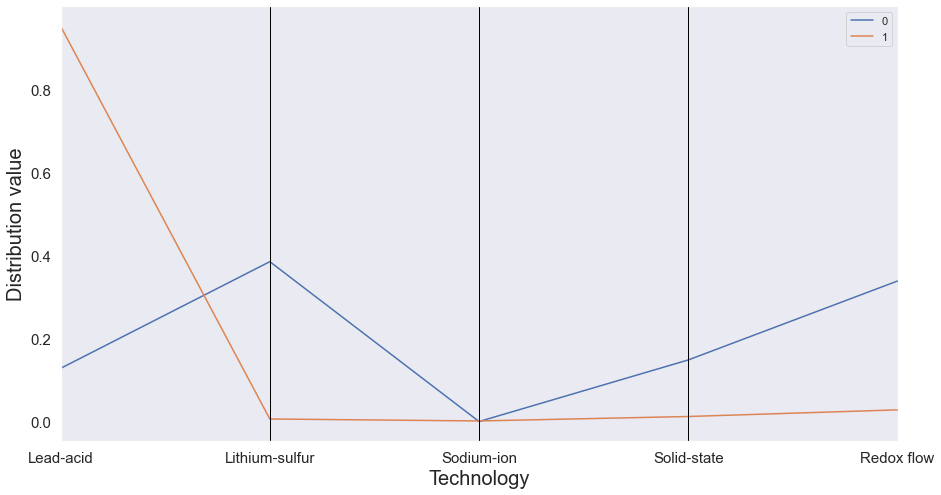

Cluster profiles


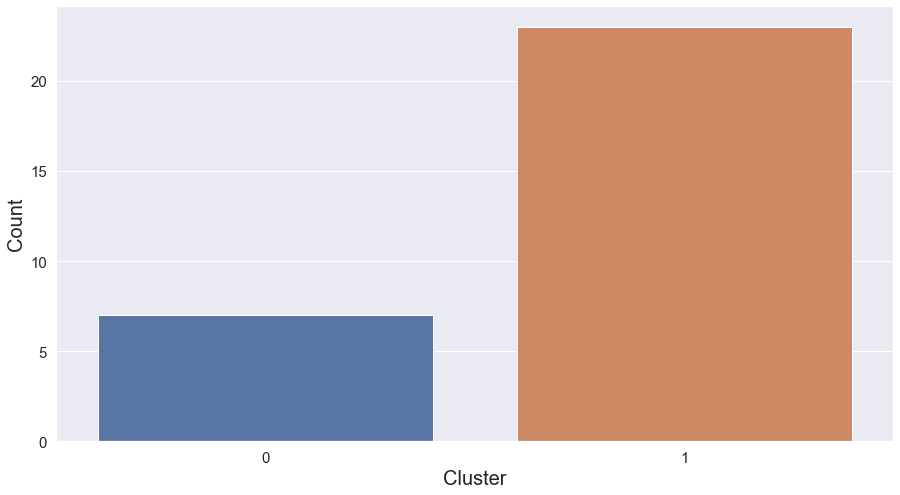

Counts per cluster


In [254]:
result_normalised_2000_2009_h_2, result_absolute_2000_2009_h_2 = run_agglomerative(data_to_cluster, data_normalised, data_absolute, n_clusters=2)

result_normalised = result_normalised_2000_2009_h_2
result_absolute = result_absolute_2000_2009_h_2

show_cluster_profiles(result_normalised)

plot_cluster_counts(result_normalised)


In [255]:
show_result(0)


7
['South Korea', 'Australia', 'Austria', 'Russia', 'Thailand', 'Netherlands', 'Greece']


Lead-acid  Lithium-sulfur  Sodium-ion  Solid-state  Redox flow  label
KR   4.500000          20.250         0.0          1.0    0.000000      0
AU   4.214286           0.000         0.0          0.0    6.000000      0
AT   0.500000           0.000         0.0          0.0    4.000000      0
RU   0.325000           3.250         0.0          0.0    0.000000      0
TH   0.125000           0.000         0.0          0.0    1.045455      0
NL   0.000000           0.000         0.0          1.0    0.000000      0
GR   0.000000           0.125         0.0          0.0    0.000000      0

In [256]:
show_result(1)


23
['Japan', 'USA', 'Germany', 'China', 'Ukraine', 'Canada', 'Italy', 'France', 'UK', 'Taiwan', 'Spain', 'India', 'Mexico', 'Switzerland', 'Luxembourg', 'Norway', 'Hungary', 'Hong Kong', 'New Zealand', 'Malta', 'Turkey', 'Bulgaria', 'Sweden']


Lead-acid  Lithium-sulfur  Sodium-ion  Solid-state  Redox flow  label
JP  74.119048        5.833333    3.333333          5.0   17.000000      1
US  78.924471        3.375000    0.000000          4.0    8.107143      1
DE  30.642857        0.000000    0.000000          0.0    2.000000      1
CN  18.095238        0.000000    0.000000          1.0    1.000000      1
UA  19.675000        0.000000    0.000000          0.0    0.000000      1
CA  14.764815        0.250000    0.000000          0.0    1.035714      1
IT   9.466667        0.000000    0.000000          0.0    0.765152      1
FR   9.866667        0.000000    0.000000          0.0    0.000000      1
GB   4.866667        0.250000    0.000000          1.0    1.071429      1
TW   5.125000        0.000000    0.000000          0.0    0.000000      1
ES   3.000000        0.000000    0.000000          0.0    0.000000      1
IN   2.500000        0.000000    0.000000          0.0    0.000000      1
MX   2.125000        0.000000    0.000000          0.0    0.000000      1
CH   1.333333        0.000000    0.000000          0.0    0.000000      1
LU   1.166667        0.000000    0.000000          0.0    0.000000      1
NO   1.142857        0.000000    0.000000          0.0    0.000000      1
HU   1.000000        0.000000    0.000000          0.0    0.000000      1
HK   1.000000        0.000000    0.000000          0.0    0.000000      1
NZ   1.000000        0.000000    0.000000          0.0    0.000000      1
MT   1.000000        0.000000    0.000000          0.0    0.000000      1
TR   1.000000        0.000000    0.000000          0.0    0.000000      1
BG   0.904762        0.000000    0.000000          0.0    0.000000      1
SE   0.266667        0.000000    0.000000          0.0    0.000000      1

##### Find 3 clusters

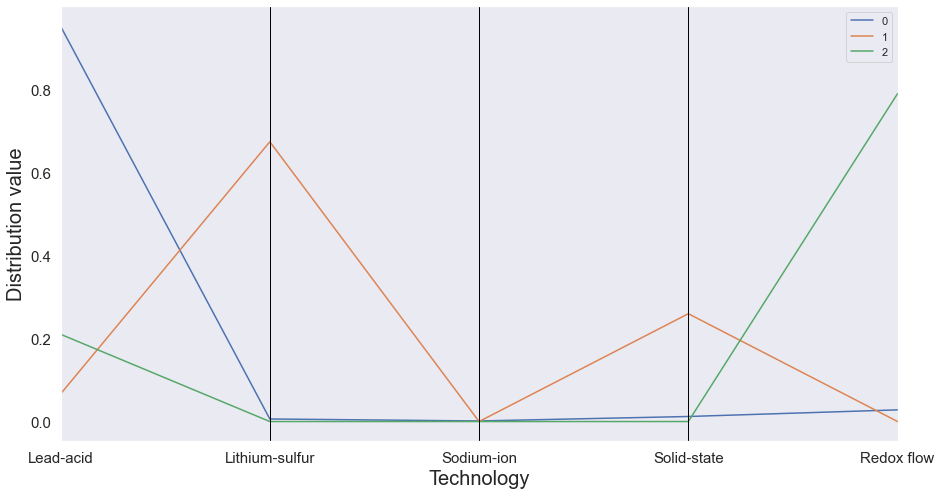

Cluster profiles


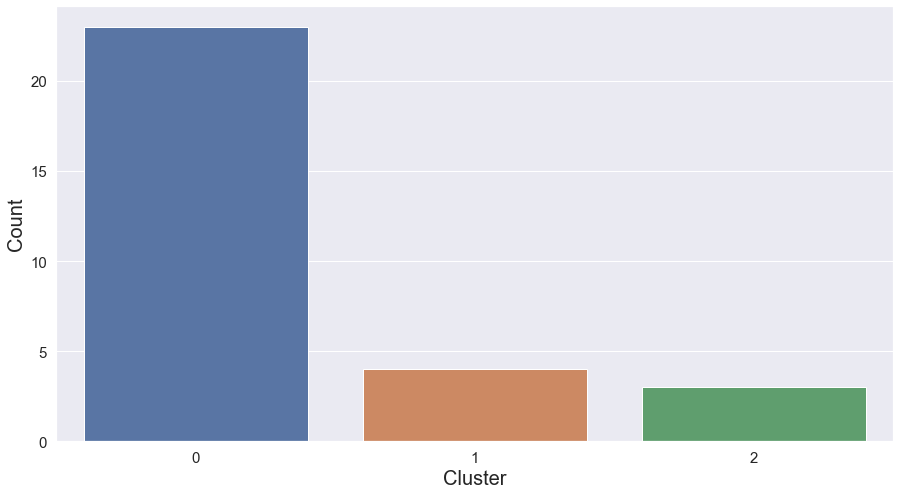

Counts per cluster


In [257]:
result_normalised_2000_2009_k_3, result_absolute_2000_2009_k_3 = run_k_means(data_to_cluster, data_normalised, data_absolute,
                                                                             False,
                                                                             n_clusters=3)

result_normalised = result_normalised_2000_2009_k_3
result_absolute = result_absolute_2000_2009_k_3

show_cluster_profiles(result_normalised)

plot_cluster_counts(result_normalised)

In [258]:
show_result(1)

4
['South Korea', 'Russia', 'Netherlands', 'Greece']


Lead-acid  Lithium-sulfur  Sodium-ion  Solid-state  Redox flow  label
KR      4.500          20.250         0.0          1.0         0.0      1
RU      0.325           3.250         0.0          0.0         0.0      1
NL      0.000           0.000         0.0          1.0         0.0      1
GR      0.000           0.125         0.0          0.0         0.0      1

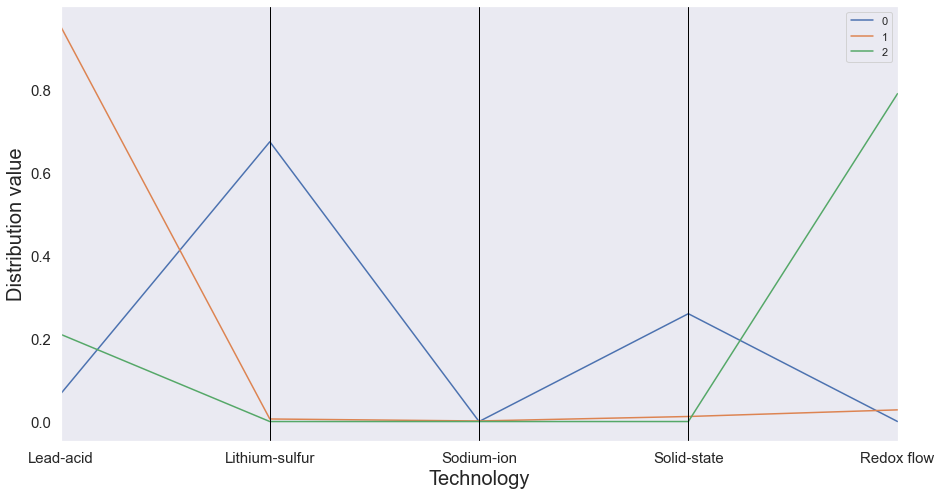

Cluster profiles


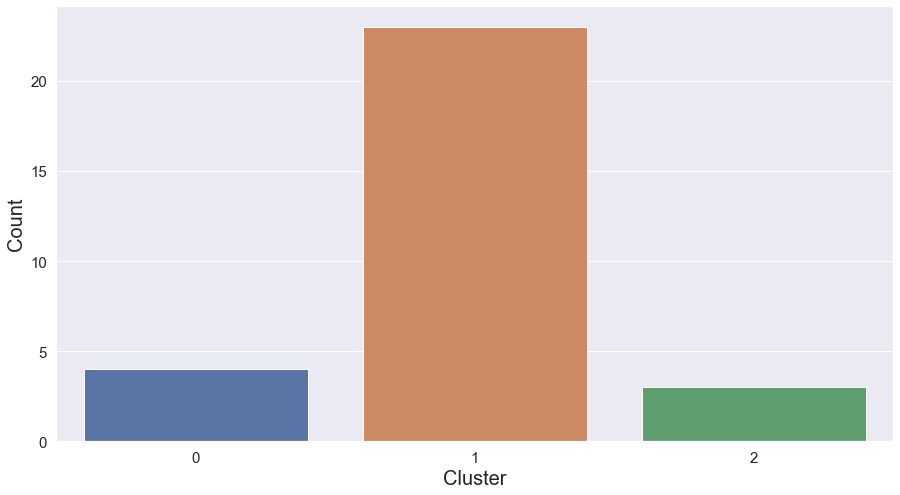

Counts per cluster


In [259]:
result_normalised_2000_2009_h_3, result_absolute_2000_2009_h_3 = run_agglomerative(data_to_cluster, data_normalised, data_absolute, n_clusters=3)

result_normalised = result_normalised_2000_2009_h_3
result_absolute = result_absolute_2000_2009_h_3

show_cluster_profiles(result_normalised)

plot_cluster_counts(result_normalised)

##### Find 5 clusters

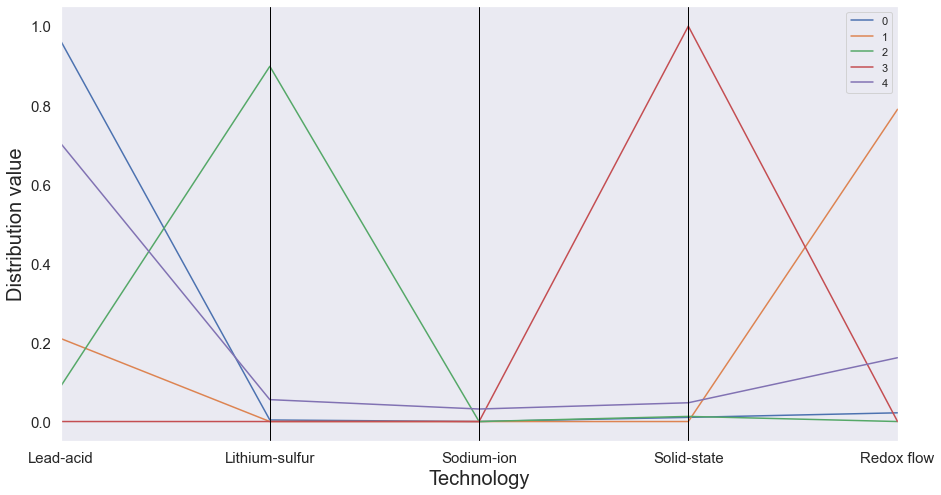

Cluster profiles


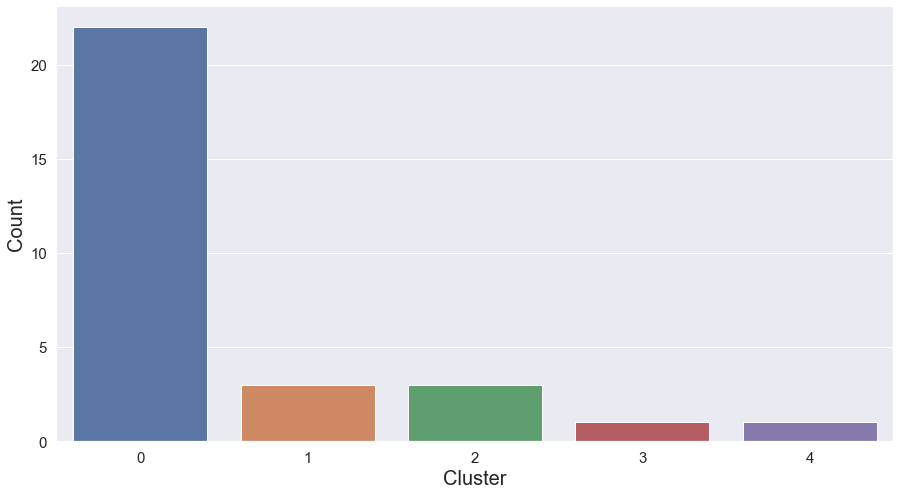

Counts per cluster


In [260]:
result_normalised_2000_2009_k_5, result_absolute_2000_2009_k_5 = run_k_means(data_to_cluster, data_normalised, data_absolute,
                                                                             False,
                                                                             n_clusters=5)

result_normalised = result_normalised_2000_2009_k_5
result_absolute = result_absolute_2000_2009_k_5

show_cluster_profiles(result_normalised)

plot_cluster_counts(result_normalised)


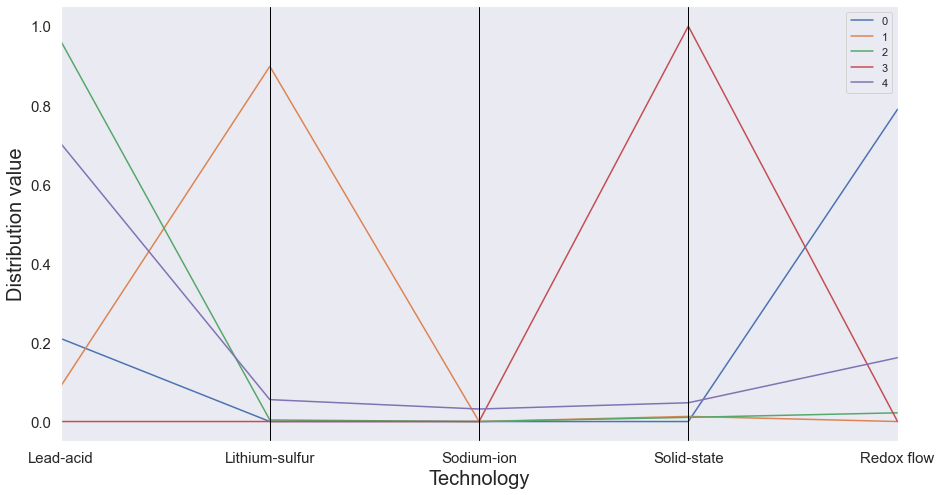

Cluster profiles


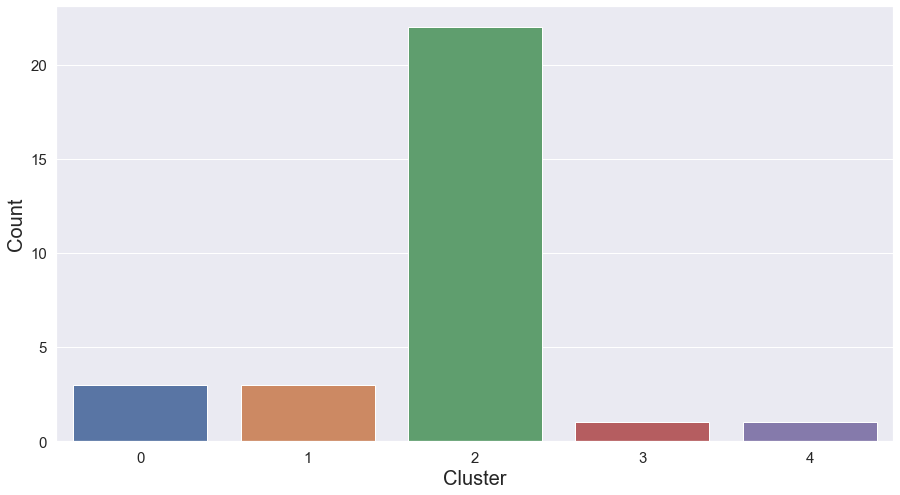

Counts per cluster


In [261]:
result_normalised_2000_2009_h_5, result_absolute_2000_2009_h_5 = run_agglomerative(data_to_cluster, data_normalised, data_absolute, n_clusters=5)

result_normalised = result_normalised_2000_2009_h_5
result_absolute = result_absolute_2000_2009_h_5

show_cluster_profiles(result_normalised)

plot_cluster_counts(result_normalised)


#### 2010-2019

In [262]:
data_absolute, data_normalised, data_to_cluster = get_dataframes(1,
                                                                tech_dist_dfs_absolute_list_2000_2010_2019,
                                                                tech_dist_dfs_normalised_list_2000_2010_2019,
                                                                tech_dist_dfs_normalised_scaled_list_2000_2010_2019)


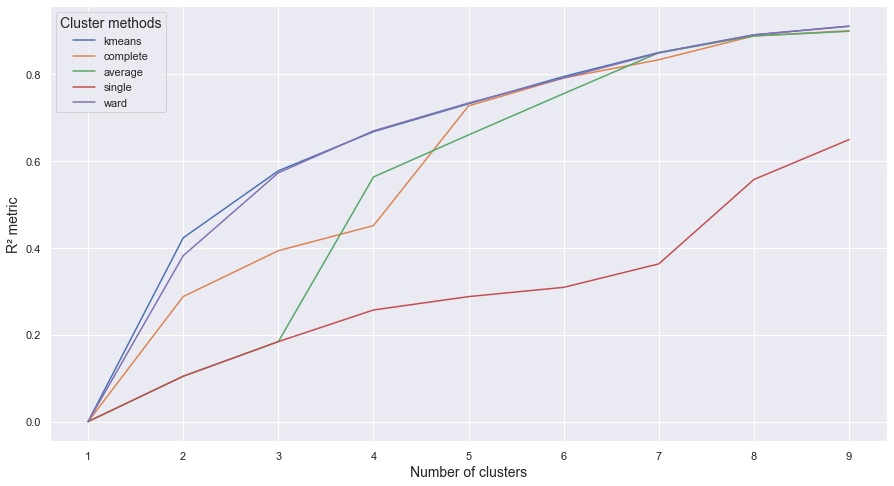

'R² plot for various clustering methods'

In [263]:
check_clustering_methods(data_to_cluster)


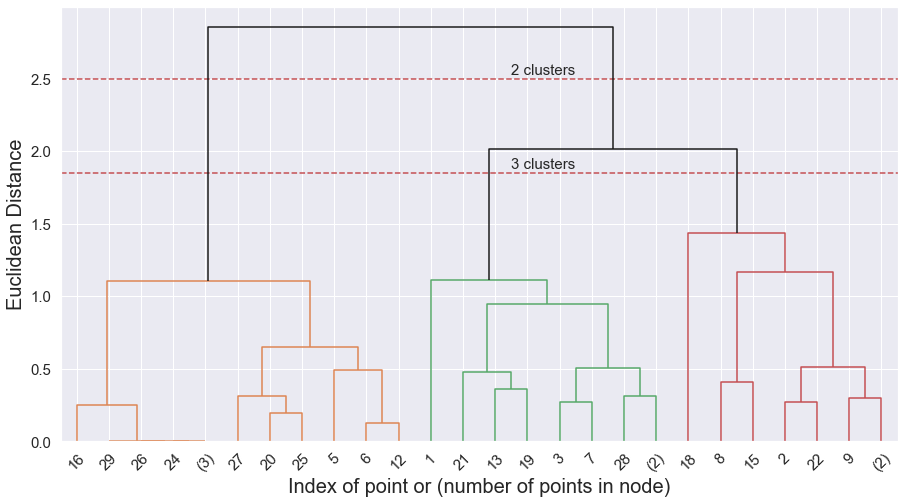

"Dendrogram - Hierarchical Clustering using Ward's linkage"

In [264]:
agglom_clustering_full(data_to_cluster, 2.5, 1.85)


##### Find 2 clusters

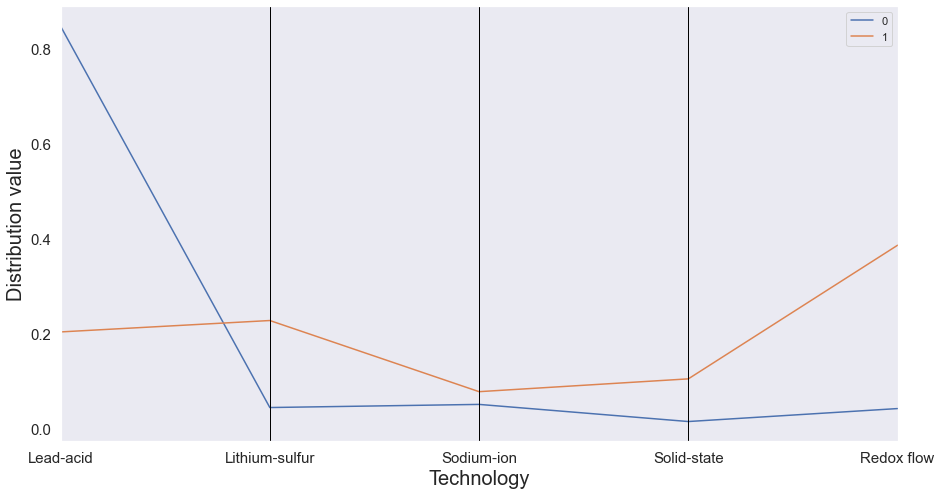

Cluster profiles


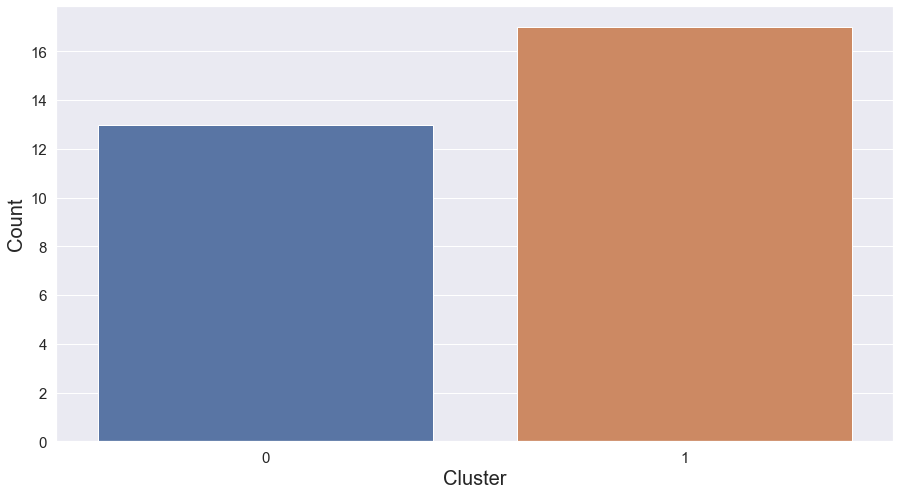

Counts per cluster


In [265]:
result_normalised_2010_2019_k_2, result_absolute_2010_2019_k_2 = run_k_means(data_to_cluster, data_normalised, data_absolute,
                                                                             False,
                                                                             n_clusters=2)

result_normalised = result_normalised_2010_2019_k_2
result_absolute = result_absolute_2010_2019_k_2

show_cluster_profiles(result_normalised)

plot_cluster_counts(result_normalised)


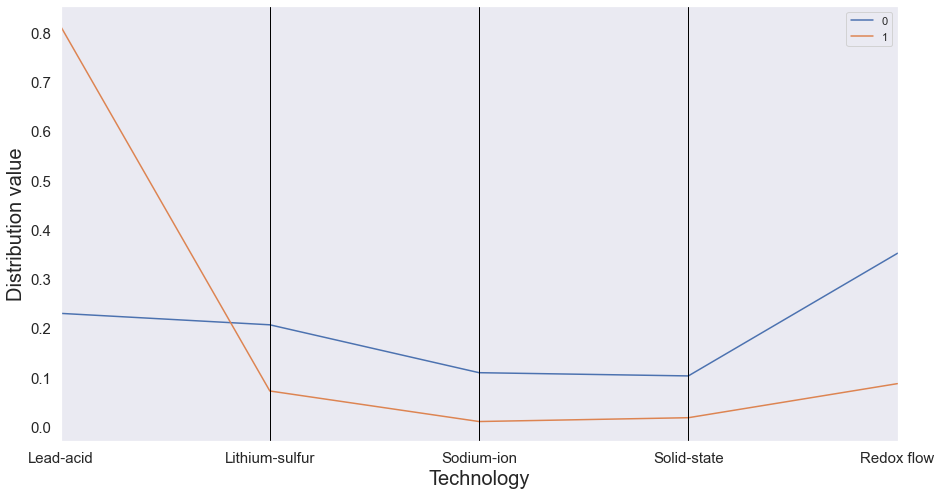

Cluster profiles


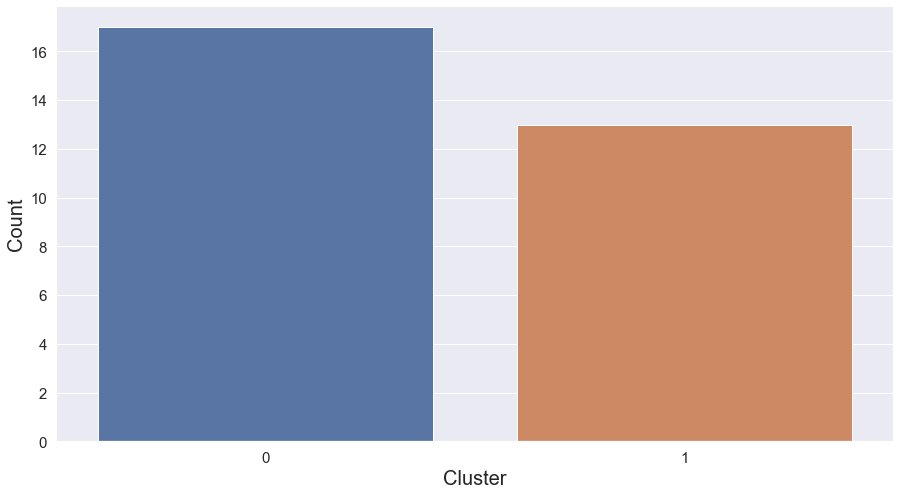

Counts per cluster


In [266]:
result_normalised_2010_2019_k_2, result_absolute_2010_2019_k_2 = run_agglomerative(data_to_cluster, data_normalised, data_absolute, n_clusters=2)

result_normalised = result_normalised_2010_2019_k_2
result_absolute = result_absolute_2010_2019_k_2

show_cluster_profiles(result_normalised)

plot_cluster_counts(result_normalised)


In [267]:
show_result(0)


17
['Japan', 'USA', 'South Korea', 'China', 'Germany', 'UK', 'France', 'Canada', 'Taiwan', 'Austria', 'Netherlands', 'Spain', 'Thailand', 'Switzerland', 'Norway', 'Hong Kong', 'Ukraine']


Lead-acid  Lithium-sulfur  Sodium-ion  Solid-state  Redox flow  label
JP  191.699026       40.047701   87.932143   434.247368  216.770263      0
US  136.911719       61.510281   22.516071    61.228175  208.145884      0
KR   19.000000      110.203530   28.179762    67.334774  149.934774      0
CN   59.266667       79.015868   29.627381    16.881548   59.923486      0
DE   28.391958       50.482900    2.291667    18.250000   58.630592      0
GB    4.771251       20.436869   10.958333     4.732143   16.289683      0
FR    7.696154       18.472222    8.767532     7.486111    6.615079      0
CA    6.692857        5.283333    4.928571     0.777778    5.983987      0
TW    4.500000        1.555556    0.750000     3.229167    9.000000      0
AT    2.000000        0.916667    0.000000     1.000000    9.948413      0
NL    6.000000        0.000000    0.000000     1.571429    5.493590      0
ES    1.750000        3.000000    2.818182     0.000000    2.357143      0
TH    0.000000        0.000000    0.000000     0.000000    6.500000      0
CH    0.000000        0.000000    0.416667     1.000000    4.166667      0
NO    0.625000        0.000000    0.166667     0.000000    0.041667      0
HK    0.000000        0.500000    0.000000     0.000000    0.000000      0
UA    0.250000        0.000000    0.125000     0.000000    0.000000      0

In [268]:
show_result(1)


13
['Italy', 'India', 'Russia', 'Turkey', 'Australia', 'Bulgaria', 'New Zealand', 'Luxembourg', 'Sweden', 'Malta', 'Mexico', 'Hungary', 'Greece']


Lead-acid  Lithium-sulfur  Sodium-ion  Solid-state  Redox flow  label
IT  10.250000        2.771429    0.000000     0.750000    6.854545      1
IN  10.522233        0.944444    0.830357     1.531746    0.815657      1
RU   5.000000        0.281385    0.000000     0.625000    0.976190      1
TR   5.000000        0.125000    0.500000     0.000000    1.125000      1
AU   3.179545        1.500000    0.000000     0.000000    2.000000      1
BG   5.571429        0.000000    0.000000     0.000000    0.000000      1
NZ   5.000000        0.000000    0.000000     0.000000    0.000000      1
LU   3.666667        0.000000    0.000000     0.000000    0.000000      1
SE   3.000000        0.000000    0.000000     0.000000    0.000000      1
MT   1.300000        0.000000    0.000000     0.000000    0.000000      1
MX   1.059524        0.000000    0.000000     0.000000    0.166667      1
HU   0.300000        0.250000    0.000000     0.000000    0.000000      1
GR   0.143590        0.000000    0.000000     0.000000    0.000000      1

##### Find 3 clusters

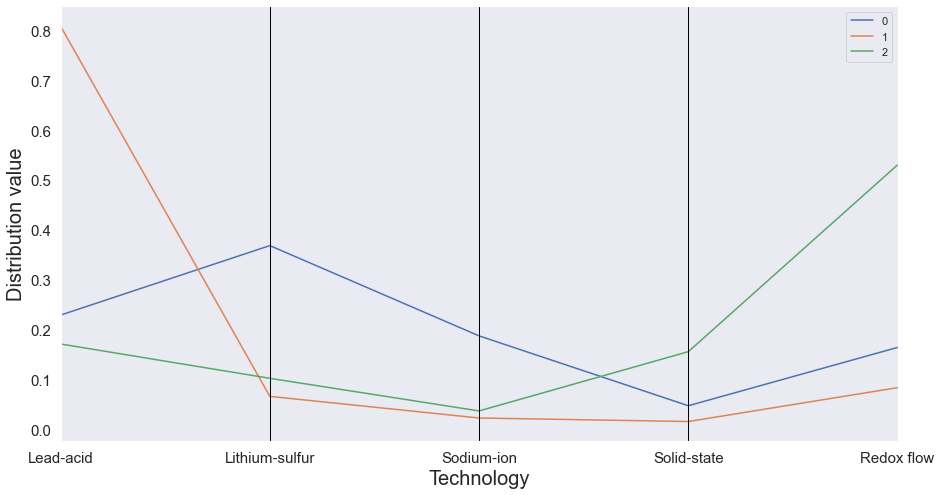

Cluster profiles


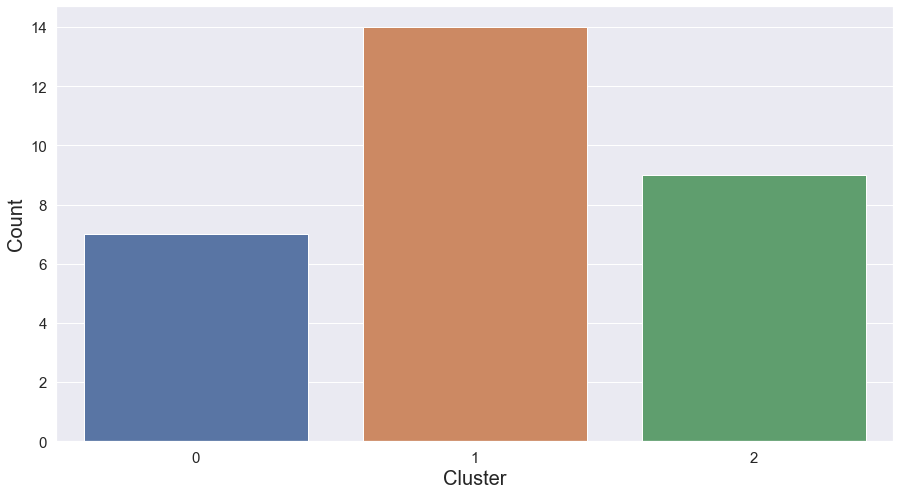

Counts per cluster


In [269]:
result_normalised_2010_2019_k_3, result_absolute_2010_2019_k_3 = run_k_means(
    data_to_cluster, data_normalised, data_absolute, 
    False,
    n_clusters=3)

result_normalised = result_normalised_2010_2019_k_3
result_absolute = result_absolute_2010_2019_k_3

show_cluster_profiles(result_normalised)

plot_cluster_counts(result_normalised)


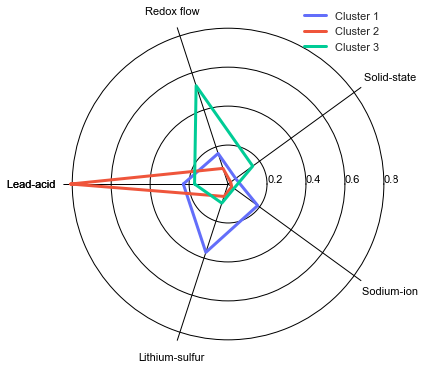

Clustering inventors' countries of origin by their
battery type distribution using recent ten years' data:
Profiles of three clusters computed by k-means algorithm


({0: [0.22976348900322718,
   0.3689210511359206,
   0.18814341381593064,
   0.048179643224503334,
   0.1649924028204183,
   0.22976348900322718],
  1: [0.8084441169436609,
   0.06695510733968471,
   0.023626805109994476,
   0.016554764453788128,
   0.08441920615287178,
   0.8084441169436609],
  2: [0.1718860884178494,
   0.10312316030265782,
   0.03780585166386864,
   0.1565090958241161,
   0.530675803791508,
   0.1718860884178494]},
 <Figure size 432x504 with 1 Axes>)

In [270]:
cluster_profiles_radar(
    result_normalised,
    "Clustering inventors' countries of origin by their\nbattery type distribution using recent ten years' data:\nProfiles of three clusters computed by k-means algorithm",
    (0.7, 0.87), # legend_pos
    40, # title_pad
    [0.2, 0.4, 0.6, 0.8], # y_ticks
    False,
    True,
    'major',
    'both',
    'black',
    '-',
    1
)


In [271]:
len(result_normalised)


30

In [272]:
if False:
    
    result_normalised_2010_2019_h_3, result_absolute_2010_2019_h_3 = run_agglomerative(data_to_cluster, data_normalised, data_absolute, n_clusters=3)

    result_normalised = result_normalised_2010_2019_h_3
    result_absolute = result_absolute_2010_2019_h_3

    show_cluster_profiles(result_normalised)

    plot_cluster_counts(result_normalised)


In [273]:
# find
show_result(0)


7
['China', 'UK', 'France', 'Canada', 'Spain', 'Hong Kong', 'Ukraine']


Lead-acid  Lithium-sulfur  Sodium-ion  Solid-state  Redox flow  label
CN  59.266667       79.015868   29.627381    16.881548   59.923486      0
GB   4.771251       20.436869   10.958333     4.732143   16.289683      0
FR   7.696154       18.472222    8.767532     7.486111    6.615079      0
CA   6.692857        5.283333    4.928571     0.777778    5.983987      0
ES   1.750000        3.000000    2.818182     0.000000    2.357143      0
HK   0.000000        0.500000    0.000000     0.000000    0.000000      0
UA   0.250000        0.000000    0.125000     0.000000    0.000000      0

In [274]:
show_result(1)


14
['Italy', 'India', 'Russia', 'Turkey', 'Australia', 'Bulgaria', 'New Zealand', 'Luxembourg', 'Sweden', 'Malta', 'Mexico', 'Norway', 'Hungary', 'Greece']


Lead-acid  Lithium-sulfur  Sodium-ion  Solid-state  Redox flow  label
IT  10.250000        2.771429    0.000000     0.750000    6.854545      1
IN  10.522233        0.944444    0.830357     1.531746    0.815657      1
RU   5.000000        0.281385    0.000000     0.625000    0.976190      1
TR   5.000000        0.125000    0.500000     0.000000    1.125000      1
AU   3.179545        1.500000    0.000000     0.000000    2.000000      1
BG   5.571429        0.000000    0.000000     0.000000    0.000000      1
NZ   5.000000        0.000000    0.000000     0.000000    0.000000      1
LU   3.666667        0.000000    0.000000     0.000000    0.000000      1
SE   3.000000        0.000000    0.000000     0.000000    0.000000      1
MT   1.300000        0.000000    0.000000     0.000000    0.000000      1
MX   1.059524        0.000000    0.000000     0.000000    0.166667      1
NO   0.625000        0.000000    0.166667     0.000000    0.041667      1
HU   0.300000        0.250000    0.000000     0.000000    0.000000      1
GR   0.143590        0.000000    0.000000     0.000000    0.000000      1

In [275]:
show_result(2)


9
['Japan', 'USA', 'South Korea', 'Germany', 'Taiwan', 'Austria', 'Netherlands', 'Thailand', 'Switzerland']


Lead-acid  Lithium-sulfur  Sodium-ion  Solid-state  Redox flow  label
JP  191.699026       40.047701   87.932143   434.247368  216.770263      2
US  136.911719       61.510281   22.516071    61.228175  208.145884      2
KR   19.000000      110.203530   28.179762    67.334774  149.934774      2
DE   28.391958       50.482900    2.291667    18.250000   58.630592      2
TW    4.500000        1.555556    0.750000     3.229167    9.000000      2
AT    2.000000        0.916667    0.000000     1.000000    9.948413      2
NL    6.000000        0.000000    0.000000     1.571429    5.493590      2
TH    0.000000        0.000000    0.000000     0.000000    6.500000      2
CH    0.000000        0.000000    0.416667     1.000000    4.166667      2

##### Find 4 clusters

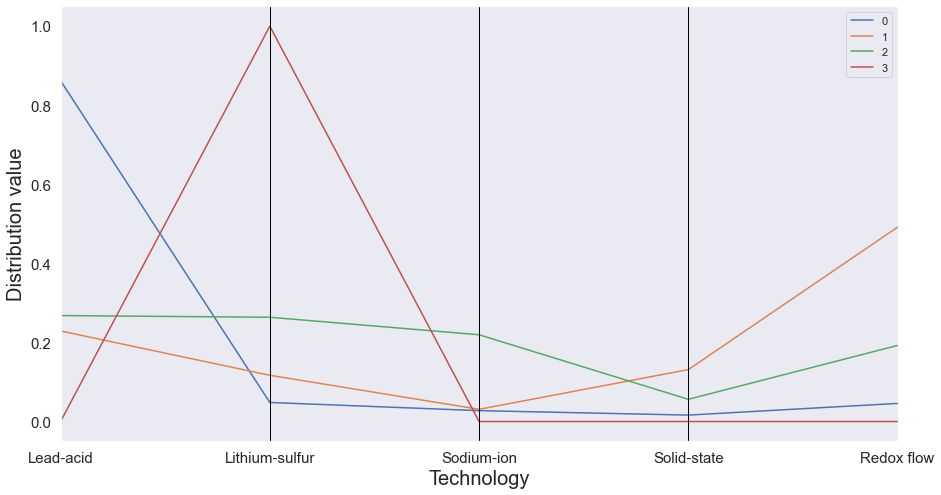

Cluster profiles


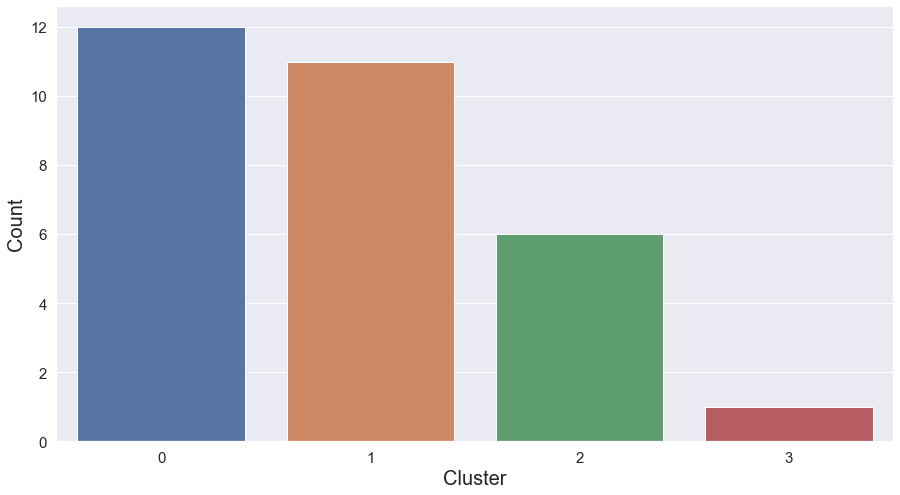

Counts per cluster


In [276]:
result_normalised_2010_2019_k_4, result_absolute_2010_2019_k_4 = run_k_means(
    data_to_cluster, data_normalised, data_absolute,
    False,
    n_clusters=4)

result_normalised = result_normalised_2010_2019_k_4
result_absolute = result_absolute_2010_2019_k_4

show_cluster_profiles(result_normalised)

plot_cluster_counts(result_normalised)

In [277]:
if False:
    
    result_normalised_2010_2019_h_4, result_absolute_2010_2019_h_4 = run_agglomerative(
        data_to_cluster, data_normalised, data_absolute, n_clusters=4)

    result_normalised = result_normalised_2010_2019_h_4
    result_absolute = result_absolute_2010_2019_h_4

    show_cluster_profiles(result_normalised)

    plot_cluster_counts(result_normalised)

In [278]:
show_result(0)


12
['India', 'Russia', 'Turkey', 'Bulgaria', 'New Zealand', 'Luxembourg', 'Sweden', 'Malta', 'Mexico', 'Norway', 'Hungary', 'Greece']


Lead-acid  Lithium-sulfur  Sodium-ion  Solid-state  Redox flow  label
IN  10.522233        0.944444    0.830357     1.531746    0.815657      0
RU   5.000000        0.281385    0.000000     0.625000    0.976190      0
TR   5.000000        0.125000    0.500000     0.000000    1.125000      0
BG   5.571429        0.000000    0.000000     0.000000    0.000000      0
NZ   5.000000        0.000000    0.000000     0.000000    0.000000      0
LU   3.666667        0.000000    0.000000     0.000000    0.000000      0
SE   3.000000        0.000000    0.000000     0.000000    0.000000      0
MT   1.300000        0.000000    0.000000     0.000000    0.000000      0
MX   1.059524        0.000000    0.000000     0.000000    0.166667      0
NO   0.625000        0.000000    0.166667     0.000000    0.041667      0
HU   0.300000        0.250000    0.000000     0.000000    0.000000      0
GR   0.143590        0.000000    0.000000     0.000000    0.000000      0

In [279]:
show_result(1)


11
['Japan', 'USA', 'South Korea', 'Germany', 'Italy', 'Taiwan', 'Austria', 'Netherlands', 'Australia', 'Thailand', 'Switzerland']


Lead-acid  Lithium-sulfur  Sodium-ion  Solid-state  Redox flow  label
JP  191.699026       40.047701   87.932143   434.247368  216.770263      1
US  136.911719       61.510281   22.516071    61.228175  208.145884      1
KR   19.000000      110.203530   28.179762    67.334774  149.934774      1
DE   28.391958       50.482900    2.291667    18.250000   58.630592      1
IT   10.250000        2.771429    0.000000     0.750000    6.854545      1
TW    4.500000        1.555556    0.750000     3.229167    9.000000      1
AT    2.000000        0.916667    0.000000     1.000000    9.948413      1
NL    6.000000        0.000000    0.000000     1.571429    5.493590      1
AU    3.179545        1.500000    0.000000     0.000000    2.000000      1
TH    0.000000        0.000000    0.000000     0.000000    6.500000      1
CH    0.000000        0.000000    0.416667     1.000000    4.166667      1

In [280]:
show_result(2)


6
['China', 'UK', 'France', 'Canada', 'Spain', 'Ukraine']


Lead-acid  Lithium-sulfur  Sodium-ion  Solid-state  Redox flow  label
CN  59.266667       79.015868   29.627381    16.881548   59.923486      2
GB   4.771251       20.436869   10.958333     4.732143   16.289683      2
FR   7.696154       18.472222    8.767532     7.486111    6.615079      2
CA   6.692857        5.283333    4.928571     0.777778    5.983987      2
ES   1.750000        3.000000    2.818182     0.000000    2.357143      2
UA   0.250000        0.000000    0.125000     0.000000    0.000000      2

In [281]:
show_result(3)


1
['Hong Kong']


Lead-acid  Lithium-sulfur  Sodium-ion  Solid-state  Redox flow  label
HK        0.0             0.5         0.0          0.0         0.0      3

## Collect all final plots in one place

In [282]:
totals_plot.show()

In [283]:
continent_plot.show()


In [284]:
continent_plot_scaled


In [285]:
person_ctry_code_plot.show()


In [286]:
person_ctry_pop_plot_2.show()


In [290]:
rel_to_first_year_plot.show()


In [291]:
rel_to_first_year_scaled_plot.show()


In [287]:
bubbles_plot.show()


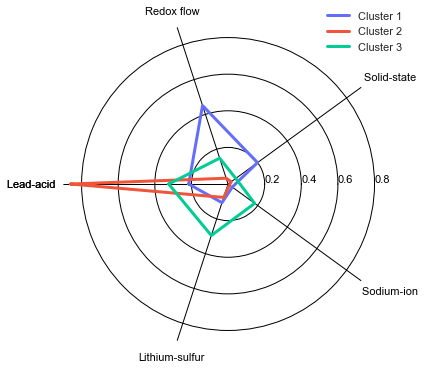

In [288]:
radar_3


### Not in the paper but good for getting an overview of all technologies' developments

In [289]:
technologies_countries_all_plot.show()
